In [1]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import h5py as h5
import astropy.units as u
import warnings
import math
import seaborn as sns
import pickle

from gwpopulation.models.redshift import PowerLawRedshift
import deepdish as dd

from matplotlib import rc
from KDEpy import FFTKDE  # Fastest 1D algorithm
from   astropy.cosmology import WMAP9 as cosmology
from astropy.cosmology import z_at_value
from scipy import stats
from   scipy.optimize import newton
from scipy.optimize import curve_fit

# Import COMPAS root directory and set data
compasRootDir   = '/Users/adamboesky/Research/PRISE/COMPAS'

# Import COMPAS specific scripts
sys.path.append(compasRootDir + '/utils/CosmicIntegration/')
sys.path.append(os.getcwd() + '/Scripts')
from pickle_writers import pickle_rates_and_boostraps
import ClassCOMPAS, ClassMSSFR, ClassCosmicIntegrator 
import FastCosmicIntegration as FCI 
import selection_effects
import formation_channels

# Magic function to set the backend of matplotlib to the 'inline' backend
%matplotlib inline

#Set latex environment for plots/labels
# plt.rcParams['text.latex.preamble'] = r'\usepackage{sfmath} \boldmath'
plt.rcParams['text.usetex'] = True
# plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['axes.labelweight'] = 'bold'
# plt.rcParams['font.sans-serif'] = 'serif'
# plt.rcParams['mathtext.fontset'] = 'stix'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_780/1997916609.py:50: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
path_to_data = '/Volumes/T7/Research_Data/final_sigma_remnant_prescription/'

# Get paths for the data files in the $\alpha_{\textrm{CE}}$ and $\beta$ grid

In [12]:
alpha_vals = ['30', '265', '750'] # All the alpha values
beta_vals = ['D', 'M', 'R'] # All the beta values

condensed_paths = {} # 2D dictionary holding the paths to the output h5 files for which the first dimension is the alpha CE value and the second is the beta value

for velocity_dispersion in alpha_vals:
    condensed_paths[velocity_dispersion] = {}
    for remnant_mass_p in beta_vals:
        condensed_paths[velocity_dispersion][remnant_mass_p] = path_to_data+'output_sigma_'+velocity_dispersion+'_remnant_prescription_'+remnant_mass_p+'/COMPAS_Output_Weighted.h5'

# Merger Rates $R(z)$

Define parameters for the merger rate calculation

In [4]:
# First define the parameters

# For what DCO would you like the rate?  options: all, BBH, BHNS BNS
weight_column   = 'mixture_weight'
                        
merges_hubble_time     = True
pessimistic_CEE        = True
no_RLOF_after_CEE      = True

# Options for the redshift evolution 
max_redshift           = 10.0
max_redshift_detection = 2.0
redshift_step          = 0.001
z_first_SF             = 10

# Metallicity of the Universe
min_logZ               = -12.0 
max_logZ               = 1.0 
step_logZ              = 0.01

#and detector sensitivity
sensitivity            = "O1" 
snr_threshold          = 8 

Mc_max                 = 300.0 * (1 + max_redshift_detection)
Mc_step                = 0.1 
eta_max                = 0.25 
eta_step               = 0.01
snr_max                = 1000.0 
snr_step               = 0.1

# Parameters to calculate the representing SF mass (make sure these match YOUR simulation!)
m1_min          = 5     # * u.Msun 
m1_max          = 150   # * u.Msun
m2_min          = m1_min * 0.01 # m2_min = min(q) * min(m1)
fbin            = 1.0

# Van Son 2022 prescriptions:
mu0             = 0.025
muz             = -0.048
sigma0          = 1.125
sigmaz          = 0.048
alpha           = -1.77

aSF             = 0.02
bSF             = 1.48 
cSF             = 4.45 
dSF             = 5.9

# MY FIDUCIAL MSSFR PRESCRIPTIONS
lognormal=False                                     # !!! IF THIS PARAMETER IS FALSE, IT WILL USE THE NON-LOGNORMAL MSSFR PRESCRIPTIONS !!!
Zprescription='MZ_GSMF'
SFRprescription='Madau et al. (2017)'
GSMFprescription='Panter et al. (2004) Single'
ZMprescription='Ma et al. (2016)'
logNormalPrescription=None

In [5]:
plt.style.use('ggplot')                                                          
# rainbow_cmap = matplotlib.cm.get_cmap('rainbow')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
num_colors = len(alpha_vals)
counter = 0
color_grid = {}
marker_grid = {}
linestyle_grid = {}
for alpha_index, alpha_val in enumerate(alpha_vals):
    color_grid[alpha_val] = {}
    marker_grid[alpha_val] = {}
    linestyle_grid[alpha_val] = {}
    for beta_index, beta_val in enumerate(beta_vals):
        # color_grid[alpha_val][beta_val] = rainbow_cmap(alpha_index/num_colors)
        if alpha_index == 0:
            color_grid[alpha_val][beta_val] = colors[6]
        elif alpha_index == 1:
            color_grid[alpha_val][beta_val] = colors[3]
        else:
            color_grid[alpha_val][beta_val] = '#6085ff'

        if beta_val == 'D':
            linestyle_grid[alpha_val][beta_val] = 'solid'
            marker_grid[alpha_val][beta_val] = 'o'
        elif beta_val == 'M':
            linestyle_grid[alpha_val][beta_val] = 'dashed'
            marker_grid[alpha_val][beta_val] = '^'
        elif beta_val == 'R':
            linestyle_grid[alpha_val][beta_val] = 'dashdot'
            marker_grid[alpha_val][beta_val] = '*'

plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

#FBC15E


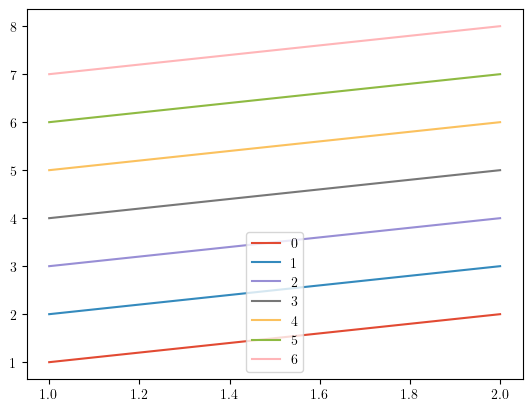

In [54]:
for i, col in enumerate(colors):
    plt.plot([1,2], np.array([1,2]) + i, color=col, label = i)
plt.legend()
print(colors[4])

In [98]:
def add_lookback_t_axes(ax, labelsize=15, z_range=[0, 10], no_label=False):
    ax2  = ax.twiny()
    # second x-axis for age
    # axes2.xaxis.labelpad = 20
    ax2.tick_params(labelsize=labelsize*0.9)
    redshifts = np.linspace(0,10,100)
    #strolger works in age not redshift
    ages      = cosmology.age(redshifts).value
    #find nearest redshift to age
    agelabels = np.array([1,2,3,4,5,7, 9]) # Gyr
    ageUniverse = cosmology.age(0)
    redshiftTicks = np.zeros(len(agelabels))
    for nr, age in enumerate(agelabels):
        distance = np.abs(ages-age)
        # distance = np.abs(ages-age+cosmology.age(np.array([10])).value[0])
        ind      = np.where(distance==np.min(distance))[0][0]
        redshiftTicks[nr] =  redshifts[ind]

    ax2.set_xlim(z_range)
    ax2.set_xticks(redshiftTicks)
    ax2.set_xticklabels(agelabels)
    if not no_label:
        nameX2 = r'\textbf{Age Universe [Gyr]}'
        ax2.set_xlabel(nameX2, fontsize=labelsize, labelpad=10)
    return ax2

<AxesSubplot:xlabel='\\textbf{Age Universe [Gyr]}'>

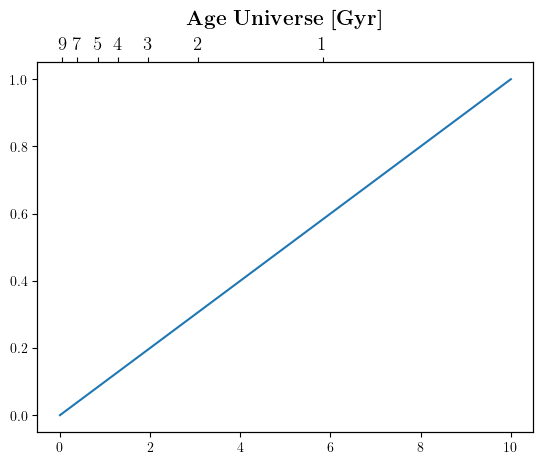

In [84]:
plt.plot([0,10], [0,1])
ax = plt.gca()
add_lookback_t_axes(ax)

In [13]:
with open(path_to_data + 'output_alpha_CE_0.1_beta_0.5/Pickled_Rates/MSSFR_111/BBH/rates_and_bootstraps.h5', 'rb') as f:
    # Get data
    h5_data = h5.File(f)

    # Get redshifts to use for the SFR
    sfr_redshifts = h5_data['Actual']['redshifts'][...]

ages_yrs = cosmology.age(sfr_redshifts).to(u.Myr).value
ages_yrs_500 = ages_yrs * u.Myr + 500 * u.Myr
z_shifted_500 = z_at_value(cosmology.age, ages_yrs_500, zmin=-1)

# Retreive the SFR
MSSFR = ClassMSSFR.MSSFR()                              # Create an MSSFR object
MSSFR.SFRprescription = SFRprescription                 # Set SFR prescription
ages = MSSFR.cosmology.age(sfr_redshifts).value         # Get the ages
sfr = MSSFR.returnSFR(sfr_redshifts, ages)              # Get the SFR
sfr_area = np.trapz(sfr, x=sfr_redshifts)               # Get the area under the curve
sfr_normalized = sfr/sfr_area                           # Make it so the area under the curve is 1

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/T7/Research_Data/final_sigma_remnant_prescription/output_alpha_CE_0.1_beta_0.5/Pickled_Rates/MSSFR_111/BBH/rates_and_bootstraps.h5'

In [16]:
print(type(z_shifted_500))
print(type(sfr))


<class 'astropy.units.quantity.Quantity'>
<class 'numpy.ndarray'>


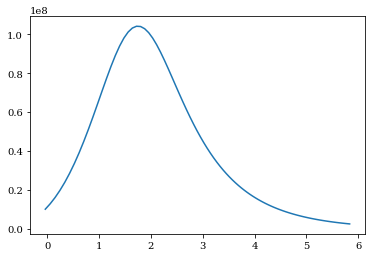

In [17]:
plt.plot(z_shifted_500.to(''), sfr)

## Function used to retrieve and plot the merger rates

In [90]:
def plot_pickled_rates_sfr_norm(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=2, figsize=(20, 7), show_legend=True, bbox_to_anchor=(0.9, 1.25),
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # Make sure the dco_type is given
    assert dco_type != None, 'dco_type must be given'

    CI_kwargs = {'dco_type': dco_type, 'merger_output_filename': merger_output_filename, 'weight_column': weight_column, 'merges_hubble_time': merges_hubble_time, 'pessimistic_CEE': pessimistic_CEE, 
                        'no_RLOF_after_CEE': no_RLOF_after_CEE, 'max_redshift': max_redshift, 'max_redshift_detection': max_redshift_detection, 'redshift_step': redshift_step, 'z_first_SF': z_first_SF,
                        'use_sampled_mass_ranges': use_sampled_mass_ranges, 'm1_min': m1_min, 'm1_max': m1_max, 'm2_min': m2_min, 'fbin': fbin,
                        'aSF': aSF, 'bSF': bSF, 'cSF': cSF, 'dSF': dSF,
                        'mu0': mu0, 'muz': muz, 'sigma0': sigma0, 'sigmaz': sigmaz, 'alpha': alpha, 
                        'min_logZ': min_logZ, 'max_logZ': max_logZ, 'step_logZ': step_logZ,
                        'sensitivity': sensitivity, 'snr_threshold': snr_threshold, 
                        'Mc_max': Mc_max, 'Mc_step': Mc_step, 'eta_max': eta_max, 'eta_step': eta_step,
                        'snr_max': snr_max, 'snr_step': snr_step,
                        'lognormal': lognormal, 'Zprescription': Zprescription, 'SFRprescription': SFRprescription,
                        'GSMFprescription': GSMFprescription, 'ZMprescription': ZMprescription,
                        'logNormalPrescription': logNormalPrescription}

    # 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)
    total_merger_rates = {}
    total_detection_rates = {}
    cumulative_detection_rates = {}
    detection_rates_by_binary = {}
    mass_kde_scaled = {}
    redshifts = {}
    Mc_bins = {}
    one_sigma = {}
    two_sigma = {}

    for alpha_index, alpha_val in enumerate(alpha_vals):
        # Make the dictionary "2D"
        total_merger_rates[alpha_val] = {}
        total_detection_rates[alpha_val] = {}
        cumulative_detection_rates[alpha_val] = {}
        detection_rates_by_binary[alpha_val] = {}
        mass_kde_scaled[alpha_val] = {}
        Mc_bins[alpha_val] = {}
        one_sigma[alpha_val] = {}
        two_sigma[alpha_val] = {}

        redshifts[alpha_val] = {}

        for beta_index, beta_val in enumerate(beta_vals):
            one_sigma[alpha_val][beta_val] = {}
            two_sigma[alpha_val][beta_val] = {}
        
            with open(path_to_data + 'output_sigma_'+alpha_val+'_remnant_prescription_'+beta_val+'/Pickled_Rates/MSSFR_111/'+dco_type+'/rates_and_bootstraps.h5', 'rb') as f:
                # Get data
                h5_data = h5.File(f)
                total_merger_rates[alpha_val][beta_val] = h5_data['Actual']['total_merger_rates'][...]
                # redshifts[alpha_val][beta_val] = dict['redshfits']
                redshifts[alpha_val][beta_val] = h5_data['Actual']['redshifts'][...]
                cumulative_detection_rates[alpha_val][beta_val] = h5_data['Actual']['cumulative_detection_rates'][...]
                mass_kde_scaled[alpha_val][beta_val] = h5_data['Actual']['mass_kde_scaled'][...]

                # Declare bins for the chirp mass KDE
                COMPAS = ClassCOMPAS.COMPASData(condensed_paths[alpha_val][beta_val], Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
                COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
                COMPAS.setCOMPASData()
                COMPAS.set_sw_weights(weight_column)            
                chirp_masses = (COMPAS.mass1*COMPAS.mass2)**(3./5.) / (COMPAS.mass1 + COMPAS.mass2)**(1./5.)
                Mc_bins[alpha_val][beta_val] = np.arange(0, max(chirp_masses)*1.3, max(chirp_masses)*1.2/100) # We need to pass in the bins for the chirp mass distribution so we will declare them here

                # empty trash
                del chirp_masses
                del COMPAS

                # Calculate confidence intervals
                one_sigma[alpha_val][beta_val]['total_merger_rates']             =   np.percentile(h5_data['Bootstraps']['total_merger_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['cumulative_detection_rates']     =   np.percentile(h5_data['Bootstraps']['cumulative_detection_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [16, 84], axis=0)

                # Get the two sigma confidence intervals
                two_sigma[alpha_val][beta_val]['total_merger_rates']             =   np.percentile(h5_data['Bootstraps']['total_merger_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['cumulative_detection_rates']     =   np.percentile(h5_data['Bootstraps']['cumulative_detection_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [2.5, 97.5], axis=0)

            # # Delete trash object
            # del COMPASs



    ###########################
    #Start plotting

    # set some constants for the plots
    plt.rc('font', family='serif')
    fs = 24
    tickLengthMajor = 7
    tickLengthMinor = 3.5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Get redshifts to use for the SFR
    sfr_redshifts = redshifts['30']['D']

    # Retreive the SFR
    MSSFR = ClassMSSFR.MSSFR()                              # Create an MSSFR object
    MSSFR.SFRprescription = SFRprescription                 # Set SFR prescription
    ages = MSSFR.cosmology.age(sfr_redshifts).value         # Get the ages
    sfr = MSSFR.returnSFR(sfr_redshifts, ages)              # Get the SFR
    sfr_area = np.trapz(sfr, x=sfr_redshifts)               # Get the area under the curve
    sfr_normalized = sfr/sfr_area                           # Make it so the area under the curve is 1
    if dco_type == 'BBH':
        marker_period = 10
    else:
        marker_period = 1000

    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            # Plot each of the panels, and their confidence intervals
            axes[0].plot(redshifts[alpha_val][beta_val], total_merger_rates[alpha_val][beta_val], lw=lw, label=r'$\sigma_{\textrm{rms}}^{1D} = $' + alpha_val + r'$\textrm{ RMP} = $' + beta_val, color=color_grid[alpha_val][beta_val], marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)
            axes[0].fill_between(x=redshifts[alpha_val][beta_val], y1=one_sigma[alpha_val][beta_val]['total_merger_rates'][0], y2=one_sigma[alpha_val][beta_val]['total_merger_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[0].fill_between(x=redshifts[alpha_val][beta_val], y1=two_sigma[alpha_val][beta_val]['total_merger_rates'][0], y2=two_sigma[alpha_val][beta_val]['total_merger_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])

            merger_rate_area = np.trapz(total_merger_rates[alpha_val][beta_val], x=redshifts[alpha_val][beta_val])
            axes[1].plot(redshifts[alpha_val][beta_val], (total_merger_rates[alpha_val][beta_val] / merger_rate_area) / sfr_normalized, lw=lw, color=color_grid[alpha_val][beta_val], marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)
            axes[1].fill_between(x=redshifts[alpha_val][beta_val], y1=(one_sigma[alpha_val][beta_val]['total_merger_rates'][0] / merger_rate_area) / sfr_normalized, y2=(one_sigma[alpha_val][beta_val]['total_merger_rates'][1] / merger_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[1].fill_between(x=redshifts[alpha_val][beta_val], y1=(two_sigma[alpha_val][beta_val]['total_merger_rates'][0] / merger_rate_area) / sfr_normalized, y2=(two_sigma[alpha_val][beta_val]['total_merger_rates'][1] / merger_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])

    
    # Label axes of all the plots
    axes[0].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[0].set_ylabel(r'\textbf{$R_{\rm{merge}} \ \ [\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$}', fontsize=fs)
    axes[0].set_yscale('log')

    axes[1].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[1].set_ylabel(r'\textbf{$|\mathcal{R}_{\rm{merge}}(z)|  \ \  /  \ \  |\textrm{\textnormal{SFR}}(z)|$}', fontsize=fs)
    axes[1].set_yscale('log')

    # Set lower bounds for the plots
    if panel1_range:
        axes[0].set_ylim(panel1_range)
    if panel2_range:
        axes[1].set_ylim(panel2_range)

    for ax in axes.flatten():
        ax.tick_params(labelsize=fs*0.9)
        ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
        ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')

    redshift_ticks = np.arange(1, 10, 1)
    axes[0].xaxis.set_ticks(redshift_ticks)
    axes[1].xaxis.set_ticks(redshift_ticks)

    axes[0].set_xlim((0,10))
    axes[1].set_xlim((0,10))
    
    # Scale SFR differently for each DCO type
    sfr = sfr/max(sfr)
    merger_const = axes[0].get_ylim()[1] * 0.5

    # Plot SFRs
    sfr_line = axes[0].plot(sfr_redshifts, sfr * merger_const, color='black', lw=3)
    legend2 = axes[0].legend(sfr_line, ["SFR (scaled)"], fontsize=22, loc='upper right')

    # Plot horizontal line for SFR on the normalized plots
    axes[1].axhline(y=1, color='darkgray', lw=3, zorder=-1)

    for ax in axes.flatten():
        ax.tick_params(labelsize=fs*0.9)

    # Include legend
    if show_legend:
        leg = fig.legend(fontsize=22, ncol=3, bbox_to_anchor=bbox_to_anchor,  markerscale=1) 
        for legobj in leg.legendHandles:
            legobj.set_linewidth(3.0)

    # Add lookback time axis
    ax_top1 = add_lookback_t_axes(axes[0], labelsize=fs)
    ax_top2 = add_lookback_t_axes(axes[1], labelsize=fs)
    for ax_top in (ax_top1, ax_top2):
        ax_top.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
        ax_top.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')

    axes[0].grid()
    axes[1].grid()

    # Show the plot!
    plt.show()

## a) BNS

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


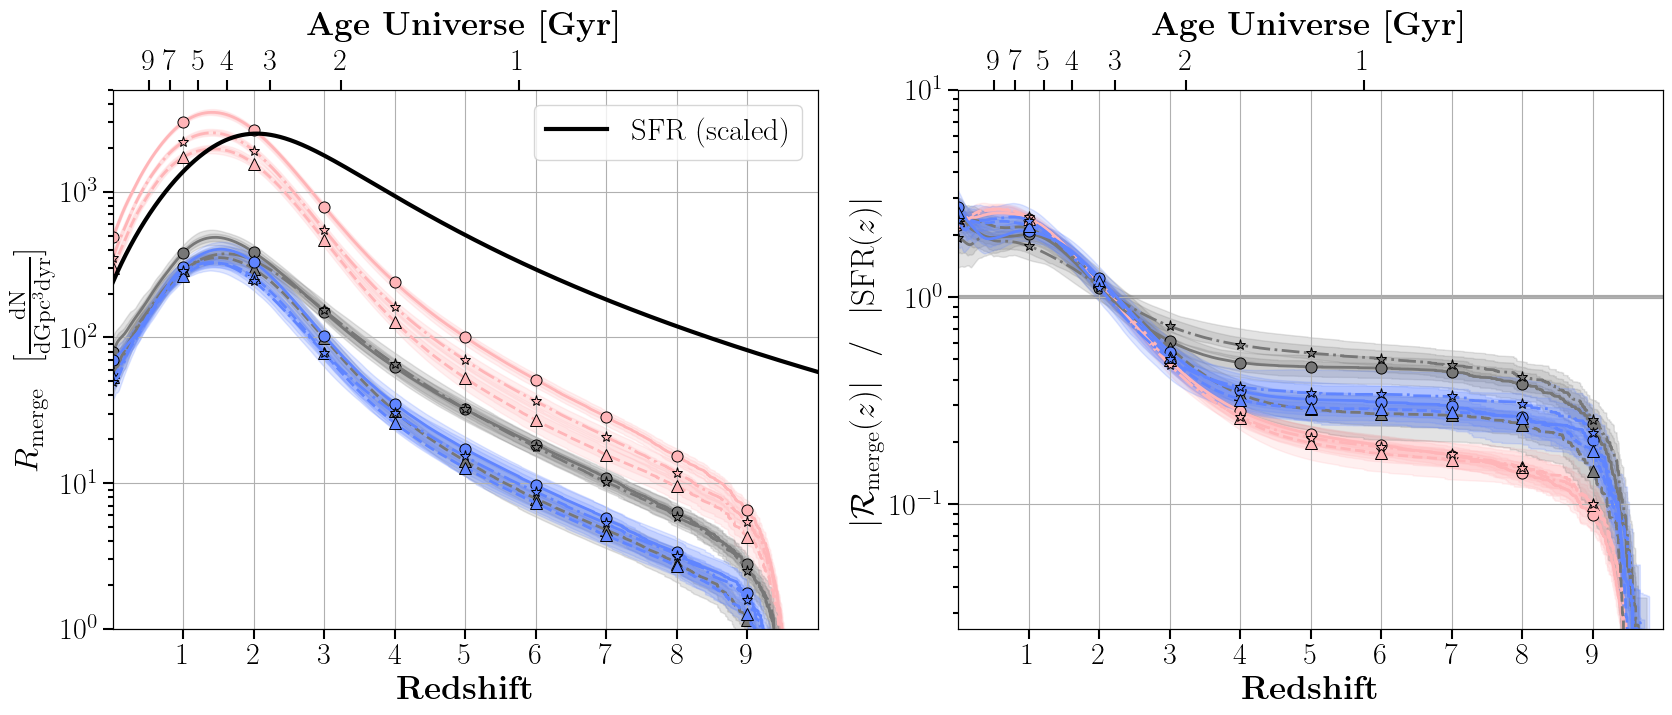

In [99]:
plot_pickled_rates_sfr_norm(condensed_paths, alpha_vals, beta_vals, dco_type='BNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step,
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.7), panel2_range=(10**-1.6, 10), show_legend=False)

## b) BHNS

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


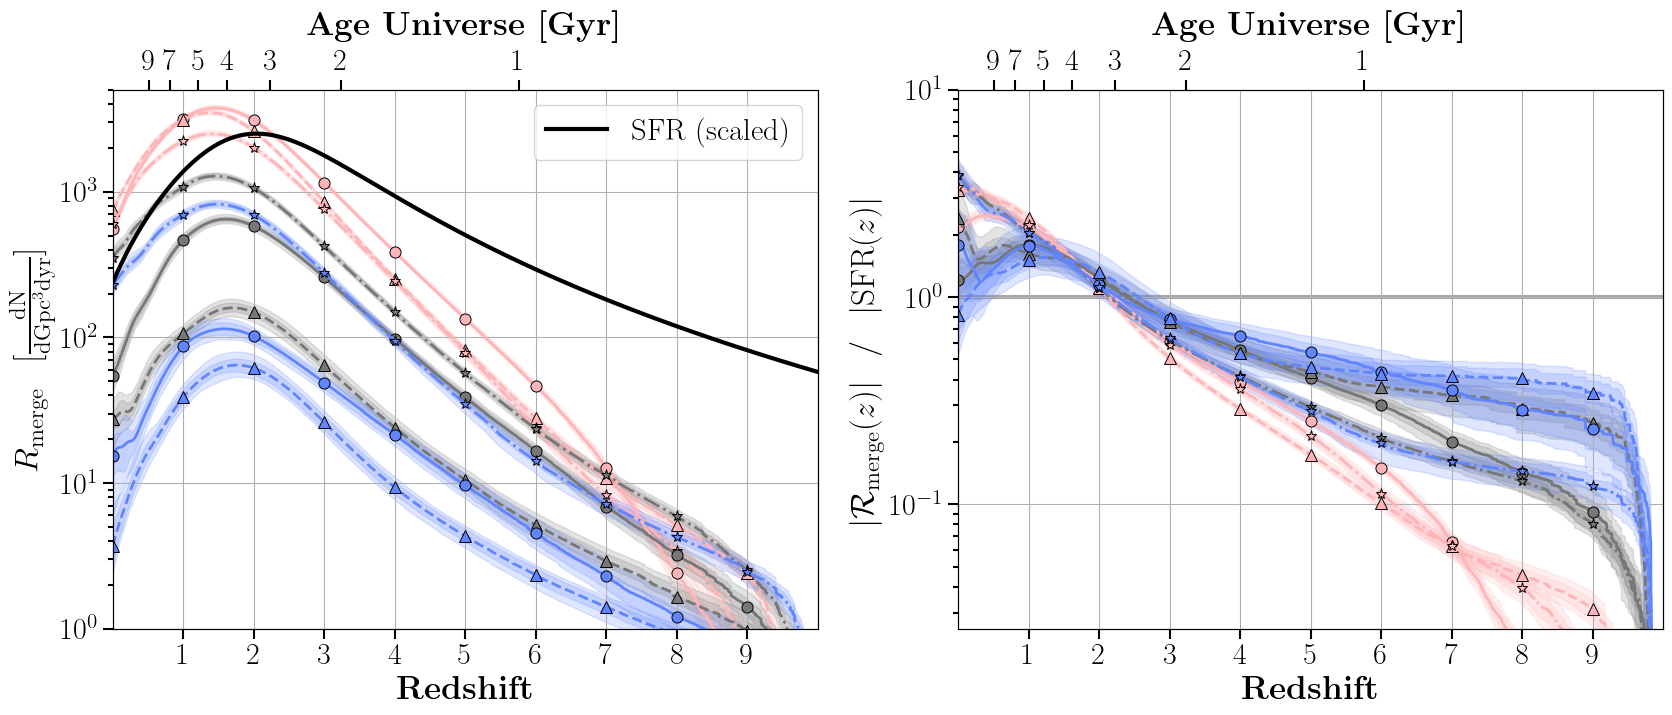

In [100]:
plot_pickled_rates_sfr_norm(condensed_paths, alpha_vals, beta_vals, dco_type='BHNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.7), panel2_range=(10**-1.6, 10), show_legend=False)                              

## c) BBH

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


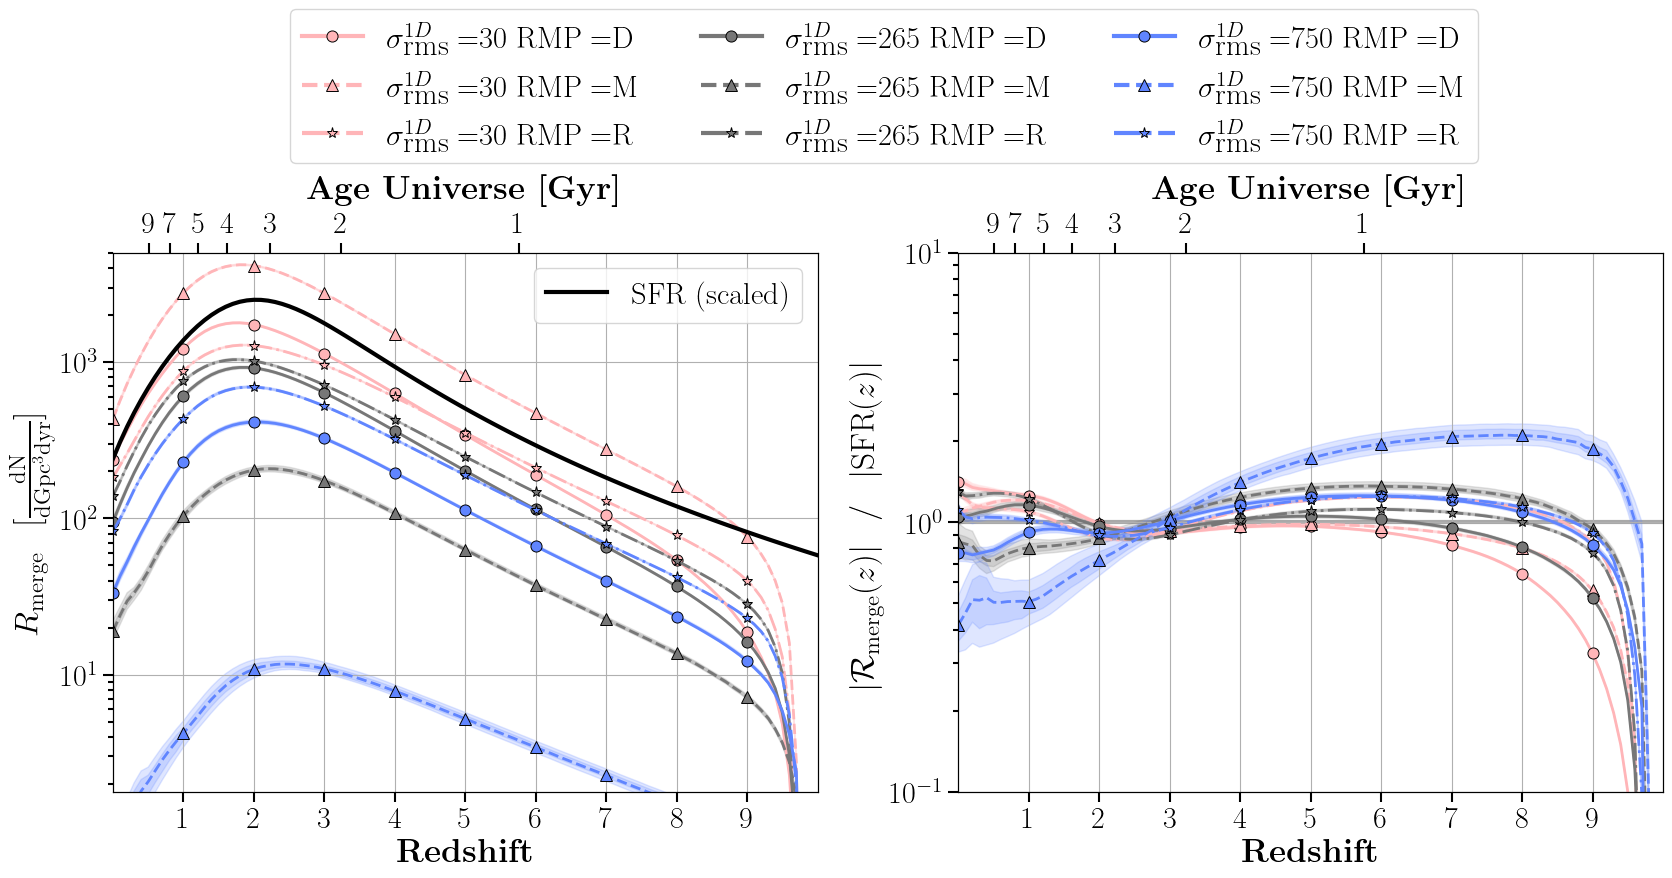

In [101]:
plot_pickled_rates_sfr_norm(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step,
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(10**0.25, 10**3.7), panel2_range=(10**-1, 10), figsize=(20,7), bbox_to_anchor=(0.815, 1.25))

# Fiducial merger rate divided by SFR shifted different amounts

In [27]:
def plot_pickled_rates_delayed_sfr_norm_fiducial(condensed_paths, shifted_redshifts, alpha_val, beta_val, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=2,
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # Make sure the dco_type is given
    assert dco_type != None, 'dco_type must be given'

    CI_kwargs = {'dco_type': dco_type, 'merger_output_filename': merger_output_filename, 'weight_column': weight_column, 'merges_hubble_time': merges_hubble_time, 'pessimistic_CEE': pessimistic_CEE, 
                        'no_RLOF_after_CEE': no_RLOF_after_CEE, 'max_redshift': max_redshift, 'max_redshift_detection': max_redshift_detection, 'redshift_step': redshift_step, 'z_first_SF': z_first_SF,
                        'use_sampled_mass_ranges': use_sampled_mass_ranges, 'm1_min': m1_min, 'm1_max': m1_max, 'm2_min': m2_min, 'fbin': fbin,
                        'aSF': aSF, 'bSF': bSF, 'cSF': cSF, 'dSF': dSF,
                        'mu0': mu0, 'muz': muz, 'sigma0': sigma0, 'sigmaz': sigmaz, 'alpha': alpha, 
                        'min_logZ': min_logZ, 'max_logZ': max_logZ, 'step_logZ': step_logZ,
                        'sensitivity': sensitivity, 'snr_threshold': snr_threshold, 
                        'Mc_max': Mc_max, 'Mc_step': Mc_step, 'eta_max': eta_max, 'eta_step': eta_step,
                        'snr_max': snr_max, 'snr_step': snr_step,
                        'lognormal': lognormal, 'Zprescription': Zprescription, 'SFRprescription': SFRprescription,
                        'GSMFprescription': GSMFprescription, 'ZMprescription': ZMprescription,
                        'logNormalPrescription': logNormalPrescription}

    # 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)

    with open(path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val + '/Pickled_Rates/MSSFR_111/' + dco_type + '/rates_and_bootstraps.h5', 'rb') as f:
        # Get data
        h5_data = h5.File(f)
        total_merger_rates= h5_data['Actual']['total_merger_rates'][...]
        # redshifts[alpha_val][beta_val] = dict['redshfits']
        redshifts = h5_data['Actual']['redshifts'][...]

        # Declare bins for the chirp mass KDE
        COMPAS = ClassCOMPAS.COMPASData(condensed_paths[alpha_val][beta_val], Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
        COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
        COMPAS.setCOMPASData()
        COMPAS.set_sw_weights(weight_column)            

    # # Delete trash object
    # del COMPASs



    ###########################
    #Start plotting

    # set some constants for the plots
    plt.rc('font', family='serif')
    fs = 20
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))

    # Get redshifts to use for the SFR
    sfr_redshifts = redshifts

    # Retreive the SFR
    MSSFR = ClassMSSFR.MSSFR()                              # Create an MSSFR object
    MSSFR.SFRprescription = SFRprescription                 # Set SFR prescription
    ages = MSSFR.cosmology.age(sfr_redshifts).value         # Get the ages
    sfr = MSSFR.returnSFR(sfr_redshifts, ages)              # Get the SFR

    axes[0].plot(redshifts, total_merger_rates, lw=lw, color='k')
    for shift, shifted_z in shifted_redshifts.items():
        shift_mask = sfr_redshifts <= max(shifted_z)
        sfr_interped = np.interp(sfr_redshifts[shift_mask], shifted_z, sfr)
        sfr_area = np.trapz(sfr_interped, x=sfr_redshifts[shift_mask])               # Get the area under the curve
        sfr_interped_normalized = sfr_interped/sfr_area                           # Make it so the area under the curve is 1
        # Plot each of the panels, and their confidence intervals
        # axes[0].plot(redshifts[alpha_val][beta_val], total_merger_rates[alpha_val][beta_val], lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val, color=color_grid[alpha_val][beta_val])
        
        merger_rate_area = np.trapz(total_merger_rates, x=redshifts)
        axes[1].plot(redshifts[shift_mask], (total_merger_rates[shift_mask] / merger_rate_area) / sfr_interped_normalized, lw=lw, label=f'{shift} Myr Delay')
        
        # Plot SFRs
        # Scale SFR differently for each DCO type
        sfr = sfr/max(sfr)
        merger_const = max(total_merger_rates[shift_mask])
        axes[0].plot(shifted_z, sfr * merger_const, lw=3, linestyle='dashed', zorder=-1)
            
    
    # Label axes of all the plots
    axes[0].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[0].set_ylabel(r'\textbf{Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$}', fontsize=fs)
    axes[0].set_yscale('log')

    axes[1].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[1].set_ylabel(r'\textbf{$|\mathcal{R}_{\rm{merge}}(z)|  \ \  /  \ \  |\textrm{\textnormal{SFR}}(z)|$}', fontsize=fs)
    axes[1].set_yscale('log')

    # Set lower bounds for the plots
    if panel1_range:
        axes[0].set_ylim(panel1_range)
    if panel2_range:
        axes[1].set_ylim(panel2_range)

    for ax in axes.flatten():
            ax.tick_params(labelsize=0.9*fs)
    
    

    # Plot horizontal line for SFR on the normalized plots
    axes[1].axhline(y=1, color='darkgray', lw=3, zorder=-1)

    for ax in axes.flatten():
        ax.tick_params(labelsize=0.9*fs)

    # Include legend
    leg = fig.legend(fontsize=22, ncol=5, bbox_to_anchor=(0.9, 0.97),  markerscale=25) 
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)

    # Show the plot!
    plt.show()

In [53]:
with open(path_to_data + 'output_alpha_CE_0.1_beta_0.5/Pickled_Rates/MSSFR_111/BBH/rates_and_bootstraps.h5', 'rb') as f:
    # Get data
    h5_data = h5.File(f)

    # Get redshifts to use for the SFR
    sfr_redshifts = h5_data['Actual']['redshifts'][...]

ages_yrs = cosmology.age(sfr_redshifts).to(u.Myr).value

ages_yrs_250 = ages_yrs * u.Myr + 250 * u.Myr
z_shifted_250 = z_at_value(cosmology.age, ages_yrs_250, zmin=-1)

ages_yrs_500 = ages_yrs * u.Myr + 500 * u.Myr
z_shifted_500 = z_at_value(cosmology.age, ages_yrs_500, zmin=-1)

ages_yrs_750 = ages_yrs * u.Myr + 750 * u.Myr
z_shifted_750 = z_at_value(cosmology.age, ages_yrs_750, zmin=-1)

ages_yrs_1000 = ages_yrs * u.Myr + 1000 * u.Myr
z_shifted_1000 = z_at_value(cosmology.age, ages_yrs_1000, zmin=-1)

shifted_zs = {'0': sfr_redshifts, '250': z_shifted_250, '500': z_shifted_500, '750': z_shifted_750, '1000': z_shifted_1000}

/Users/adamboesky/opt/anaconda3/envs/PRISE/lib/python3.9/site-packages/astropy/cosmology/flrw/base.py:1057: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return quad(self._lookback_time_integrand_scalar, z, inf)[0]


ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


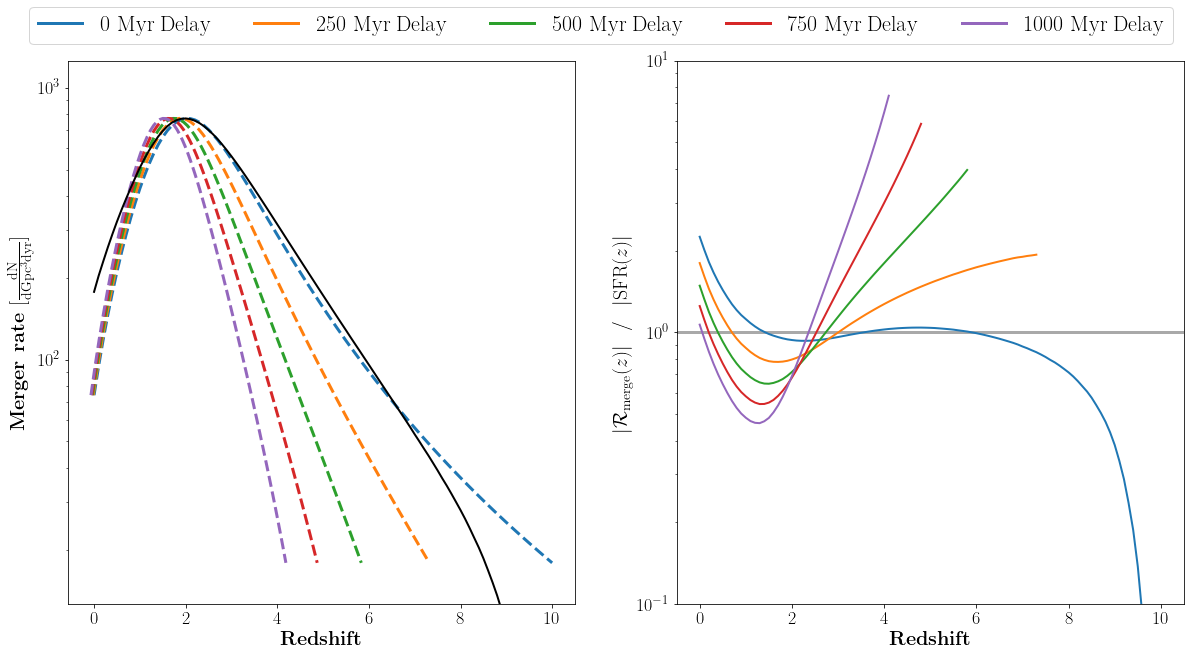

In [66]:
plot_pickled_rates_delayed_sfr_norm_fiducial(condensed_paths, shifted_zs, '2.0', '0.5', dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,
            panel1_range=(10**1.1, 10**3.1), panel2_range=(10**-1, 10))                               

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


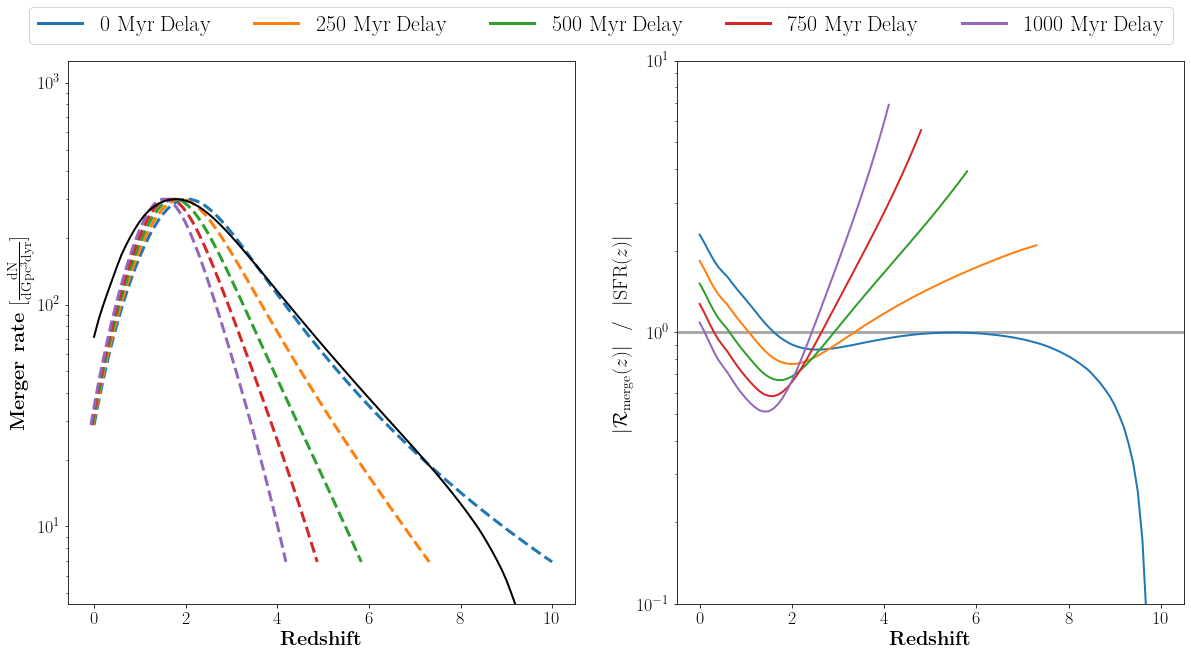

In [67]:
plot_pickled_rates_delayed_sfr_norm_fiducial(condensed_paths, shifted_zs, '0.1', '0.25', dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,
            panel1_range=(10**0.65, 10**3.1), panel2_range=(10**-1, 10))                               

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


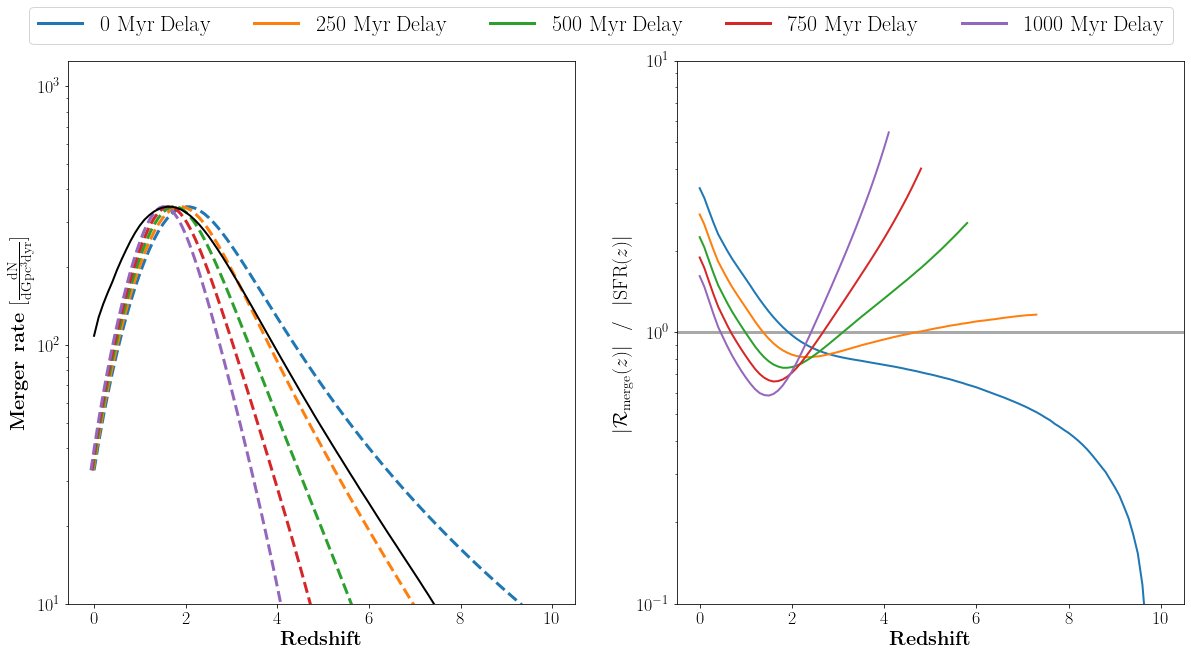

In [68]:
plot_pickled_rates_delayed_sfr_norm_fiducial(condensed_paths, shifted_zs, '10.0', '0.5', dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,
            panel1_range=(10**1, 10**3.1), panel2_range=(10**-1, 10))                               

## Function used to retrieve and plot the formation rates

In [91]:
def plot_pickled_frates_sfr_norm(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=2, show_legend=True, figsize=(20, 7), bbox_to_anchor=(0.9, 1.25),
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # Make sure the dco_type is given
    assert dco_type != None, 'dco_type must be given'

    CI_kwargs = {'dco_type': dco_type, 'merger_output_filename': merger_output_filename, 'weight_column': weight_column, 'merges_hubble_time': merges_hubble_time, 'pessimistic_CEE': pessimistic_CEE, 
                        'no_RLOF_after_CEE': no_RLOF_after_CEE, 'max_redshift': max_redshift, 'max_redshift_detection': max_redshift_detection, 'redshift_step': redshift_step, 'z_first_SF': z_first_SF,
                        'use_sampled_mass_ranges': use_sampled_mass_ranges, 'm1_min': m1_min, 'm1_max': m1_max, 'm2_min': m2_min, 'fbin': fbin,
                        'aSF': aSF, 'bSF': bSF, 'cSF': cSF, 'dSF': dSF,
                        'mu0': mu0, 'muz': muz, 'sigma0': sigma0, 'sigmaz': sigmaz, 'alpha': alpha, 
                        'min_logZ': min_logZ, 'max_logZ': max_logZ, 'step_logZ': step_logZ,
                        'sensitivity': sensitivity, 'snr_threshold': snr_threshold, 
                        'Mc_max': Mc_max, 'Mc_step': Mc_step, 'eta_max': eta_max, 'eta_step': eta_step,
                        'snr_max': snr_max, 'snr_step': snr_step,
                        'lognormal': lognormal, 'Zprescription': Zprescription, 'SFRprescription': SFRprescription,
                        'GSMFprescription': GSMFprescription, 'ZMprescription': ZMprescription,
                        'logNormalPrescription': logNormalPrescription}

    # 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)
    total_formation_rates = {}
    total_detection_rates = {}
    cumulative_detection_rates = {}
    detection_rates_by_binary = {}
    mass_kde_scaled = {}
    redshifts = {}
    Mc_bins = {}
    one_sigma = {}
    two_sigma = {}

    for alpha_index, alpha_val in enumerate(alpha_vals):
        # Make the dictionary "2D"
        total_formation_rates[alpha_val] = {}
        total_detection_rates[alpha_val] = {}
        cumulative_detection_rates[alpha_val] = {}
        detection_rates_by_binary[alpha_val] = {}
        mass_kde_scaled[alpha_val] = {}
        Mc_bins[alpha_val] = {}
        one_sigma[alpha_val] = {}
        two_sigma[alpha_val] = {}

        redshifts[alpha_val] = {}

        for beta_index, beta_val in enumerate(beta_vals):
            one_sigma[alpha_val][beta_val] = {}
            two_sigma[alpha_val][beta_val] = {}
        
            with open(path_to_data+'output_sigma_'+alpha_val+'_remnant_prescription_'+beta_val+'/Pickled_Rates/MSSFR_111/'+dco_type+'/rates_and_bootstraps.h5', 'rb') as f:
                # Get data
                h5_data = h5.File(f)
                total_formation_rates[alpha_val][beta_val] = h5_data['Actual']['total_formation_rates'][...]
                # redshifts[alpha_val][beta_val] = dict['redshfits']
                redshifts[alpha_val][beta_val] = h5_data['Actual']['redshifts'][...]
                cumulative_detection_rates[alpha_val][beta_val] = h5_data['Actual']['cumulative_detection_rates'][...]
                mass_kde_scaled[alpha_val][beta_val] = h5_data['Actual']['mass_kde_scaled'][...]

                # Declare bins for the chirp mass KDE
                COMPAS = ClassCOMPAS.COMPASData(condensed_paths[alpha_val][beta_val], Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
                COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
                COMPAS.setCOMPASData()
                COMPAS.set_sw_weights(weight_column)            
                chirp_masses = (COMPAS.mass1*COMPAS.mass2)**(3./5.) / (COMPAS.mass1 + COMPAS.mass2)**(1./5.)
                Mc_bins[alpha_val][beta_val] = np.arange(0, max(chirp_masses)*1.3, max(chirp_masses)*1.2/100) # We need to pass in the bins for the chirp mass distribution so we will declare them here

                # empty trash
                del chirp_masses
                del COMPAS

                # Calculate confidence intervals
                one_sigma[alpha_val][beta_val]['total_formation_rates']          =   np.percentile(h5_data['Bootstraps']['total_formation_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['cumulative_detection_rates']     =   np.percentile(h5_data['Bootstraps']['cumulative_detection_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [16, 84], axis=0)

                # Get the two sigma confidence intervals
                two_sigma[alpha_val][beta_val]['total_formation_rates']          =   np.percentile(h5_data['Bootstraps']['total_formation_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['cumulative_detection_rates']     =   np.percentile(h5_data['Bootstraps']['cumulative_detection_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [2.5, 97.5], axis=0)

            # # Delete trash object
            # del COMPASs



    ###########################
    #Start plotting

    # set some constants for the plots
    plt.rc('font', family='serif')
    fs = 24
    tickLengthMajor = 7
    tickLengthMinor = 3.5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Get redshifts to use for the SFR
    sfr_redshifts = redshifts['30']['D']

    # Retreive the SFR
    MSSFR = ClassMSSFR.MSSFR()                              # Create an MSSFR object
    MSSFR.SFRprescription = SFRprescription                 # Set SFR prescription
    ages = MSSFR.cosmology.age(sfr_redshifts).value         # Get the ages
    sfr = MSSFR.returnSFR(sfr_redshifts, ages)              # Get the SFR
    sfr_area = np.trapz(sfr, x=sfr_redshifts)               # Get the area under the curve
    sfr_normalized = sfr/sfr_area                           # Make it so the area under the curve is 1
    if dco_type == 'BBH':
        marker_period = 10
    else:
        marker_period = 1000

    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            # Plot each of the panels, and their confidence intervals
            axes[0].plot(redshifts[alpha_val][beta_val], total_formation_rates[alpha_val][beta_val], lw=lw, label=r'$\sigma_{\textrm{rms}}^{1D} = $' + alpha_val + r'$\textrm{ RMP} = $' + beta_val, color=color_grid[alpha_val][beta_val], marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)
            axes[0].fill_between(x=redshifts[alpha_val][beta_val], y1=one_sigma[alpha_val][beta_val]['total_formation_rates'][0], y2=one_sigma[alpha_val][beta_val]['total_formation_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[0].fill_between(x=redshifts[alpha_val][beta_val], y1=two_sigma[alpha_val][beta_val]['total_formation_rates'][0], y2=two_sigma[alpha_val][beta_val]['total_formation_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])

            merger_rate_area = np.trapz(total_formation_rates[alpha_val][beta_val], x=redshifts[alpha_val][beta_val])
            axes[1].plot(redshifts[alpha_val][beta_val], (total_formation_rates[alpha_val][beta_val] / merger_rate_area) / sfr_normalized, lw=lw, color=color_grid[alpha_val][beta_val], marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)
            axes[1].fill_between(x=redshifts[alpha_val][beta_val], y1=(one_sigma[alpha_val][beta_val]['total_formation_rates'][0] / merger_rate_area) / sfr_normalized, y2=(one_sigma[alpha_val][beta_val]['total_formation_rates'][1] / merger_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[1].fill_between(x=redshifts[alpha_val][beta_val], y1=(two_sigma[alpha_val][beta_val]['total_formation_rates'][0] / merger_rate_area) / sfr_normalized, y2=(two_sigma[alpha_val][beta_val]['total_formation_rates'][1] / merger_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])

    
    # Label axes of all the plots
    axes[0].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[0].set_ylabel(r'\textbf{$R_{\rm{form}} \ \ [\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$}', fontsize=fs)
    axes[0].set_yscale('log')

    axes[1].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[1].set_ylabel(r'\textbf{$|\mathcal{R}_{\rm{form}}(z)|  \ \  /  \ \  |\textrm{\textnormal{SFR}}(z)|$}', fontsize=fs)
    axes[1].set_yscale('log')

    # Set lower bounds for the plots
    if panel1_range:
        axes[0].set_ylim(panel1_range)
    if panel2_range:
        axes[1].set_ylim(panel2_range)

    for ax in axes.flatten():
        ax.tick_params(labelsize=fs*0.9)
        ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
        ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    
    redshift_ticks = np.arange(1, 10, 1)
    axes[0].xaxis.set_ticks(redshift_ticks)
    axes[1].xaxis.set_ticks(redshift_ticks)
    
    axes[0].set_xlim((0,10))
    axes[1].set_xlim((0,10))
    
    # Scale SFR differently for each DCO type
    sfr = sfr/max(sfr)
    merger_const = axes[0].get_ylim()[1] * 0.5

    # Plot SFRs
    sfr_line = axes[0].plot(sfr_redshifts, sfr * merger_const, color='black', lw=3)
    legend2 = axes[0].legend(sfr_line, ["SFR (scaled)"], fontsize=22, loc='upper right')

    # Plot horizontal line for SFR on the normalized plots
    axes[1].axhline(y=1, color='darkgray', lw=3, zorder=-1)

    for ax in axes.flatten():
        ax.tick_params(labelsize=fs*0.9)

    # Include legend
    if show_legend:
        leg = fig.legend(fontsize=22, ncol=4, bbox_to_anchor=bbox_to_anchor,  markerscale=1) 
        for legobj in leg.legendHandles:
            legobj.set_linewidth(3.0)

    # Add lookback time axis
    ax_top1 = add_lookback_t_axes(axes[0], labelsize=fs)
    ax_top2 = add_lookback_t_axes(axes[1], labelsize=fs)
    for ax_top in (ax_top1, ax_top2):
        ax_top.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
        ax_top.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')

    axes[0].grid()
    axes[1].grid()

    # Show the plot!
    plt.show()

## a) BNS

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


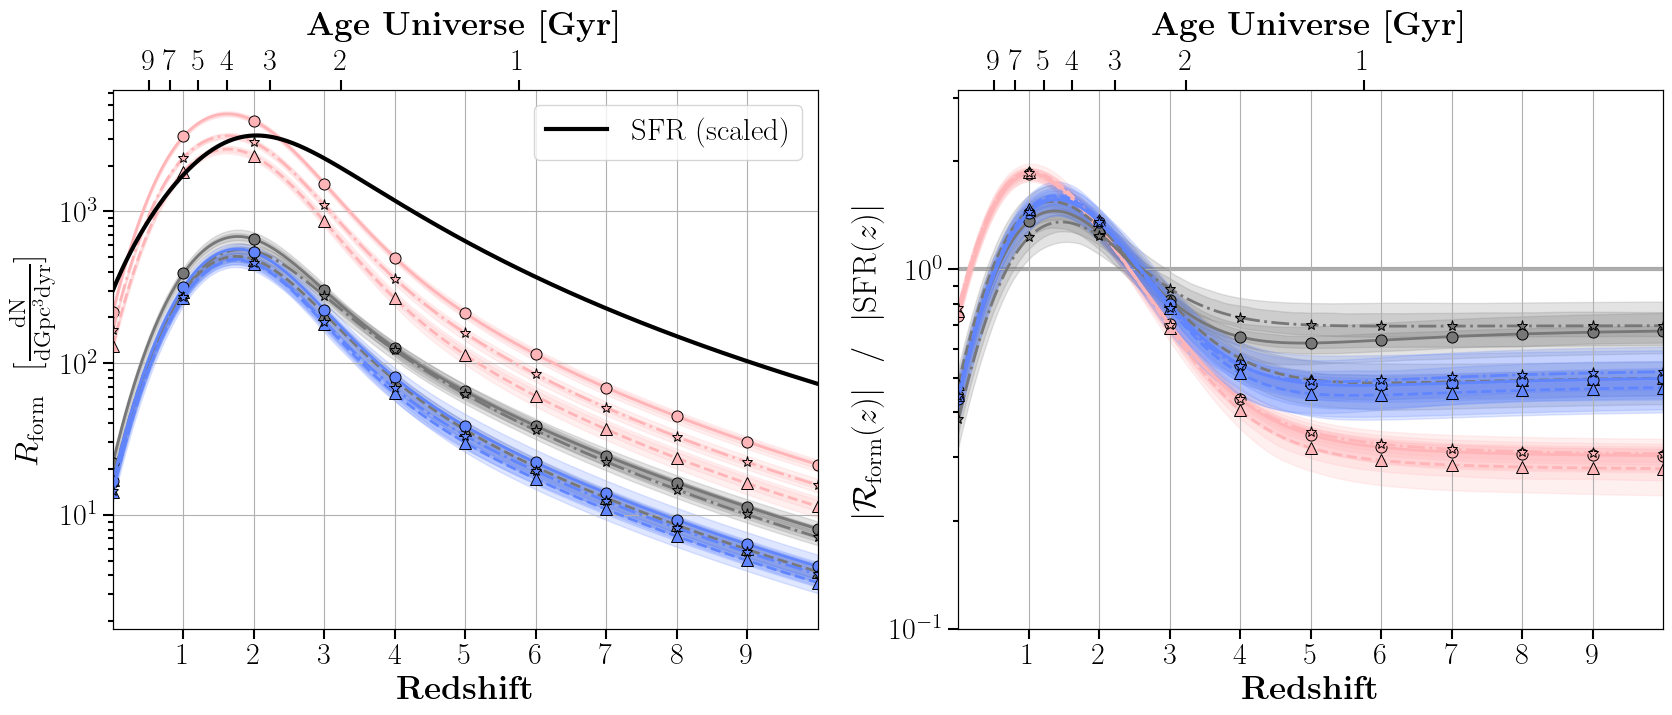

In [102]:
plot_pickled_frates_sfr_norm(condensed_paths, alpha_vals, beta_vals, dco_type='BNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(10**0.25, 10**3.8), panel2_range=(10**-1, 10**0.5), show_legend=False, figsize=(20,7), bbox_to_anchor=(0.9, 1.25))                               

## b) BHNS

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


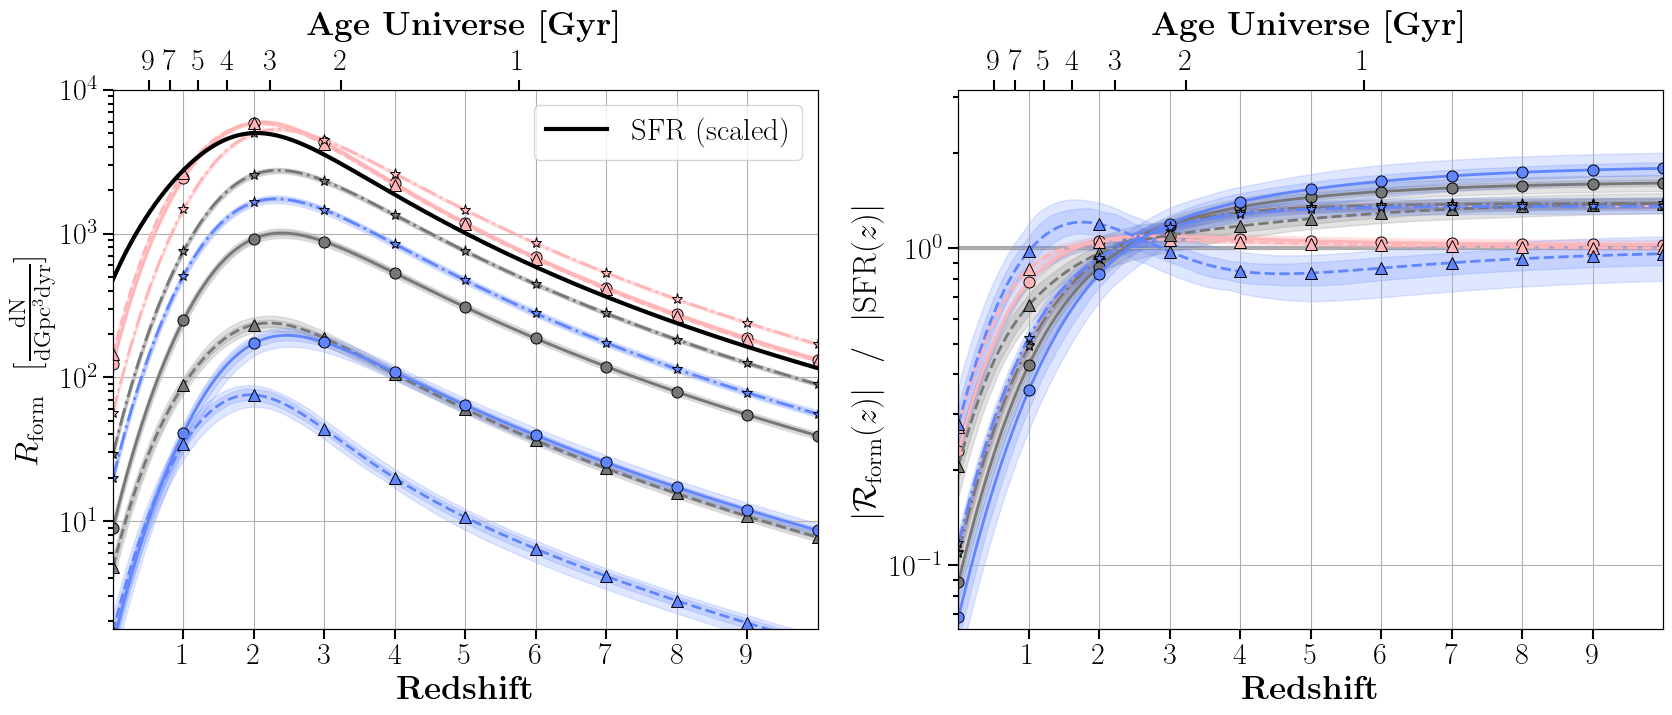

In [103]:
plot_pickled_frates_sfr_norm(condensed_paths, alpha_vals, beta_vals, dco_type='BHNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(10**0.25, 10**4), panel2_range=(10**-1.2, 10**0.5), show_legend=False, figsize=(20,7), bbox_to_anchor=(0.9, 1.25))                               

## c) BBH

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


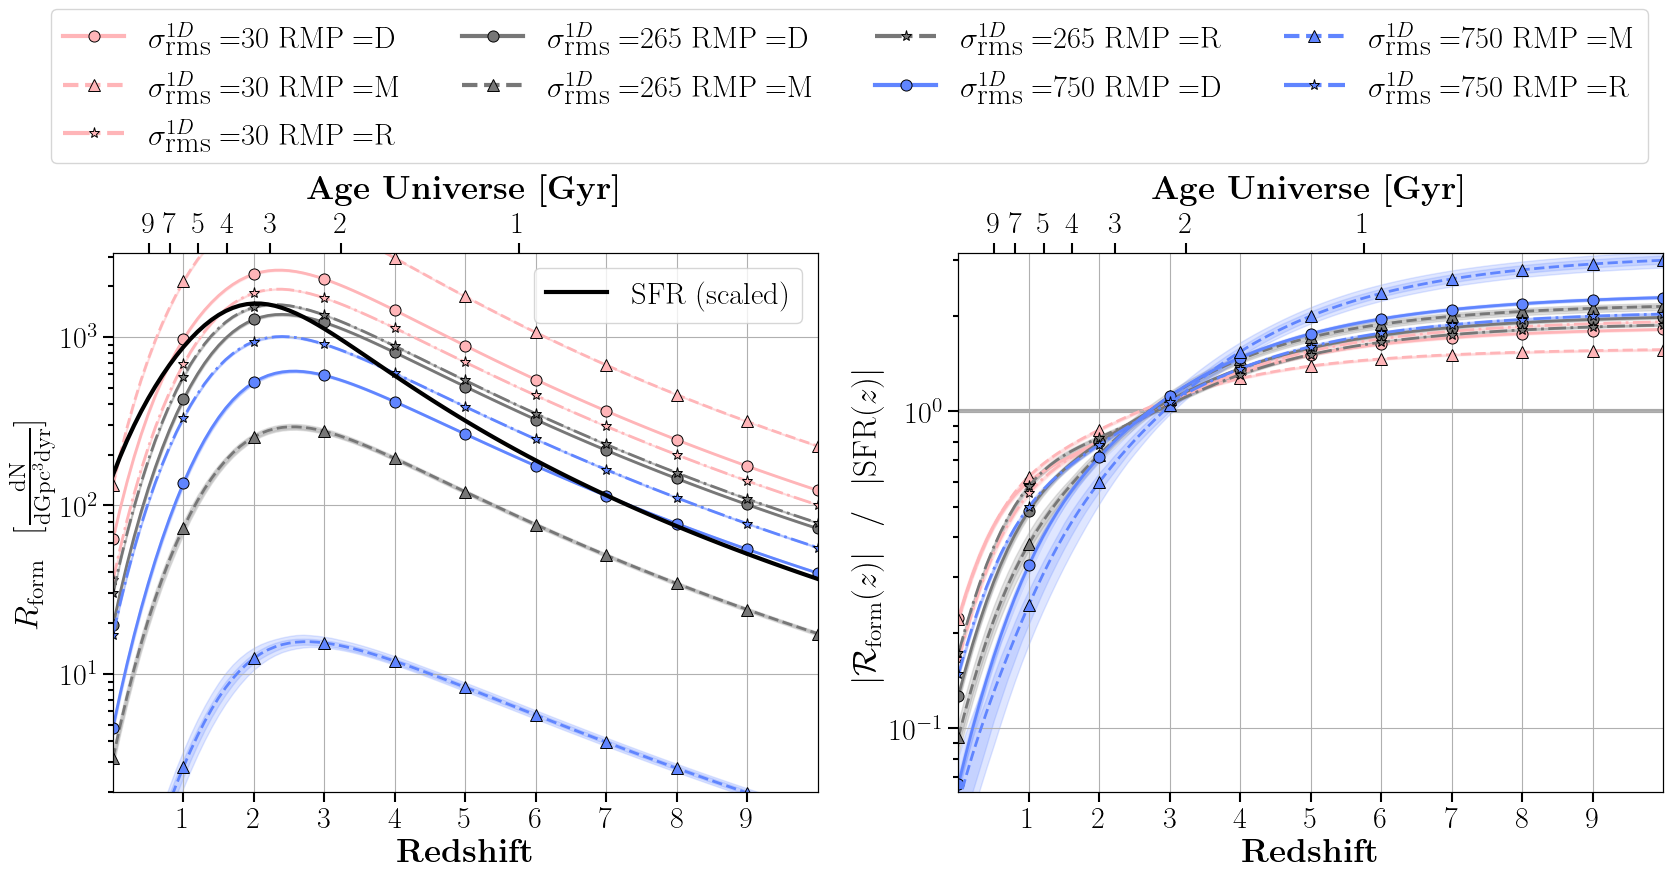

In [104]:
plot_pickled_frates_sfr_norm(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(10**0.3, 10**3.5), panel2_range=(10**-1.2, 10**0.5), figsize=(20,7), bbox_to_anchor=(0.9, 1.25))                              

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


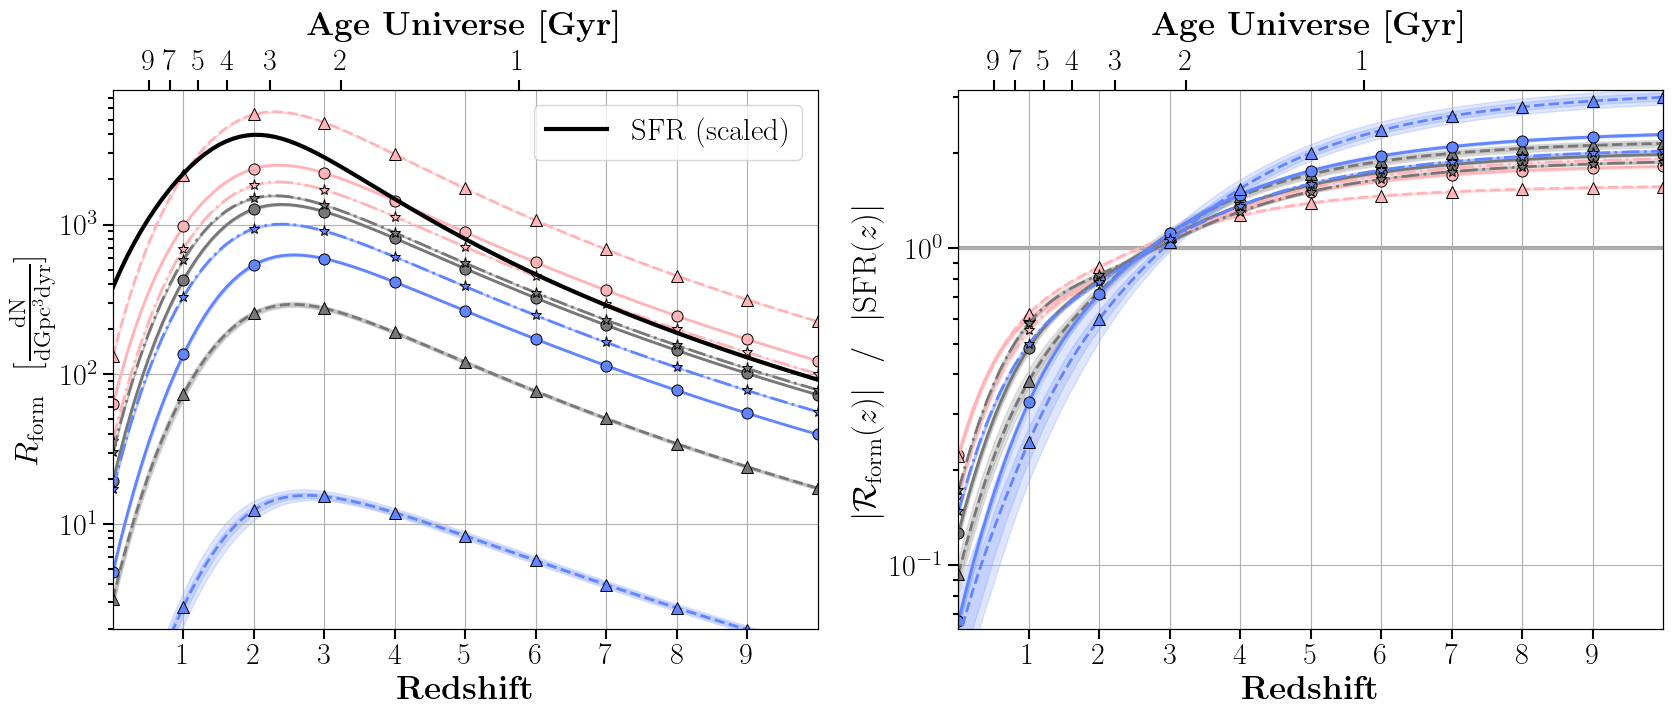

In [105]:
plot_pickled_frates_sfr_norm(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(10**0.3, 10**3.9), panel2_range=(10**-1.2, 10**0.5), show_legend=False, figsize=(20,7), bbox_to_anchor=(0.9, 1.25))

# Double broken power law best fit parameters plots

Function to make and fit a double broken powerlaw

In [ ]:
def dbl_brkn_pow_law(redshifts, kappa0, kappa1, kappa2, break_index, max_index, R0):
    
    # Data broken up
    broken_redshifts = [redshifts[:break_index], redshifts[break_index:max_index], redshifts[max_index:]]

    # Calculate the rate
    rate0 = R0 * (1+broken_redshifts[0]) ** kappa0
    rate1 = (1+broken_redshifts[1]) ** kappa1
    rate2 = (1+broken_redshifts[2]) ** kappa2
    # rate = np.concatenate((rate, R0 * (1+broken_redshifts[0][-1])**(kappa0-kappa1) * (1+broken_redshifts[1]) ** kappa1))
    # rate = np.concatenate((rate, R0 * (1+broken_redshifts[0][-1])**(kappa0-kappa1) * (1+broken_redshifts[1][-1])**(kappa1-kappa2) * (1+broken_redshifts[2]) ** kappa2))
    rate = np.concatenate((rate0, rate1 * np.abs(rate0[-1] / rate1[0])))
    rate = np.concatenate((rate, rate2 * np.abs(rate[-1] / rate2[0])))

    return rate


def dbl_get_kappa_and_peak(redshifts, rate):

    # Get the index of the maximum rate
    max_index = np.argmax(rate)

    # Get the peak redshift
    peak_z = redshifts[max_index]

    # Get intrinsic rate
    R0 = rate[0]

    # Index of the first break
    break_index=int(max_index / 2)
    
    # Fit the data
    kappas, params_cov = curve_fit(lambda zs, kappa0, kappa1, kappa2: dbl_brkn_pow_law(zs, kappa0, kappa1, kappa2, break_index, max_index, R0), redshifts, rate)


    return kappas, peak_z

Function to plot the double broken power law best fit parameters

In [ ]:
def plot_rates_kappa_and_peaks(alpha_vals, beta_vals, color_grid, dco_type=None, lw=3, fs=24):
        
        assert dco_type != None, 'dco_type must be given'

        # Dictionaries to retrieve the data:
        total_formation_rates = {}
        total_merger_rates = {}
        one_sigma = {}
        two_sigma = {}
        formation_rate_kappa0 = {}
        formation_rate_kappa1 = {}
        formation_rate_kappa2 = {}
        merger_rate_kappa0 = {}
        merger_rate_kappa1 = {}
        merger_rate_kappa2 = {}
        formation_rate_peak_zs = {}
        merger_rate_peak_zs = {}
        redshifts = {}
        intrinsic_formation_rate = {}
        intrinsic_merger_rate = {}

        ######################################################################
        # Retrieve the data
        index = 0
        for alpha_val in alpha_vals:
                # Make the dictionary "2D"
                total_formation_rates[alpha_val] = {}
                total_merger_rates[alpha_val] = {}
                one_sigma[alpha_val] = {}
                two_sigma[alpha_val] = {}
                formation_rate_kappa0[alpha_val] = {}
                formation_rate_kappa1[alpha_val] = {}
                formation_rate_kappa2[alpha_val] = {}
                merger_rate_kappa0[alpha_val] = {}
                merger_rate_kappa1[alpha_val] = {}
                merger_rate_kappa2[alpha_val] = {}
                formation_rate_peak_zs[alpha_val] = {}
                merger_rate_peak_zs[alpha_val] = {}
                redshifts[alpha_val] = {}         
                intrinsic_formation_rate[alpha_val] = {}
                intrinsic_merger_rate[alpha_val] = {}

                for beta_val in beta_vals:
                        one_sigma[alpha_val][beta_val] = {}
                        two_sigma[alpha_val][beta_val] = {}
                        with open(path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val + '/Pickled_Rates/MSSFR_111/' + dco_type + '/rates_and_bootstraps.h5', 'rb') as f:
                                
                                # Get data
                                h5_data = h5.File(f)
                                total_formation_rates[alpha_val][beta_val] = h5_data['Actual']['total_formation_rates'][...]
                                total_merger_rates[alpha_val][beta_val] = h5_data['Actual']['total_merger_rates'][...]
                                redshifts[alpha_val][beta_val] = h5_data['Actual']['redshifts'][...]

                                # GET RATE KAPPAS, Z_PEAK, AND R0                                
                                # Get the intrinsic rates
                                intrinsic_formation_rate[alpha_val][beta_val] = total_formation_rates[alpha_val][beta_val][0]
                                intrinsic_merger_rate[alpha_val][beta_val] = total_merger_rates[alpha_val][beta_val][0]

                                # Get kappas
                                # Formation rates
                                formation_rate_kappas, formation_rate_peak_z = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val],  total_formation_rates[alpha_val][beta_val]/max(total_formation_rates[alpha_val][beta_val]))
                                formation_rate_peak_zs[alpha_val][beta_val] = formation_rate_peak_z
                                formation_rate_kappa0[alpha_val][beta_val] = formation_rate_kappas[0]
                                formation_rate_kappa1[alpha_val][beta_val] = formation_rate_kappas[1]
                                formation_rate_kappa2[alpha_val][beta_val] = formation_rate_kappas[2]
                                # Merger rates
                                merger_rate_kappas, merger_rate_peak_z = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val],  total_merger_rates[alpha_val][beta_val]/max(total_merger_rates[alpha_val][beta_val]))
                                merger_rate_peak_zs[alpha_val][beta_val] = merger_rate_peak_z
                                merger_rate_kappa0[alpha_val][beta_val] = merger_rate_kappas[0]
                                merger_rate_kappa1[alpha_val][beta_val] = merger_rate_kappas[1]
                                merger_rate_kappa2[alpha_val][beta_val] = merger_rate_kappas[2]


                                # CONFIDENCE INTERVALS!
                                # Iterate through all the bootstrapped rates and calculate the kappa values for the rates
                                formation_rate_kappa0s = []
                                formation_rate_kappa1s = []
                                formation_rate_kappa2s = []
                                formation_rate_peaks = []
                                merger_rate_kappa0s = []
                                merger_rate_kappa1s = []
                                merger_rate_kappa2s = []
                                merger_rate_peaks = []
                                intrinsic_formation_rates = []
                                intrinsic_merger_rates = []
                                for rate_index in range(len(h5_data['Bootstraps']['total_formation_rates'][...])):
                                        
                                        # Get the akppa for the current bootstrap iteration
                                        if np.argmax(h5_data['Bootstraps']['total_formation_rates'][...][rate_index]) != 0 and np.argmax(h5_data['Bootstraps']['total_merger_rates'][...][rate_index]) != 0: # We will not count the bootstrapped rate if the rate's max is at z=0
                                                # Get the kappas and peaks
                                                formation_rate_kappas_bs, formation_rate_peak = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val], h5_data['Bootstraps']['total_formation_rates'][...][rate_index]/max(h5_data['Bootstraps']['total_formation_rates'][...][rate_index]))
                                                merger_rate_kappas_bs, merger_rate_peak = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val], h5_data['Bootstraps']['total_merger_rates'][...][rate_index]/max(h5_data['Bootstraps']['total_merger_rates'][...][rate_index]))

                                                # Store the kappas
                                                formation_rate_kappa0s.append(formation_rate_kappas_bs[0])
                                                formation_rate_kappa1s.append(formation_rate_kappas_bs[1])
                                                formation_rate_kappa2s.append(formation_rate_kappas_bs[2])
                                                merger_rate_kappa0s.append(merger_rate_kappas_bs[0])
                                                merger_rate_kappa1s.append(merger_rate_kappas_bs[1])
                                                merger_rate_kappa2s.append(merger_rate_kappas_bs[2])

                                                # Store the peaks
                                                formation_rate_peaks.append(formation_rate_peak)
                                                merger_rate_peaks.append(merger_rate_peak)

                                                # Get the intrinsic rates
                                                intrinsic_formation_rates.append(h5_data['Bootstraps']['total_formation_rates'][...][rate_index][0])
                                                intrinsic_merger_rates.append(h5_data['Bootstraps']['total_merger_rates'][...][rate_index][0])


                                # Get and store the confidence intervals for the kappas
                                # Formation rates
                                one_sigma[alpha_val][beta_val]['formation_rate_kappa0']         = np.percentile(formation_rate_kappa0s, [16, 84])
                                one_sigma[alpha_val][beta_val]['formation_rate_kappa1']         = np.percentile(formation_rate_kappa1s, [16, 84])
                                one_sigma[alpha_val][beta_val]['formation_rate_kappa2']         = np.percentile(formation_rate_kappa2s, [16, 84])
                                one_sigma[alpha_val][beta_val]['formation_rate_peak_z']         = np.percentile(formation_rate_peaks, [16, 84])
                                one_sigma[alpha_val][beta_val]['intrinsic_formation_rate']      = np.percentile(intrinsic_formation_rates, [16, 84])
                                two_sigma[alpha_val][beta_val]['formation_rate_kappa0']         = np.percentile(formation_rate_kappa0s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['formation_rate_kappa1']         = np.percentile(formation_rate_kappa1s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['formation_rate_kappa2']         = np.percentile(formation_rate_kappa2s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['formation_rate_peak_z']         = np.percentile(formation_rate_peaks, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['intrinsic_formation_rate']      = np.percentile(intrinsic_formation_rates, [2.5, 97.5])
                                # Merger rates
                                one_sigma[alpha_val][beta_val]['merger_rate_kappa0']            = np.percentile(merger_rate_kappa0s, [16, 84])
                                one_sigma[alpha_val][beta_val]['merger_rate_kappa1']            = np.percentile(merger_rate_kappa1s, [16, 84])
                                one_sigma[alpha_val][beta_val]['merger_rate_kappa2']            = np.percentile(merger_rate_kappa2s, [16, 84])
                                one_sigma[alpha_val][beta_val]['merger_rate_peak_z']            = np.percentile(merger_rate_peaks, [16, 84])
                                one_sigma[alpha_val][beta_val]['intrinsic_merger_rate']         = np.percentile(intrinsic_merger_rates, [16, 84])
                                two_sigma[alpha_val][beta_val]['merger_rate_kappa0']            = np.percentile(merger_rate_kappa0s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['merger_rate_kappa1']            = np.percentile(merger_rate_kappa1s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['merger_rate_kappa2']            = np.percentile(merger_rate_kappa2s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['merger_rate_peak_z']            = np.percentile(merger_rate_peaks, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['intrinsic_merger_rate']         = np.percentile(intrinsic_merger_rates, [2.5, 97.5])


                                        
        # ######################################################################
        # # Plot the formation rate kappas and z_peak
        # formation_fig, formation_axes = plt.subplots(1, 5, figsize=(24, 13))

        # # Make grid in background
        # formation_axes[0].grid(alpha=0.5, zorder=-1)
        # formation_axes[1].grid(alpha=0.5, zorder=-1)
        # formation_axes[2].grid(alpha=0.5, zorder=-1)
        # formation_axes[3].grid(alpha=0.5, zorder=-1)
        # formation_axes[4].grid(alpha=0.5, zorder=-1)

        # Retreive the SFR
        MSSFR = ClassMSSFR.MSSFR()                                                      # Create an MSSFR object
        MSSFR.SFRprescription = SFRprescription                                         # Set SFR prescription
        ages = MSSFR.cosmology.age(redshifts[alpha_val][beta_val]).value                # Get the ages
        sfr = MSSFR.returnSFR(redshifts[alpha_val][beta_val], ages)                     # Get the SFR

        sfr_kappas, sfr_peak_redshift = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val], sfr/max(sfr))
        intrinsic_sfr = sfr[0]
        sfr_kappa0 = sfr_kappas[0]
        sfr_kappa1 = sfr_kappas[1]
        sfr_kappa2 = sfr_kappas[2]


        index = 0
        dy = 0.8
        dylen = (2*dy)/(len(alpha_vals)*len(beta_vals))
        labels = []
        label_indexs = []
        # for alpha_val in alpha_vals:
        #         for beta_val in beta_vals:

        #                 # Plot the intrinsic rate
        #                 formation_axes[0].scatter(x=intrinsic_formation_rate[alpha_val][beta_val], y=index, s=100, color=color_grid[alpha_val][beta_val], alpha=1, zorder=100)                                          # Point at estimated value
        #                 width = one_sigma[alpha_val][beta_val]['intrinsic_formation_rate'][1] - one_sigma[alpha_val][beta_val]['intrinsic_formation_rate'][0]                                                           # Get the width of the 1sigma error bar
        #                 formation_axes[0].barh(index, width=width, left=one_sigma[alpha_val][beta_val]['intrinsic_formation_rate'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)       # 1sigma error bar
        #                 width = two_sigma[alpha_val][beta_val]['intrinsic_formation_rate'][1] - two_sigma[alpha_val][beta_val]['intrinsic_formation_rate'][0]                                                           # Get the width of the 2sigma error bar
        #                 formation_axes[0].barh(index, width=width, left=two_sigma[alpha_val][beta_val]['intrinsic_formation_rate'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)       # 2sigma error bar

        #                 # Plot Kappa0
        #                 formation_axes[1].scatter(x=formation_rate_kappa0[alpha_val][beta_val], y=index, s=100, color=color_grid[alpha_val][beta_val], alpha=1, zorder=100)                                             # Point at estimated value
        #                 width = one_sigma[alpha_val][beta_val]['formation_rate_kappa0'][1] - one_sigma[alpha_val][beta_val]['formation_rate_kappa0'][0]                                                                 # Get the width of the 1sigma error bar
        #                 formation_axes[1].barh(index, width=width, left=one_sigma[alpha_val][beta_val]['formation_rate_kappa0'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)          # 1sigma error bar
        #                 width = two_sigma[alpha_val][beta_val]['formation_rate_kappa0'][1] - two_sigma[alpha_val][beta_val]['formation_rate_kappa0'][0]                                                                 # Get the width of the 2sigma error bar
        #                 formation_axes[1].barh(index, width=width, left=two_sigma[alpha_val][beta_val]['formation_rate_kappa0'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)          # 2sigma error bar

        #                 # Plot Kappa1
        #                 formation_axes[2].scatter(x=formation_rate_kappa1[alpha_val][beta_val], y=index, s=100, color=color_grid[alpha_val][beta_val], alpha=1, zorder=100)                                             # Point at estimated value
        #                 width = one_sigma[alpha_val][beta_val]['formation_rate_kappa1'][1] - one_sigma[alpha_val][beta_val]['formation_rate_kappa1'][0]                                                                 # Get the width of the 1sigma error bar
        #                 formation_axes[2].barh(index, width=width, left=one_sigma[alpha_val][beta_val]['formation_rate_kappa1'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)          # 1sigma error bar
        #                 width = two_sigma[alpha_val][beta_val]['formation_rate_kappa1'][1] - two_sigma[alpha_val][beta_val]['formation_rate_kappa1'][0]                                                                 # Get the width of the 2sigma error bar
        #                 formation_axes[2].barh(index, width=width, left=two_sigma[alpha_val][beta_val]['formation_rate_kappa1'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)          # 2sigma error bar

        #                 # Plot z_max
        #                 formation_axes[3].scatter(x=formation_rate_peak_zs[alpha_val][beta_val], y=index, s=100, color=color_grid[alpha_val][beta_val], alpha=1, zorder=100)                                            # Point at estimated value
        #                 width = one_sigma[alpha_val][beta_val]['formation_rate_peak_z'][1] - one_sigma[alpha_val][beta_val]['formation_rate_peak_z'][0]                                                                 # Get the width of the 1sigma error bar
        #                 formation_axes[3].barh(index, width=width, left=one_sigma[alpha_val][beta_val]['formation_rate_peak_z'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)          # 1sigma error bar
        #                 width = two_sigma[alpha_val][beta_val]['formation_rate_peak_z'][1] - two_sigma[alpha_val][beta_val]['formation_rate_peak_z'][0]                                                                 # Get the width of the 2sigma error bar
        #                 formation_axes[3].barh(index, width=width, left=two_sigma[alpha_val][beta_val]['formation_rate_peak_z'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)          # 2sigma error bar

        #                 # Plot Kappa2
        #                 formation_axes[4].scatter(x=formation_rate_kappa2[alpha_val][beta_val], y=index, s=100, color=color_grid[alpha_val][beta_val], alpha=1, zorder=100)                                             # Point at estimated value
        #                 width = one_sigma[alpha_val][beta_val]['formation_rate_kappa2'][1] - one_sigma[alpha_val][beta_val]['formation_rate_kappa2'][0]                                                                 # Get the width of the 1sigma error bar
        #                 formation_axes[4].barh(index, width=width, left=one_sigma[alpha_val][beta_val]['formation_rate_kappa2'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)          # 1sigma error bar
        #                 width = two_sigma[alpha_val][beta_val]['formation_rate_kappa2'][1] - two_sigma[alpha_val][beta_val]['formation_rate_kappa2'][0]                                                                 # Get the width of the 2sigma error bar
        #                 formation_axes[4].barh(index, width=width, left=two_sigma[alpha_val][beta_val]['formation_rate_kappa2'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)          # 2sigma error bar

        #                 # Add model values to the labels list
        #                 labels.append(r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)
        #                 label_indexs.append(index)

        #                 index+=1

        # # Plot SFR values
        # formation_axes[1].axvline(x=sfr_kappa0, linestyle='--', color='black', lw=lw, zorder=10)                # Plot kappa0 for the sfr
        # formation_axes[2].axvline(x=sfr_kappa1, linestyle='--', color='black', lw=lw, zorder=10)                # Plot kappa1 for the sfr
        # formation_axes[3].axvline(x=sfr_peak_redshift, linestyle='--', color='black', lw=lw, zorder=10)         # Plot z_peak for the sfr
        # formation_axes[4].axvline(x=sfr_kappa2, linestyle='--', color='black', lw=lw, zorder=10)                # Plot kappa2 for the sfr

        # # Label axes of all the plots
        # formation_axes[0].set_xlabel(r'$R_0$', fontsize=fs)
        # formation_axes[1].set_xlabel(r'$\kappa_0$', fontsize=fs)
        # formation_axes[0].set_ylabel(r'\textbf{Model}', fontsize=fs)
        # formation_axes[2].set_xlabel(r'$\kappa_1$', fontsize=fs)
        # formation_axes[3].set_xlabel(r'$z_\textrm{peak}$', fontsize=fs)
        # formation_axes[4].set_xlabel(r'$\kappa_2$', fontsize=fs)

        # for ax_index, ax in enumerate(formation_axes.flatten()):
        #         ax.tick_params(labelsize=0.9*fs)
        #         ax.set_yticks(label_indexs)
        #         if ax_index == 0:       
        #                 ax.set_yticklabels(labels)
        #         else:
        #                 ax.set_yticklabels(['' for i in range(len(labels))])

        # # Save and show the plot!
        # # plt.savefig('/Users/adamboesky/Research/PRISE/exploring_parameter_space/Data_Analysis/Figures/Rates_Kappas_and_Peaks/'+ dco_type + '_Formation_Kappas_and_Peak.png')
        # plt.show()



        ######################################################################
        # Plot the merger rate kappas and z_peak
        merger_fig, merger_axes = plt.subplots(1, 5, figsize=(24, 13))

        # Make grid in background
        merger_axes[0].grid(alpha=0.5, zorder=-1)
        merger_axes[1].grid(alpha=0.5, zorder=-1)
        merger_axes[2].grid(alpha=0.5, zorder=-1)
        merger_axes[3].grid(alpha=0.5, zorder=-1)
        merger_axes[4].grid(alpha=0.5, zorder=-1)

        index = 0
        labels = []
        label_indexs = []
        for alpha_val in alpha_vals:
                for beta_val in beta_vals:

                        # Plot the intrinsic rate
                        merger_axes[0].scatter(x=intrinsic_merger_rate[alpha_val][beta_val], y=index, s=100, color=color_grid[alpha_val][beta_val], alpha=1, zorder=100)                                                # Point at estimated value
                        width = one_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][1] - one_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][0]                                                                 # Get the width of the 1sigma error bar
                        merger_axes[0].barh(index, width=width, left=one_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)             # 1sigma error bar
                        width = two_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][1] - two_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][0]                                                                 # Get the width of the 2sigma error bar
                        merger_axes[0].barh(index, width=width, left=two_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)             # 2sigma error bar

                        # Plot Kappa0
                        merger_axes[1].scatter(x=merger_rate_kappa0[alpha_val][beta_val], y=index, s=100, color=color_grid[alpha_val][beta_val], alpha=1, zorder=100)                                                   # Point at estimated value
                        width = one_sigma[alpha_val][beta_val]['merger_rate_kappa0'][1] - one_sigma[alpha_val][beta_val]['merger_rate_kappa0'][0]                                                                       # Get the width of the 1sigma error bar
                        merger_axes[1].barh(index, width=width, left=one_sigma[alpha_val][beta_val]['merger_rate_kappa0'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)                # 1sigma error bar
                        width = two_sigma[alpha_val][beta_val]['merger_rate_kappa0'][1] - two_sigma[alpha_val][beta_val]['merger_rate_kappa0'][0]                                                                       # Get the width of the 2sigma error bar
                        merger_axes[1].barh(index, width=width, left=two_sigma[alpha_val][beta_val]['merger_rate_kappa0'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)                # 2sigma error bar

                        # Plot Kappa1
                        merger_axes[2].scatter(x=merger_rate_kappa1[alpha_val][beta_val], y=index, s=100, color=color_grid[alpha_val][beta_val], alpha=1, zorder=100)                                                   # Point at estimated value
                        width = one_sigma[alpha_val][beta_val]['merger_rate_kappa1'][1] - one_sigma[alpha_val][beta_val]['merger_rate_kappa1'][0]                                                                       # Get the width of the 1sigma error bar
                        merger_axes[2].barh(index, width=width, left=one_sigma[alpha_val][beta_val]['merger_rate_kappa1'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)                # 1sigma error bar
                        width = two_sigma[alpha_val][beta_val]['merger_rate_kappa1'][1] - two_sigma[alpha_val][beta_val]['merger_rate_kappa1'][0]                                                                       # Get the width of the 2sigma error bar
                        merger_axes[2].barh(index, width=width, left=two_sigma[alpha_val][beta_val]['merger_rate_kappa1'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)                # 2sigma error bar

                        # Plot z_max
                        merger_axes[3].scatter(x=merger_rate_peak_zs[alpha_val][beta_val], y=index, s=100, color=color_grid[alpha_val][beta_val], alpha=1, zorder=100)                                                  # Point at estimated value
                        width = one_sigma[alpha_val][beta_val]['merger_rate_peak_z'][1] - one_sigma[alpha_val][beta_val]['merger_rate_peak_z'][0]                                                                       # Get the width of the 1sigma error bar
                        merger_axes[3].barh(index, width=width, left=one_sigma[alpha_val][beta_val]['merger_rate_peak_z'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)                # 1sigma error bar
                        width = two_sigma[alpha_val][beta_val]['merger_rate_peak_z'][1] - two_sigma[alpha_val][beta_val]['merger_rate_peak_z'][0]                                                                       # Get the width of the 2sigma error bar
                        merger_axes[3].barh(index, width=width, left=two_sigma[alpha_val][beta_val]['merger_rate_peak_z'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)                # 2sigma error bar

                        # Plot Kappa2
                        merger_axes[4].scatter(x=merger_rate_kappa2[alpha_val][beta_val], y=index, s=100, color=color_grid[alpha_val][beta_val], alpha=1, zorder=100)                                                   # Point at estimated value
                        width = one_sigma[alpha_val][beta_val]['merger_rate_kappa2'][1] - one_sigma[alpha_val][beta_val]['merger_rate_kappa2'][0]                                                                       # Get the width of the 1sigma error bar
                        merger_axes[4].barh(index, width=width, left=one_sigma[alpha_val][beta_val]['merger_rate_kappa2'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)                # 1sigma error bar
                        width = two_sigma[alpha_val][beta_val]['merger_rate_kappa2'][1] - two_sigma[alpha_val][beta_val]['merger_rate_kappa2'][0]                                                                       # Get the width of the 2sigma error bar
                        merger_axes[4].barh(index, width=width, left=two_sigma[alpha_val][beta_val]['merger_rate_kappa2'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)                # 2sigma error bar

                        # Add model values to the labels list
                        labels.append(r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)
                        label_indexs.append(index)

                        index+=1
        
        
        # Plot SFR values
        merger_axes[1].axvline(x=sfr_kappa0, linestyle='--', color='black', lw=lw, zorder=10)                                                                                                           # Plot kappa0 for the sfr
        merger_axes[2].axvline(x=sfr_kappa1, linestyle='--', color='black', lw=lw, zorder=10)                                                                                                           # Plot kappa1 for the sfr
        merger_axes[3].axvline(x=sfr_peak_redshift, linestyle='--', color='black', lw=lw, zorder=10)                                                                                                    # Plot kappa0 for the sfr
        merger_axes[4].axvline(x=sfr_kappa2, linestyle='--', color='black', lw=lw, zorder=10)                                                                                                           # Plot kappa0 for the sfr

        # Add 90% confidence interval from 03 Ligo/Virgo 2022; The population of merging compact...
        if dco_type == 'BNS':
                merger_axes[0].axvspan(10, 1700, alpha=0.3, color='gray', zorder=-1)
        elif dco_type == 'BHNS':
                merger_axes[0].axvspan(7.8, 140, alpha=0.3, color='gray', zorder=-1)
        elif dco_type == 'BBH':
                merger_axes[0].axvspan(16, 61, alpha=0.3, color='gray', zorder=-1)

        
        # Label axes of all the plots
        merger_axes[0].set_xlabel(r'$R_0$', fontsize=fs)
        merger_axes[1].set_xlabel(r'$\kappa_0$', fontsize=fs)
        merger_axes[0].set_ylabel(r'\textbf{Model}', fontsize=fs)
        merger_axes[2].set_xlabel(r'$\kappa_1$', fontsize=fs)
        merger_axes[3].set_xlabel(r'$z_\textrm{peak}$', fontsize=fs)
        merger_axes[4].set_xlabel(r'$\kappa_2$', fontsize=fs)

        for ax_index, ax in enumerate(merger_axes.flatten()):
                ax.tick_params(labelsize=0.9*fs)
                ax.set_yticks(label_indexs)
                if ax_index == 0:       
                        ax.set_yticklabels(labels)
                else:
                        ax.set_yticklabels(['' for i in range(len(labels))])
        
        # Save and show the plot!
        # plt.savefig('/Users/adamboesky/Research/PRISE/exploring_parameter_space/Data_Analysis/Figures/Rates_Kappas_and_Peaks/'+ dco_type + '_Merger_Kappas_and_Peak.png')
        plt.show()

## a) BNS

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


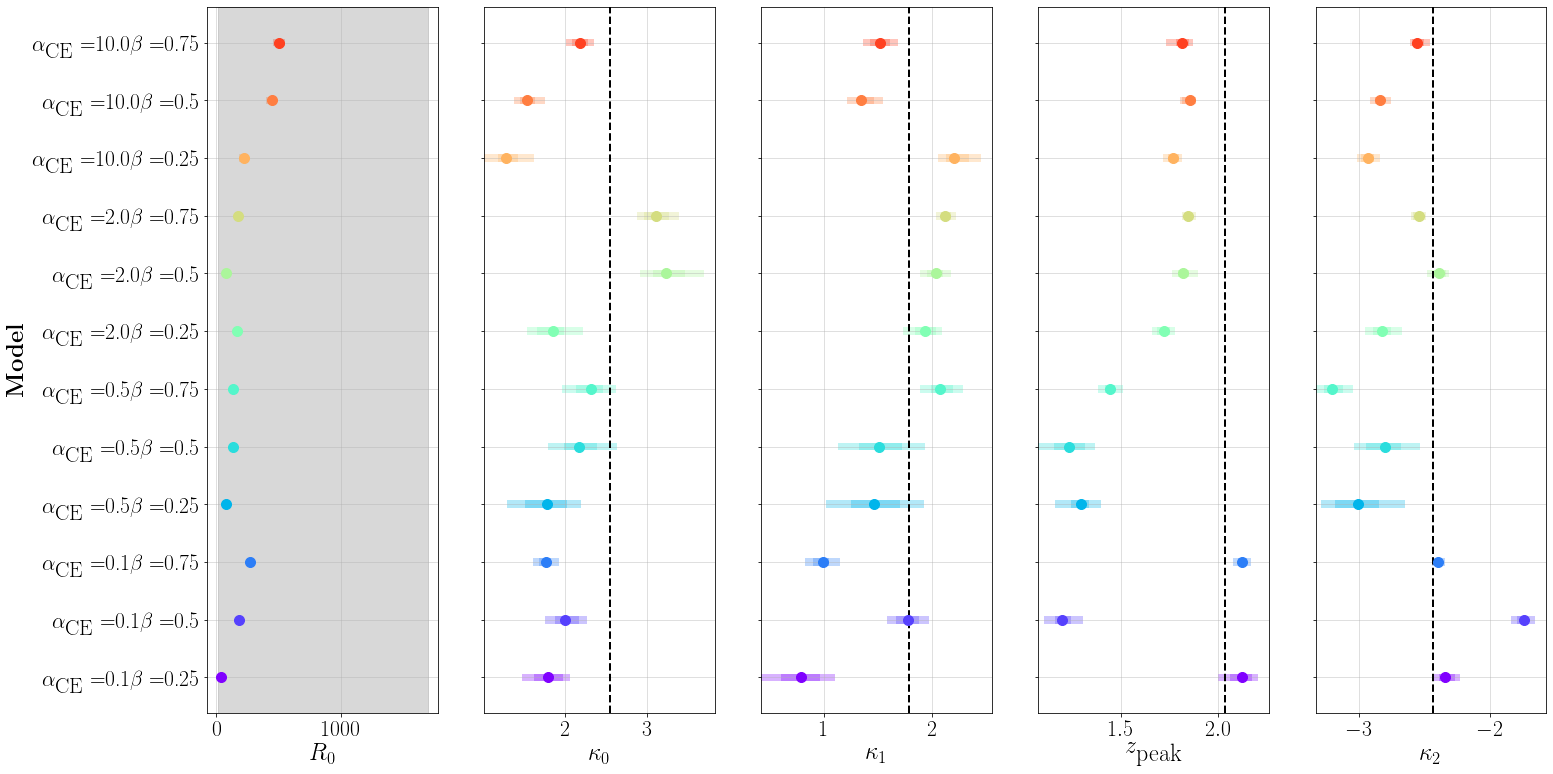

In [ ]:
plot_rates_kappa_and_peaks(alpha_vals, beta_vals, color_grid=color_grid, dco_type='BNS', lw=2)

## b) BHNS

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


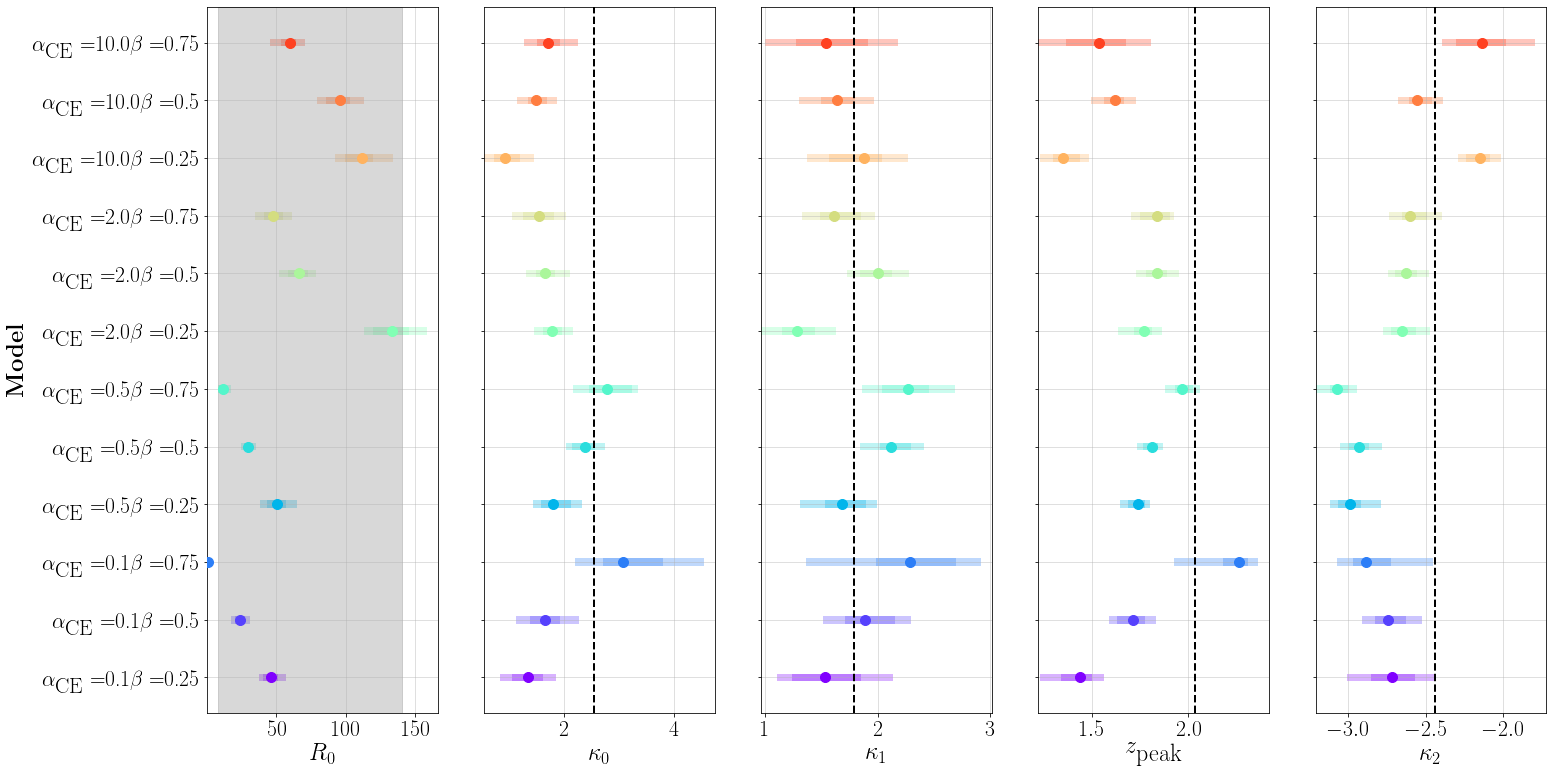

In [ ]:
plot_rates_kappa_and_peaks(alpha_vals, beta_vals, color_grid=color_grid, dco_type='BHNS', lw=2)

## c) BBH

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


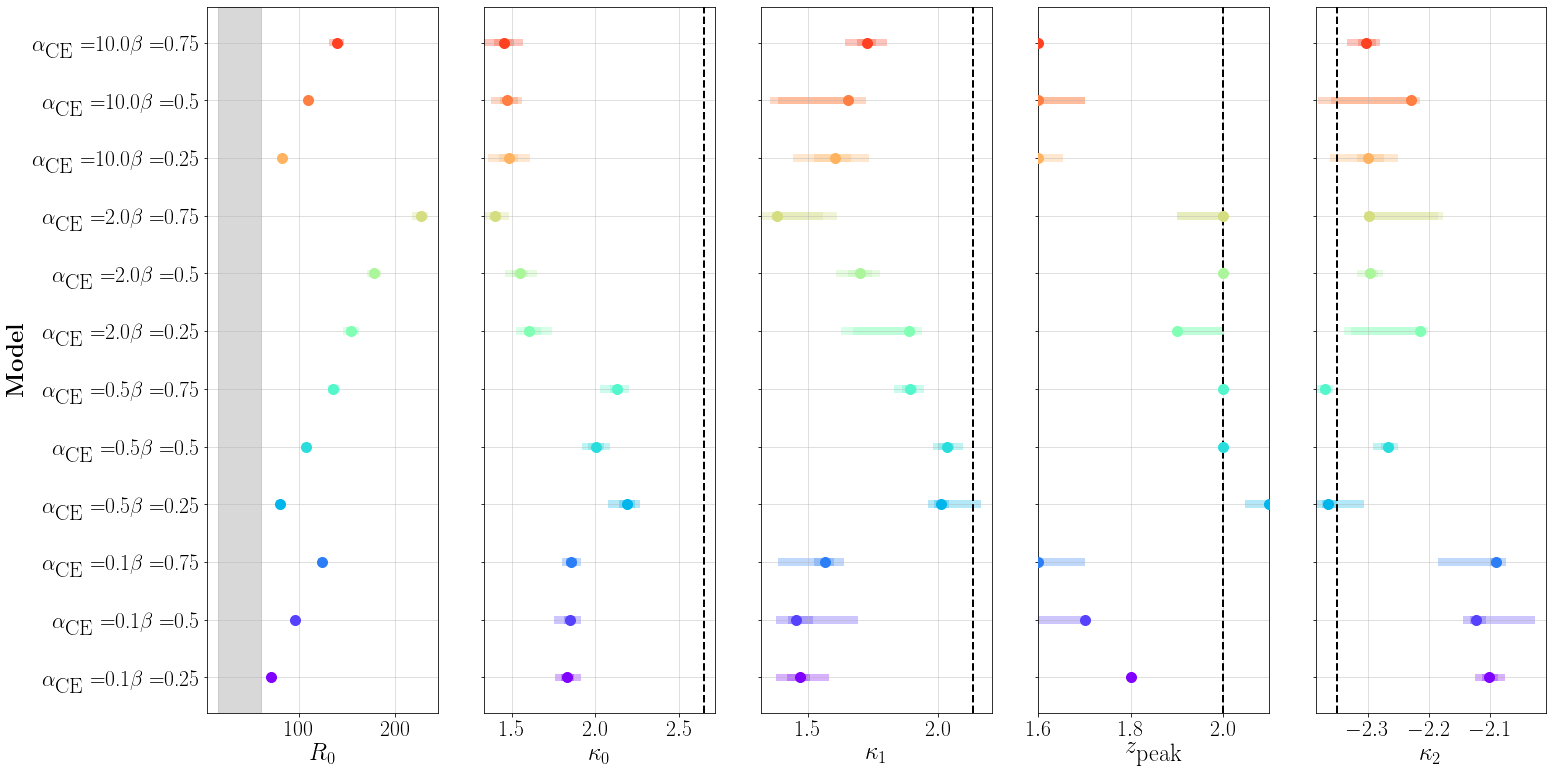

In [ ]:
plot_rates_kappa_and_peaks(alpha_vals, beta_vals, color_grid=color_grid, dco_type='BBH', lw=2)

# Plot double broken power law fit as function of uncertainty values

The color grids

In [ ]:
rainbow_cmap = matplotlib.cm.get_cmap('rainbow')
num_colors = len(alpha_vals) + len(beta_vals)

alpha_color_grid = []
counter=0
for alpha_index, alpha in enumerate(alpha_vals):
    alpha_color_grid.append(rainbow_cmap(counter/num_colors))
    counter+=1

beta_color_grid = []
for beta_index, beta in enumerate(beta_vals):
    beta_color_grid.append(rainbow_cmap(counter/num_colors))
    counter+=1

The function to plot

In [ ]:
def plot_functions_of_params(alpha_vals, beta_vals, alpha_color_grid, beta_color_grid, dco_type=None, lw=3, fs=24, markersize=4):
        
        assert dco_type != None, 'dco_type must be given'

        # Dictionaries to retrieve the data:
        total_formation_rates = {}
        total_merger_rates = {}
        one_sigma = {}
        two_sigma = {}
        formation_rate_kappa0 = {}
        formation_rate_kappa1 = {}
        formation_rate_kappa2 = {}
        merger_rate_kappa0 = {}
        merger_rate_kappa1 = {}
        merger_rate_kappa2 = {}
        formation_rate_peak_zs = {}
        merger_rate_peak_zs = {}
        redshifts = {}
        intrinsic_formation_rate = {}
        intrinsic_merger_rate = {}

        ######################################################################
        # Retrieve the data
        index = 0
        for alpha_val in alpha_vals:
                # Make the dictionary "2D"
                total_formation_rates[alpha_val] = {}
                total_merger_rates[alpha_val] = {}
                one_sigma[alpha_val] = {}
                two_sigma[alpha_val] = {}
                formation_rate_kappa0[alpha_val] = {}
                formation_rate_kappa1[alpha_val] = {}
                formation_rate_kappa2[alpha_val] = {}
                merger_rate_kappa0[alpha_val] = {}
                merger_rate_kappa1[alpha_val] = {}
                merger_rate_kappa2[alpha_val] = {}
                formation_rate_peak_zs[alpha_val] = {}
                merger_rate_peak_zs[alpha_val] = {}
                redshifts[alpha_val] = {}         
                intrinsic_formation_rate[alpha_val] = {}
                intrinsic_merger_rate[alpha_val] = {}

                for beta_val in beta_vals:
                        one_sigma[alpha_val][beta_val] = {}
                        two_sigma[alpha_val][beta_val] = {}
                        
                        with open(path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val + '/Pickled_Rates/MSSFR_111/' + dco_type + '/rates_and_bootstraps.h5', 'rb') as f:
                                
                                # Get data
                                h5_data = h5.File(f)
                                total_formation_rates[alpha_val][beta_val] = h5_data['Actual']['total_formation_rates'][...]
                                total_merger_rates[alpha_val][beta_val] = h5_data['Actual']['total_merger_rates'][...]
                                redshifts[alpha_val][beta_val] = h5_data['Actual']['redshifts'][...]

                                # GET RATE KAPPAS, Z_PEAK, AND R0                                
                                # Get the intrinsic rates
                                intrinsic_formation_rate[alpha_val][beta_val] = total_formation_rates[alpha_val][beta_val][0]
                                intrinsic_merger_rate[alpha_val][beta_val] = total_merger_rates[alpha_val][beta_val][0]

                                # Get kappas
                                # Formation rates
                                formation_rate_kappas, formation_rate_peak_z = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val],  total_formation_rates[alpha_val][beta_val]/max(total_formation_rates[alpha_val][beta_val]))
                                formation_rate_peak_zs[alpha_val][beta_val] = formation_rate_peak_z
                                formation_rate_kappa0[alpha_val][beta_val] = formation_rate_kappas[0]
                                formation_rate_kappa1[alpha_val][beta_val] = formation_rate_kappas[1]
                                formation_rate_kappa2[alpha_val][beta_val] = formation_rate_kappas[2]
                                # Merger rates
                                merger_rate_kappas, merger_rate_peak_z = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val],  total_merger_rates[alpha_val][beta_val]/max(total_merger_rates[alpha_val][beta_val]))
                                merger_rate_peak_zs[alpha_val][beta_val] = merger_rate_peak_z
                                merger_rate_kappa0[alpha_val][beta_val] = merger_rate_kappas[0]
                                merger_rate_kappa1[alpha_val][beta_val] = merger_rate_kappas[1]
                                merger_rate_kappa2[alpha_val][beta_val] = merger_rate_kappas[2]


                                # CONFIDENCE INTERVALS!
                                # Iterate through all the bootstrapped rates and calculate the kappa values for the rates
                                formation_rate_kappa0s = []
                                formation_rate_kappa1s = []
                                formation_rate_kappa2s = []
                                formation_rate_peaks = []
                                merger_rate_kappa0s = []
                                merger_rate_kappa1s = []
                                merger_rate_kappa2s = []
                                merger_rate_peaks = []
                                intrinsic_formation_rates = []
                                intrinsic_merger_rates = []
                                for rate_index in range(len(h5_data['Bootstraps']['total_formation_rates'][...])):
                                        
                                        # Get the akppa for the current bootstrap iteration
                                        if np.argmax(h5_data['Bootstraps']['total_formation_rates'][...][rate_index]) != 0 and np.argmax(h5_data['Bootstraps']['total_merger_rates'][...][rate_index]) != 0: # We will not count the bootstrapped rate if the rate's max is at z=0
                                                # Get the kappas and peaks
                                                formation_rate_kappas_bs, formation_rate_peak = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val], h5_data['Bootstraps']['total_formation_rates'][...][rate_index]/max(h5_data['Bootstraps']['total_formation_rates'][...][rate_index]))
                                                merger_rate_kappas_bs, merger_rate_peak = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val], h5_data['Bootstraps']['total_merger_rates'][...][rate_index]/max(h5_data['Bootstraps']['total_merger_rates'][...][rate_index]))

                                                # Store the kappas
                                                formation_rate_kappa0s.append(formation_rate_kappas_bs[0])
                                                formation_rate_kappa1s.append(formation_rate_kappas_bs[1])
                                                formation_rate_kappa2s.append(formation_rate_kappas_bs[2])
                                                merger_rate_kappa0s.append(merger_rate_kappas_bs[0])
                                                merger_rate_kappa1s.append(merger_rate_kappas_bs[1])
                                                merger_rate_kappa2s.append(merger_rate_kappas_bs[2])

                                                # Store the peaks
                                                formation_rate_peaks.append(formation_rate_peak)
                                                merger_rate_peaks.append(merger_rate_peak)

                                                # Get the intrinsic rates
                                                intrinsic_formation_rates.append(h5_data['Bootstraps']['total_formation_rates'][...][rate_index][0])
                                                intrinsic_merger_rates.append(h5_data['Bootstraps']['total_merger_rates'][...][rate_index][0])


                                # Get and store the confidence intervals for the kappas
                                # Formation rates
                                one_sigma[alpha_val][beta_val]['formation_rate_kappa0']         = np.percentile(formation_rate_kappa0s, [16, 84])
                                one_sigma[alpha_val][beta_val]['formation_rate_kappa1']         = np.percentile(formation_rate_kappa1s, [16, 84])
                                one_sigma[alpha_val][beta_val]['formation_rate_kappa2']         = np.percentile(formation_rate_kappa2s, [16, 84])
                                one_sigma[alpha_val][beta_val]['formation_rate_peak_z']         = np.percentile(formation_rate_peaks, [16, 84])
                                one_sigma[alpha_val][beta_val]['intrinsic_formation_rate']      = np.percentile(intrinsic_formation_rates, [16, 84])
                                two_sigma[alpha_val][beta_val]['formation_rate_kappa0']         = np.percentile(formation_rate_kappa0s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['formation_rate_kappa1']         = np.percentile(formation_rate_kappa1s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['formation_rate_kappa2']         = np.percentile(formation_rate_kappa2s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['formation_rate_peak_z']         = np.percentile(formation_rate_peaks, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['intrinsic_formation_rate']      = np.percentile(intrinsic_formation_rates, [2.5, 97.5])
                                # Merger rates
                                one_sigma[alpha_val][beta_val]['merger_rate_kappa0']            = np.percentile(merger_rate_kappa0s, [16, 84])
                                one_sigma[alpha_val][beta_val]['merger_rate_kappa1']            = np.percentile(merger_rate_kappa1s, [16, 84])
                                one_sigma[alpha_val][beta_val]['merger_rate_kappa2']            = np.percentile(merger_rate_kappa2s, [16, 84])
                                one_sigma[alpha_val][beta_val]['merger_rate_peak_z']            = np.percentile(merger_rate_peaks, [16, 84])
                                one_sigma[alpha_val][beta_val]['intrinsic_merger_rate']         = np.percentile(intrinsic_merger_rates, [16, 84])
                                two_sigma[alpha_val][beta_val]['merger_rate_kappa0']            = np.percentile(merger_rate_kappa0s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['merger_rate_kappa1']            = np.percentile(merger_rate_kappa1s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['merger_rate_kappa2']            = np.percentile(merger_rate_kappa2s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['merger_rate_peak_z']            = np.percentile(merger_rate_peaks, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['intrinsic_merger_rate']         = np.percentile(intrinsic_merger_rates, [2.5, 97.5])
                        # with open('/Users/adamboesky/Research/PRISE/exploring_parameter_space/Data/Pickled_Rates/MSSSFR_111/' + dco_type + '/alpha_CE_' + alpha_val + '_beta_' + beta_val + '.pkl', 'rb') as f:
                                
                        #         # GET RATE KAPPAS, Z_PEAK, AND R0
                        #         # Get peaks
                        #         dict = pickle.load(f)
                        #         total_formation_rates[alpha_val][beta_val] = dict['total_formation_rates']
                        #         total_merger_rates[alpha_val][beta_val] = dict['total_merger_rates']
                        #         # redshifts[alpha_val][beta_val] = dict['redshfits']
                        #         redshifts[alpha_val][beta_val] = np.linspace(0, 10, num=len(dict['total_merger_rates']))

                        #         # Get the intrinsic rates
                        #         intrinsic_formation_rate[alpha_val][beta_val] = total_formation_rates[alpha_val][beta_val][0]
                        #         intrinsic_merger_rate[alpha_val][beta_val] = total_merger_rates[alpha_val][beta_val][0]

                        #         # Get kappas
                        #         # Formation rates
                        #         formation_rate_kappas, formation_rate_peak_z = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val],  total_formation_rates[alpha_val][beta_val]/max(total_formation_rates[alpha_val][beta_val]))
                        #         formation_rate_peak_zs[alpha_val][beta_val] = formation_rate_peak_z
                        #         formation_rate_kappa0[alpha_val][beta_val] = formation_rate_kappas[0]
                        #         formation_rate_kappa1[alpha_val][beta_val] = formation_rate_kappas[1]
                        #         formation_rate_kappa2[alpha_val][beta_val] = formation_rate_kappas[2]
                        #         # Merger rates
                        #         merger_rate_kappas, merger_rate_peak_z = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val],  total_merger_rates[alpha_val][beta_val]/max(total_merger_rates[alpha_val][beta_val]))
                        #         merger_rate_peak_zs[alpha_val][beta_val] = merger_rate_peak_z
                        #         merger_rate_kappa0[alpha_val][beta_val] = merger_rate_kappas[0]
                        #         merger_rate_kappa1[alpha_val][beta_val] = merger_rate_kappas[1]
                        #         merger_rate_kappa2[alpha_val][beta_val] = merger_rate_kappas[2]


                        #         # CONFIDENCE INTERVALS!
                        #         # Iterate through all the bootstrapped rates and calculate the kappa values for the rates
                        #         formation_rate_kappa0s = []
                        #         formation_rate_kappa1s = []
                        #         formation_rate_kappa2s = []
                        #         formation_rate_peaks = []
                        #         merger_rate_kappa0s = []
                        #         merger_rate_kappa1s = []
                        #         merger_rate_kappa2s = []
                        #         merger_rate_peaks = []
                        #         intrinsic_formation_rates = []
                        #         intrinsic_merger_rates = []
                        #         for rate_index in range(len(dict['bootstraps']['total_formation_rates'])):
                                        
                        #                 # Get the akppa for the current bootstrap iteration
                        #                 if np.argmax(dict['bootstraps']['total_formation_rates'][rate_index]) != 0 and np.argmax(dict['bootstraps']['total_merger_rates'][rate_index]) != 0: # We will not count the bootstrapped rate if the rate's max is at z=0
                        #                         # Get the kappas and peaks
                        #                         formation_rate_kappas_bs, formation_rate_peak = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val], dict['bootstraps']['total_formation_rates'][rate_index]/max(dict['bootstraps']['total_formation_rates'][rate_index]))
                        #                         merger_rate_kappas_bs, merger_rate_peak = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val], dict['bootstraps']['total_merger_rates'][rate_index]/max(dict['bootstraps']['total_merger_rates'][rate_index]))

                        #                         # Store the kappas
                        #                         formation_rate_kappa0s.append(formation_rate_kappas_bs[0])
                        #                         formation_rate_kappa1s.append(formation_rate_kappas_bs[1])
                        #                         formation_rate_kappa2s.append(formation_rate_kappas_bs[2])
                        #                         merger_rate_kappa0s.append(merger_rate_kappas_bs[0])
                        #                         merger_rate_kappa1s.append(merger_rate_kappas_bs[1])
                        #                         merger_rate_kappa2s.append(merger_rate_kappas_bs[2])

                        #                         # Store the peaks
                        #                         formation_rate_peaks.append(formation_rate_peak)
                        #                         merger_rate_peaks.append(merger_rate_peak)

                        #                         # Get the intrinsic rates
                        #                         intrinsic_formation_rates.append(dict['bootstraps']['total_formation_rates'][rate_index][0])
                        #                         intrinsic_merger_rates.append(dict['bootstraps']['total_merger_rates'][rate_index][0])


                        #         # Get and store the confidence intervals for the kappas
                        #         # Formation rates
                        #         one_sigma[alpha_val][beta_val]['formation_rate_kappa0']         = np.percentile(formation_rate_kappa0s, [16, 84])
                        #         one_sigma[alpha_val][beta_val]['formation_rate_kappa1']         = np.percentile(formation_rate_kappa1s, [16, 84])
                        #         one_sigma[alpha_val][beta_val]['formation_rate_kappa2']         = np.percentile(formation_rate_kappa2s, [16, 84])
                        #         one_sigma[alpha_val][beta_val]['formation_rate_peak_z']         = np.percentile(formation_rate_peaks, [16, 84])
                        #         one_sigma[alpha_val][beta_val]['intrinsic_formation_rate']      = np.percentile(intrinsic_formation_rates, [16, 84])
                        #         two_sigma[alpha_val][beta_val]['formation_rate_kappa0']         = np.percentile(formation_rate_kappa0s, [2.5, 97.5])
                        #         two_sigma[alpha_val][beta_val]['formation_rate_kappa1']         = np.percentile(formation_rate_kappa1s, [2.5, 97.5])
                        #         two_sigma[alpha_val][beta_val]['formation_rate_kappa2']         = np.percentile(formation_rate_kappa2s, [2.5, 97.5])
                        #         two_sigma[alpha_val][beta_val]['formation_rate_peak_z']         = np.percentile(formation_rate_peaks, [2.5, 97.5])
                        #         two_sigma[alpha_val][beta_val]['intrinsic_formation_rate']      = np.percentile(intrinsic_formation_rates, [2.5, 97.5])
                        #         # Merger rates
                        #         one_sigma[alpha_val][beta_val]['merger_rate_kappa0']            = np.percentile(merger_rate_kappa0s, [16, 84])
                        #         one_sigma[alpha_val][beta_val]['merger_rate_kappa1']            = np.percentile(merger_rate_kappa1s, [16, 84])
                        #         one_sigma[alpha_val][beta_val]['merger_rate_kappa2']            = np.percentile(merger_rate_kappa2s, [16, 84])
                        #         one_sigma[alpha_val][beta_val]['merger_rate_peak_z']            = np.percentile(merger_rate_peaks, [16, 84])
                        #         one_sigma[alpha_val][beta_val]['intrinsic_merger_rate']         = np.percentile(intrinsic_merger_rates, [16, 84])
                        #         two_sigma[alpha_val][beta_val]['merger_rate_kappa0']            = np.percentile(merger_rate_kappa0s, [2.5, 97.5])
                        #         two_sigma[alpha_val][beta_val]['merger_rate_kappa1']            = np.percentile(merger_rate_kappa1s, [2.5, 97.5])
                        #         two_sigma[alpha_val][beta_val]['merger_rate_kappa2']            = np.percentile(merger_rate_kappa2s, [2.5, 97.5])
                        #         two_sigma[alpha_val][beta_val]['merger_rate_peak_z']            = np.percentile(merger_rate_peaks, [2.5, 97.5])
                        #         two_sigma[alpha_val][beta_val]['intrinsic_merger_rate']         = np.percentile(intrinsic_merger_rates, [2.5, 97.5])


        ######################################################################
        # Plot the merger rate kappas and z_peak
        merger_fig, merger_axes = plt.subplots(5, 2, figsize=(24, 24))

        # Make grid in background
        for ax_index, ax in enumerate(merger_axes[:, 0].flatten()):
                ax.set_xscale('log')
        #         ax.set_yscale('log')
        # merger_axes[0].grid(alpha=0.5, zorder=-1)
        # merger_axes[1].grid(alpha=0.5, zorder=-1)
        # merger_axes[2].grid(alpha=0.5, zorder=-1)
        # merger_axes[3].grid(alpha=0.5, zorder=-1)
        # merger_axes[4].grid(alpha=0.5, zorder=-1)

        index = 0
        labels = []
        label_indexs = []
        alpha_floats = np.array(alpha_vals).astype(float)
        for beta_index, beta_val in enumerate(beta_vals): 
                R0s = []
                kappa0s = []
                kappa1s = []
                kappa2s = []
                z_peaks = []
                for alpha_val in alpha_vals:
                        R0s.append(intrinsic_merger_rate[alpha_val][beta_val])
                        kappa0s.append(merger_rate_kappa0[alpha_val][beta_val])
                        kappa1s.append(merger_rate_kappa1[alpha_val][beta_val])
                        kappa2s.append(merger_rate_kappa2[alpha_val][beta_val])
                        z_peaks.append(merger_rate_peak_zs[alpha_val][beta_val])
                
                # Plot the values
                merger_axes[0, 0].plot(alpha_floats, R0s, color=beta_color_grid[beta_index], lw=3, zorder=-1, label=r'$\beta = $' + beta_val)
                merger_axes[0, 0].scatter(alpha_floats, R0s, color='black', s=markersize)

                merger_axes[1, 0].plot(alpha_floats, kappa0s, color=beta_color_grid[beta_index], lw=3, zorder=-1)
                merger_axes[1, 0].scatter(alpha_floats, kappa0s, color='black', s=markersize)

                merger_axes[2, 0].plot(alpha_floats, kappa1s, color=beta_color_grid[beta_index], lw=3, zorder=-1)
                merger_axes[2, 0].scatter(alpha_floats, kappa1s, color='black', s=markersize)

                merger_axes[3, 0].plot(alpha_floats, z_peaks, color=beta_color_grid[beta_index], lw=3, zorder=-1)
                merger_axes[3, 0].scatter(alpha_floats, z_peaks, color='black', s=markersize)

                merger_axes[4, 0].plot(alpha_floats, np.absolute(kappa2s), color=beta_color_grid[beta_index], lw=3, zorder=-1)
                merger_axes[4, 0].scatter(alpha_floats, np.absolute(kappa2s), color='black', s=markersize)


        # for alpha_val in alpha_vals:
        #         for index, beta_val in enumerate(beta_vals):
        #                 height = one_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][1] - one_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][0]                                                                       # Get the width of the 1sigma error bar
        #                 merger_axes[0, 1].bar(float(beta_val), two_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][1], width=0.008, bottom=R0s - two_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][0], align='center', alpha=0.3)
        
        beta_floats = np.array(beta_vals).astype(float)
        for alpha_index, alpha_val in enumerate(alpha_vals):
                # Get a numpy arrays of the values for each plot
                R0s = np.array(list(intrinsic_merger_rate[alpha_val].values()))
                kappa0s = np.array(list(merger_rate_kappa0[alpha_val].values()))
                kappa1s = np.array(list(merger_rate_kappa1[alpha_val].values()))
                kappa2s = np.array(list(merger_rate_kappa2[alpha_val].values()))
                z_peaks = np.array(list(merger_rate_peak_zs[alpha_val].values()))

                # Plot the values
                # merger_axes[0].barh(index, width=width, left=one_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)             # 1sigma error bar
                # for index, beta_val in enumerate(beta_vals):
                #         height = one_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][1] - one_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][0]                                                                       # Get the width of the 1sigma error bar
                #         merger_axes[0, 1].bar(float(beta_val), height, width=0.008, bottom=R0s - one_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][0], align='center', log=True, alpha=0.3)



                merger_axes[0, 1].plot(beta_floats, R0s, color=alpha_color_grid[alpha_index], lw=3, zorder=-1, label=r'$\alpha_\textrm{CE} = $' + alpha_val)
                merger_axes[0, 1].scatter(beta_floats, R0s, color='black', s=markersize)

                merger_axes[1, 1].plot(beta_floats, kappa0s, color=alpha_color_grid[alpha_index], lw=3, zorder=-1)
                merger_axes[1, 1].scatter(beta_floats, kappa0s, color='black', s=markersize)

                merger_axes[2, 1].plot(beta_floats, kappa1s, color=alpha_color_grid[alpha_index], lw=3, zorder=-1)
                merger_axes[2, 1].scatter(beta_floats, kappa1s, color='black', s=markersize)

                merger_axes[3, 1].plot(beta_floats, z_peaks, color=alpha_color_grid[alpha_index], lw=3, zorder=-1)
                merger_axes[3, 1].scatter(beta_floats, z_peaks, color='black', s=markersize)

                merger_axes[4, 1].plot(beta_floats, np.absolute(kappa2s), color=alpha_color_grid[alpha_index], lw=3, zorder=-1)
                merger_axes[4, 1].scatter(beta_floats, np.absolute(kappa2s), color='black', s=markersize)

        for ax in merger_axes.flatten():
            ax.tick_params(axis='both', labelsize=0.9*fs)
        
        merger_axes[4, 0].set_xlabel(r'$\alpha_\textrm{CE}$', fontsize=fs)
        merger_axes[4, 1].set_xlabel(r'$\beta$', fontsize=fs)

        merger_axes[0, 0].set_ylabel(r'$R_0$', fontsize=fs)
        merger_axes[1, 0].set_ylabel(r'$\kappa_0$', fontsize=fs)
        merger_axes[2, 0].set_ylabel(r'$\kappa_1$', fontsize=fs)
        merger_axes[3, 0].set_ylabel(r'$z_\textrm{peak}$', fontsize=fs)
        merger_axes[4, 0].set_ylabel(r'$\kappa_2$', fontsize=fs)

        merger_axes[0, 0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        merger_axes[1, 0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        merger_axes[2, 0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        merger_axes[3, 0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

        merger_axes[0, 1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        merger_axes[1, 1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        merger_axes[2, 1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        merger_axes[3, 1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

        plt.tight_layout()
        
        # Include legends
        leg1 = merger_axes[0, 0].legend(fontsize=30, ncol=4, markerscale=25, loc='upper right', bbox_to_anchor=(1, 1.25), columnspacing=3.5) 
        for legobj in leg1.legendHandles:
                legobj.set_linewidth(3.0)
        leg2 = merger_axes[0, 1].legend(fontsize=30, ncol=3, markerscale=25, loc='upper right', bbox_to_anchor=(1.02, 1.4), columnspacing=2) 
        for legobj in leg2.legendHandles:
                legobj.set_linewidth(3.0)

        plt.show()

## a) BNS

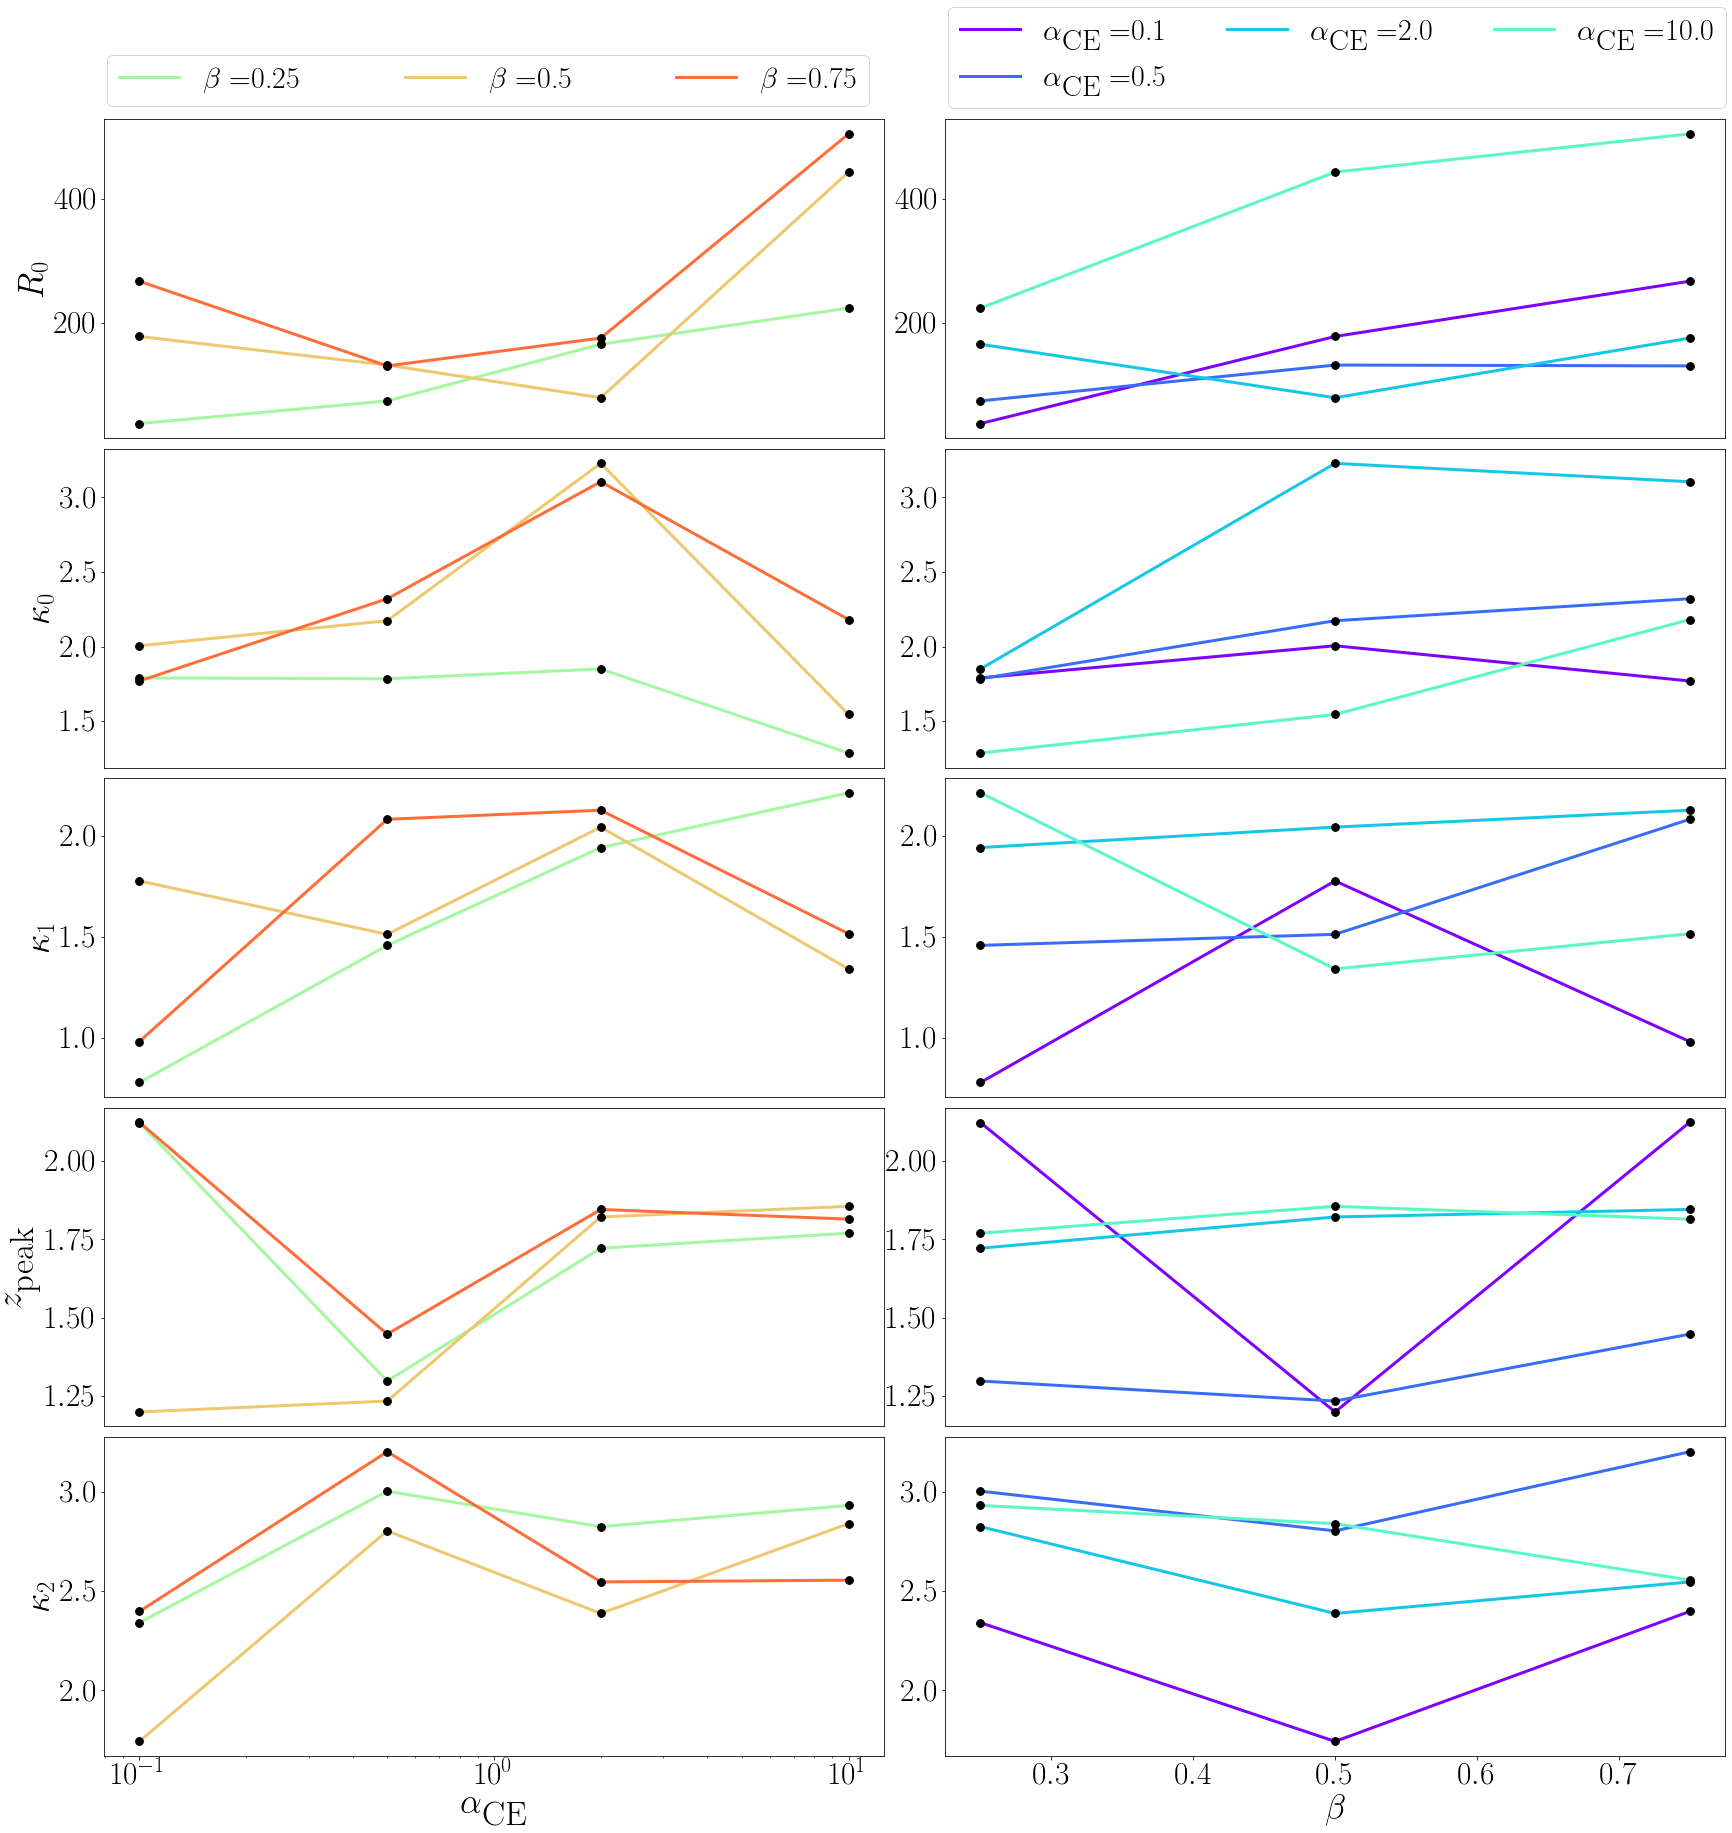

In [ ]:
plot_functions_of_params(alpha_vals, beta_vals, alpha_color_grid=alpha_color_grid, beta_color_grid=beta_color_grid, dco_type='BNS', lw=4, markersize=60, fs=35)

## b) BHNS

In [ ]:
plot_functions_of_params(alpha_vals, beta_vals, alpha_color_grid=alpha_color_grid, beta_color_grid=beta_color_grid, dco_type='BHNS', lw=4, markersize=60, fs=35)

: 

: 

## c) BBH

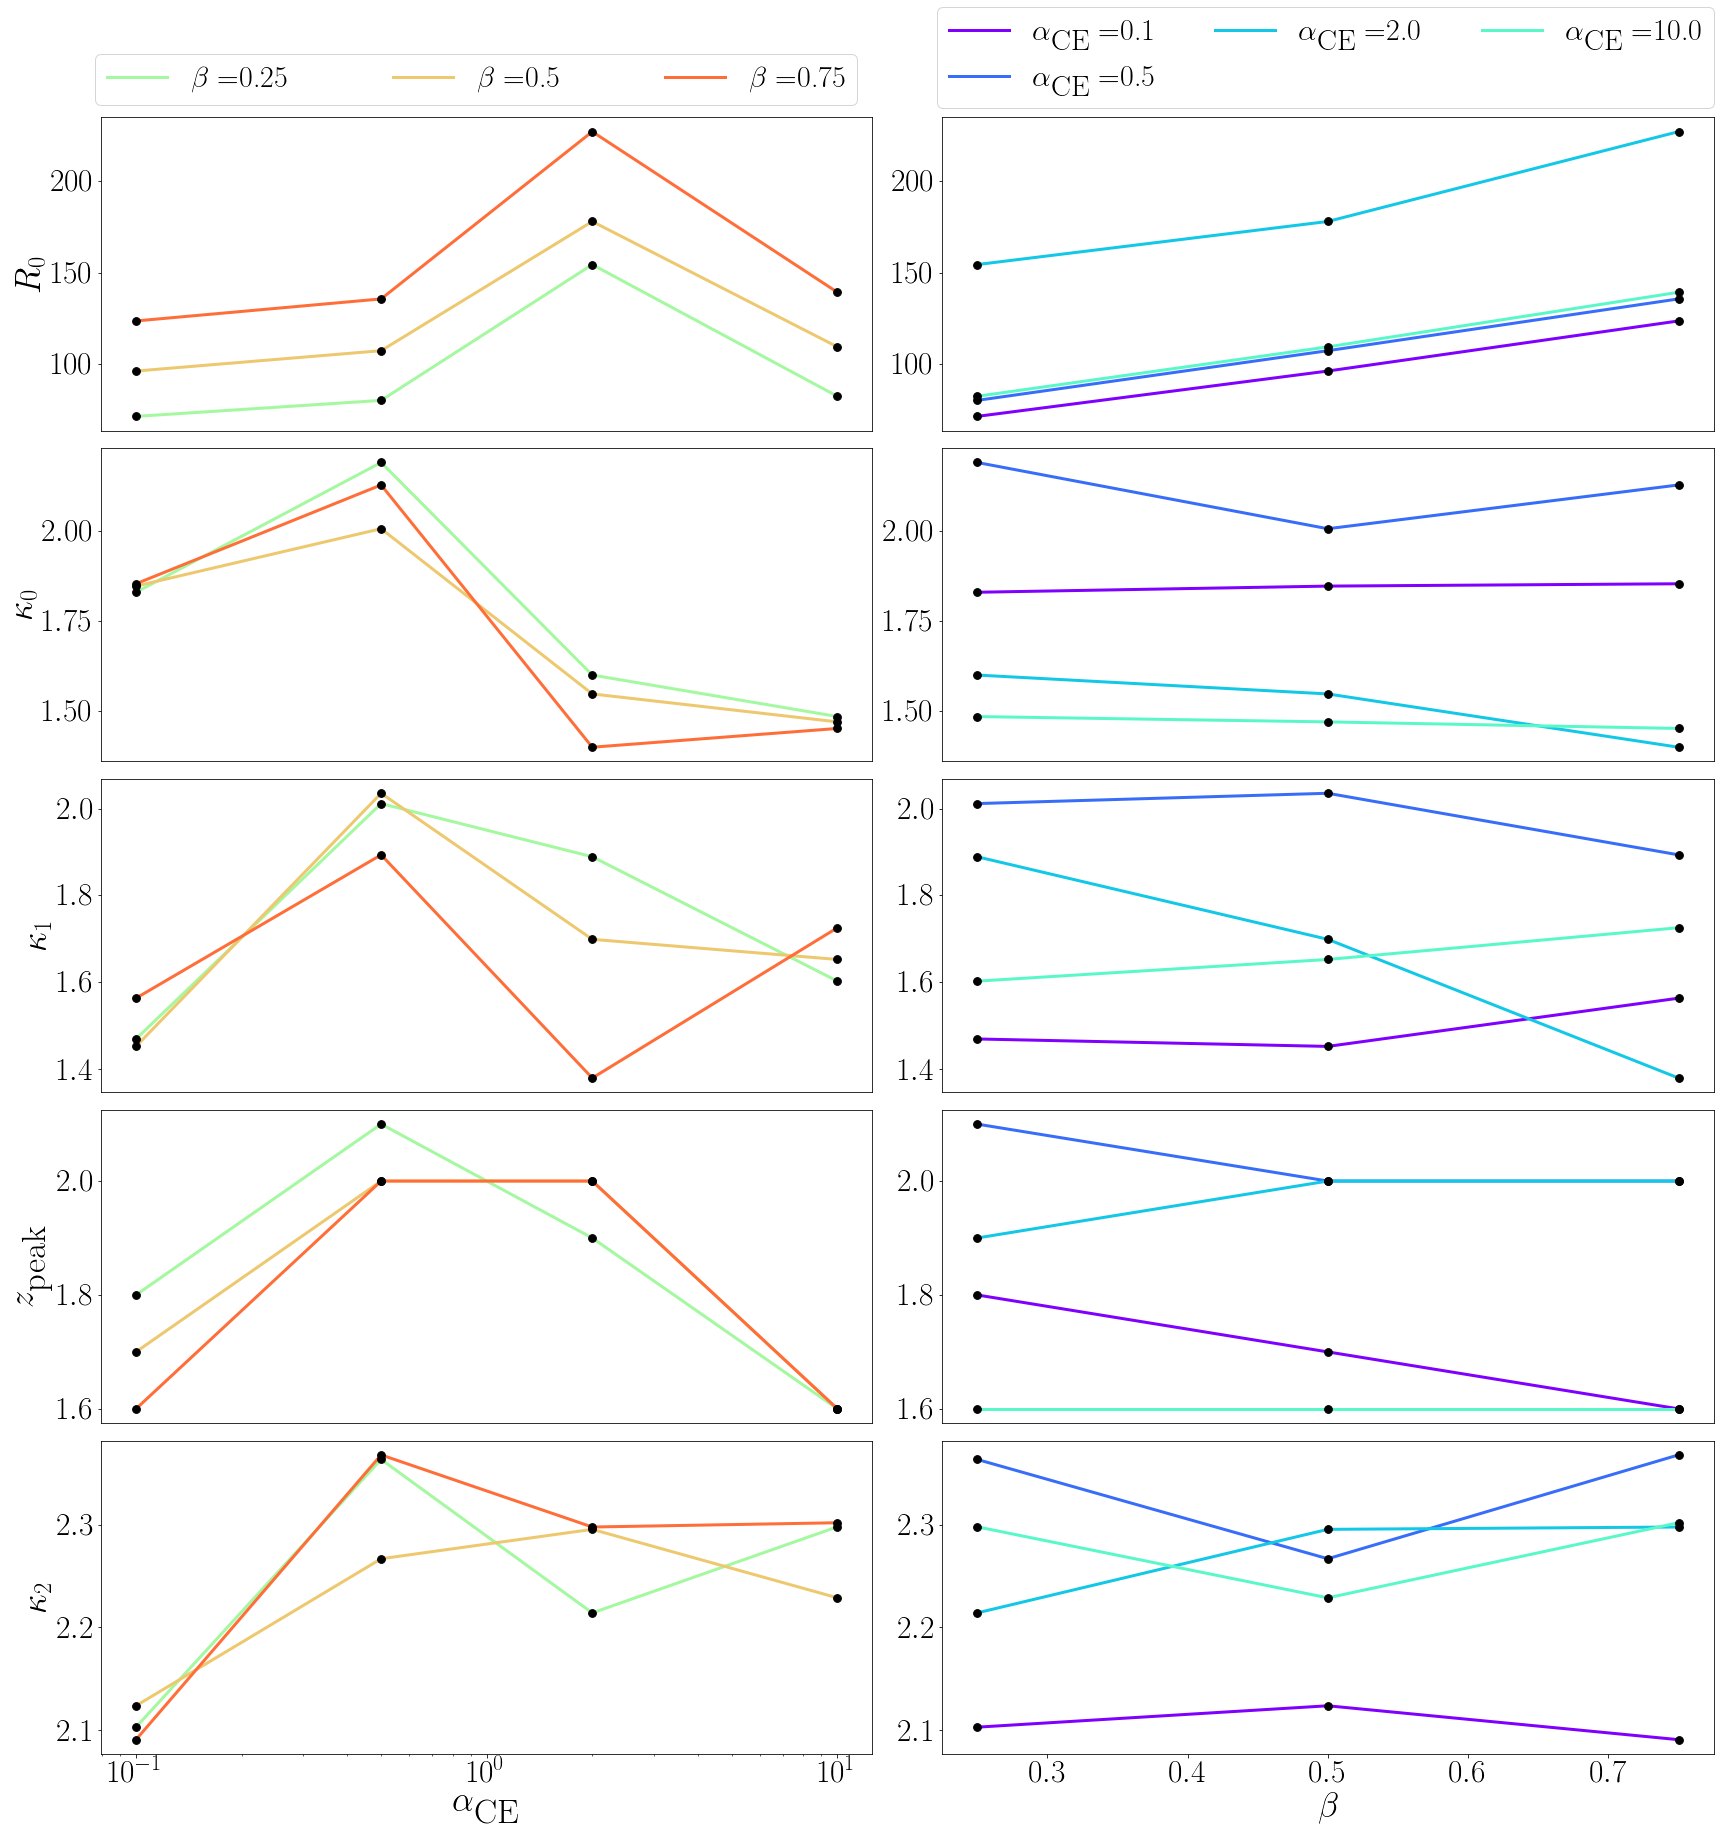

In [ ]:
plot_functions_of_params(alpha_vals, beta_vals, alpha_color_grid=alpha_color_grid, beta_color_grid=beta_color_grid, dco_type='BBH', lw=4, markersize=60, fs=35)

# Plot the rates but with the GWTC-3 rates

In [ ]:
redshift_PP_path = '/n/home04/aboesky/berger/Exploring_Parameter_Space/GWTC-3-population-data/analyses/PowerLawPeak/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_redshift_data.h5'

In [ ]:
def redshift_spectrum_plot(filename, limits, condensed_paths, alpha_vals, beta_vals, dco_type=None, lw=2):
    """
    Generates a plot of the PPD and X% credible region for the merger rate as a function of redshift,
    where X=limits[1]-limits[0]
    """                                        # ADAM'S FIDUCIAL MSSFR PARAMETERS

    # CI_kwargs = {'dco_type': dco_type, 'merger_output_filename': merger_output_filename, 'weight_column': weight_column, 'merges_hubble_time': merges_hubble_time, 'pessimistic_CEE': pessimistic_CEE, 
    #                     'no_RLOF_after_CEE': no_RLOF_after_CEE, 'max_redshift': max_redshift, 'max_redshift_detection': max_redshift_detection, 'redshift_step': redshift_step, 'z_first_SF': z_first_SF,
    #                     'use_sampled_mass_ranges': use_sampled_mass_ranges, 'm1_min': m1_min, 'm1_max': m1_max, 'm2_min': m2_min, 'fbin': fbin,
    #                     'aSF': aSF, 'bSF': bSF, 'cSF': cSF, 'dSF': dSF,
    #                     'mu0': mu0, 'muz': muz, 'sigma0': sigma0, 'sigmaz': sigmaz, 'alpha': alpha, 
    #                     'min_logZ': min_logZ, 'max_logZ': max_logZ, 'step_logZ': step_logZ,
    #                     'sensitivity': sensitivity, 'snr_threshold': snr_threshold, 
    #                     'Mc_max': Mc_max, 'Mc_step': Mc_step, 'eta_max': eta_max, 'eta_step': eta_step,
    #                     'snr_max': snr_max, 'snr_step': snr_step,
    #                     'lognormal': lognormal, 'Zprescription': Zprescription, 'SFRprescription': SFRprescription,
    #                     'GSMFprescription': GSMFprescription, 'ZMprescription': ZMprescription,
    #                     'logNormalPrescription': logNormalPrescription}

    # 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)
    total_formation_rates = {}
    total_merger_rates = {}
    total_detection_rates = {}
    cumulative_detection_rates = {}
    detection_rates_by_binary = {}
    mass_kde_scaled = {}
    redshifts = {}
    Mc_bins = {}
    one_sigma = {}
    two_sigma = {}

    for alpha_index, alpha_val in enumerate(alpha_vals):
        # Make the dictionary "2D"
        total_formation_rates[alpha_val] = {}
        total_merger_rates[alpha_val] = {}
        total_detection_rates[alpha_val] = {}
        cumulative_detection_rates[alpha_val] = {}
        detection_rates_by_binary[alpha_val] = {}
        mass_kde_scaled[alpha_val] = {}
        Mc_bins[alpha_val] = {}
        one_sigma[alpha_val] = {}
        two_sigma[alpha_val] = {}

        redshifts[alpha_val] = {}

        for beta_index, beta_val in enumerate(beta_vals):
            one_sigma[alpha_val][beta_val] = {}
            two_sigma[alpha_val][beta_val] = {}
            with open(path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val + '/Pickled_Rates/MSSFR_111/' + dco_type + '/rates_and_bootstraps.h5', 'rb') as f:
                # Get data
                h5_data = h5.File(f)
                total_formation_rates[alpha_val][beta_val] = h5_data['Actual']['total_formation_rates'][...]
                total_merger_rates[alpha_val][beta_val] = h5_data['Actual']['total_merger_rates'][...]
                # redshifts[alpha_val][beta_val] = dict['redshfits']
                redshifts[alpha_val][beta_val] = h5_data['Actual']['redshifts'][...]
                cumulative_detection_rates[alpha_val][beta_val] = h5_data['Actual']['cumulative_detection_rates'][...]
                mass_kde_scaled[alpha_val][beta_val] = h5_data['Actual']['mass_kde_scaled'][...]

                # Declare bins for the chirp mass KDE
                COMPAS = ClassCOMPAS.COMPASData(condensed_paths[alpha_val][beta_val], Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
                COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
                COMPAS.setCOMPASData()
                COMPAS.set_sw_weights(weight_column)            
                chirp_masses = (COMPAS.mass1*COMPAS.mass2)**(3./5.) / (COMPAS.mass1 + COMPAS.mass2)**(1./5.)
                Mc_bins[alpha_val][beta_val] = np.arange(0, max(chirp_masses)*1.3, max(chirp_masses)*1.2/100) # We need to pass in the bins for the chirp mass distribution so we will declare them here

                # empty trash
                del chirp_masses
                del COMPAS

                # Calculate confidence intervals
                one_sigma[alpha_val][beta_val]['total_formation_rates']          =   np.percentile(h5_data['Bootstraps']['total_formation_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['total_merger_rates']             =   np.percentile(h5_data['Bootstraps']['total_merger_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['cumulative_detection_rates']     =   np.percentile(h5_data['Bootstraps']['cumulative_detection_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [16, 84], axis=0)

                # Get the two sigma confidence intervals
                two_sigma[alpha_val][beta_val]['total_formation_rates']          =   np.percentile(h5_data['Bootstraps']['total_formation_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['total_merger_rates']             =   np.percentile(h5_data['Bootstraps']['total_merger_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['cumulative_detection_rates']     =   np.percentile(h5_data['Bootstraps']['cumulative_detection_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [2.5, 97.5], axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(9, 6))
    model = PowerLawRedshift(z_max=1.9)
    redshifts_ligo = model.zs_

    with open(filename, 'r') as _data:
        _data = dd.io.load(filename)
        lines = _data["lines"]
        ppd = _data["ppd"]
            
    label = 'GWTC-3'

        ###########################
    #Start plotting

    # set some constants for the plots
    plt.rc('font', family='serif')
    fs = 20

    # Get redshifts to use for the SFR
    sfr_redshifts = redshifts['30']['D']

    # Retreive the SFR
    MSSFR = ClassMSSFR.MSSFR()                              # Create an MSSFR object
    MSSFR.SFRprescription = SFRprescription                 # Set SFR prescription
    ages = MSSFR.cosmology.age(sfr_redshifts).value         # Get the ages
    sfr = MSSFR.returnSFR(sfr_redshifts, ages)              # Get the SFR
    sfr_normalized = sfr/sfr[0]                           # Make it so the area under the curve is 1

    


    # # Include legend
    # leg = fig.legend(fontsize=22, ncol=4, bbox_to_anchor=(0.875, .955),  markerscale=25) 
    # for legobj in leg.legendHandles:
    #     legobj.set_linewidth(3.0)



    ax.plot(redshifts_ligo, ppd, label=label)
    ax.fill_between(
        redshifts_ligo,
        np.percentile(lines["redshift"], limits[0], axis=0),
        np.percentile(lines["redshift"], limits[1], axis=0),
        alpha=0.5,
    )

    # Plot SFRs
    ax.plot(sfr_redshifts, sfr_normalized * ppd[0], color='black', lw=3, linestyle='dashed', label=r'SFR')

    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
        
            ax.plot(redshifts[alpha_val][beta_val], total_merger_rates[alpha_val][beta_val], lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val, color=color_grid[alpha_val][beta_val])
            ax.fill_between(x=redshifts[alpha_val][beta_val], y1=one_sigma[alpha_val][beta_val]['total_merger_rates'][0], y2=one_sigma[alpha_val][beta_val]['total_merger_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
            ax.fill_between(x=redshifts[alpha_val][beta_val], y1=two_sigma[alpha_val][beta_val]['total_merger_rates'][0], y2=two_sigma[alpha_val][beta_val]['total_merger_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])


    # Include legend
    leg = fig.legend(fontsize=22, ncol=3, bbox_to_anchor=(1.2, 1.5),  markerscale=25) 
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)

    ylabel = "$\\mathcal{R}(z)$ [Gpc$^{-3}$yr$^{-1}$]"
    ax.set_xlim(0, 1.5)
    ax.set_ylim(7, 3E3)
    ax.set_yscale("log")
    ax.set_xlabel("$z$", fontsize=fs)
    ax.set_ylabel(ylabel, fontsize=fs)
    ax.tick_params(axis='both', labelsize=0.9*fs)
    # ax.legend(loc="best")
    plt.tight_layout()
    return fig

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


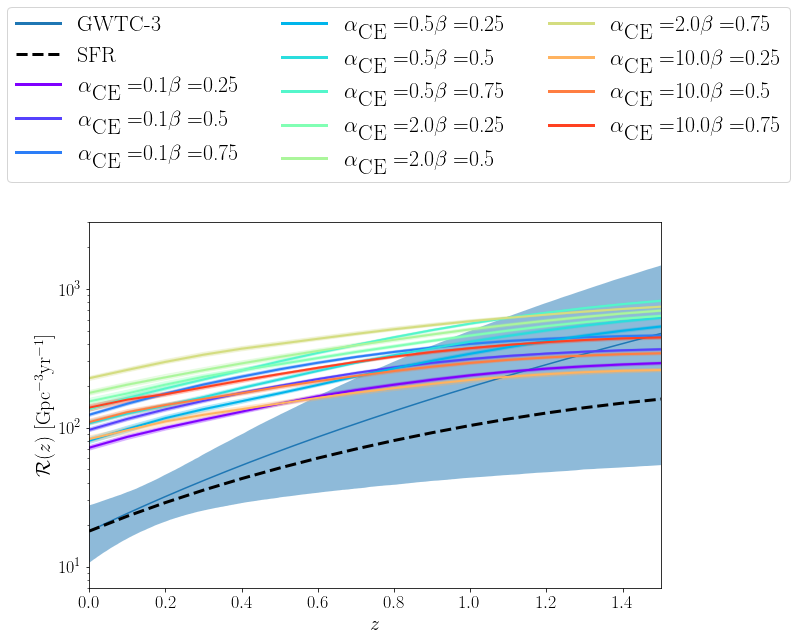

In [ ]:
redshift_fig = redshift_spectrum_plot(redshift_PP_path, limits=[5,95], condensed_paths=condensed_paths, alpha_vals=alpha_vals, beta_vals=beta_vals, dco_type='BBH')

# Some minor calculations for the paper

## The $\Delta$ between the merger and formation rate for BNS in grid A

In [ ]:
# 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)
total_formation_rates = {}
total_merger_rates = {}
total_detection_rates = {}
cumulative_detection_rates = {}
detection_rates_by_binary = {}
mass_kde_scaled = {}
redshifts = {}
Mc_bins = {}
one_sigma = {}
two_sigma = {}

for alpha_index, alpha_val in enumerate(alpha_vals):
    # Make the dictionary "2D"
    total_formation_rates[alpha_val] = {}
    total_merger_rates[alpha_val] = {}
    total_detection_rates[alpha_val] = {}
    cumulative_detection_rates[alpha_val] = {}
    detection_rates_by_binary[alpha_val] = {}
    mass_kde_scaled[alpha_val] = {}
    Mc_bins[alpha_val] = {}
    one_sigma[alpha_val] = {}
    two_sigma[alpha_val] = {}

    redshifts[alpha_val] = {}

    for beta_index, beta_val in enumerate(beta_vals):
        one_sigma[alpha_val][beta_val] = {}
        two_sigma[alpha_val][beta_val] = {}
        with open(path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val + '/Pickled_Rates/MSSFR_111/BNS/rates_and_bootstraps.h5', 'rb') as f:
            # Get data
            h5_data = h5.File(f)
            total_formation_rates[alpha_val][beta_val] = h5_data['Actual']['total_formation_rates'][...]
            total_merger_rates[alpha_val][beta_val] = h5_data['Actual']['total_merger_rates'][...]
            # redshifts[alpha_val][beta_val] = dict['redshfits']
            redshifts[alpha_val][beta_val] = h5_data['Actual']['redshifts'][...]
            cumulative_detection_rates[alpha_val][beta_val] = h5_data['Actual']['cumulative_detection_rates'][...]
            mass_kde_scaled[alpha_val][beta_val] = h5_data['Actual']['mass_kde_scaled'][...]

            # Declare bins for the chirp mass KDE
            COMPAS = ClassCOMPAS.COMPASData(condensed_paths[alpha_val][beta_val], Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
            COMPAS.setCOMPASDCOmask(types='BNS', withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
            COMPAS.setCOMPASData()
            COMPAS.set_sw_weights(weight_column)            
            chirp_masses = (COMPAS.mass1*COMPAS.mass2)**(3./5.) / (COMPAS.mass1 + COMPAS.mass2)**(1./5.)
            Mc_bins[alpha_val][beta_val] = np.arange(0, max(chirp_masses)*1.3, max(chirp_masses)*1.2/100) # We need to pass in the bins for the chirp mass distribution so we will declare them here

            # empty trash
            del chirp_masses
            del COMPAS

            # Calculate confidence intervals
            one_sigma[alpha_val][beta_val]['total_formation_rates']          =   np.percentile(h5_data['Bootstraps']['total_formation_rates'][...], [16, 84], axis=0)
            one_sigma[alpha_val][beta_val]['total_merger_rates']             =   np.percentile(h5_data['Bootstraps']['total_merger_rates'][...], [16, 84], axis=0)
            one_sigma[alpha_val][beta_val]['cumulative_detection_rates']     =   np.percentile(h5_data['Bootstraps']['cumulative_detection_rates'][...], [16, 84], axis=0)
            one_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [16, 84], axis=0)

            # Get the two sigma confidence intervals
            two_sigma[alpha_val][beta_val]['total_formation_rates']          =   np.percentile(h5_data['Bootstraps']['total_formation_rates'][...], [2.5, 97.5], axis=0)
            two_sigma[alpha_val][beta_val]['total_merger_rates']             =   np.percentile(h5_data['Bootstraps']['total_merger_rates'][...], [2.5, 97.5], axis=0)
            two_sigma[alpha_val][beta_val]['cumulative_detection_rates']     =   np.percentile(h5_data['Bootstraps']['cumulative_detection_rates'][...], [2.5, 97.5], axis=0)
            two_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [2.5, 97.5], axis=0)

            merger_max_z = redshifts[alpha_val][beta_val][np.argmax(total_merger_rates[alpha_val][beta_val])]
            formation_max_z = redshifts[alpha_val][beta_val][np.argmax(total_formation_rates[alpha_val][beta_val])]
            print('alpha = ', alpha_val, ', beta = ', beta_val, ':\t ',  formation_max_z - merger_max_z)


alpha =  0.1 , beta =  0.25 :	  0.33299999999999974
alpha =  0.1 , beta =  0.5 :	  0.635
alpha =  0.1 , beta =  0.75 :	  0.0009999999999998899
alpha =  0.5 , beta =  0.25 :	  0.496
alpha =  0.5 , beta =  0.5 :	  0.5859999999999999
alpha =  0.5 , beta =  0.75 :	  0.5609999999999999
alpha =  2.0 , beta =  0.25 :	  0.1200000000000001
alpha =  2.0 , beta =  0.5 :	  0.1419999999999999
alpha =  2.0 , beta =  0.75 :	  0.1319999999999999
alpha =  10.0 , beta =  0.25 :	  0.569
alpha =  10.0 , beta =  0.5 :	  0.46199999999999997
alpha =  10.0 , beta =  0.75 :	  0.54


## Test the log rate plots

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


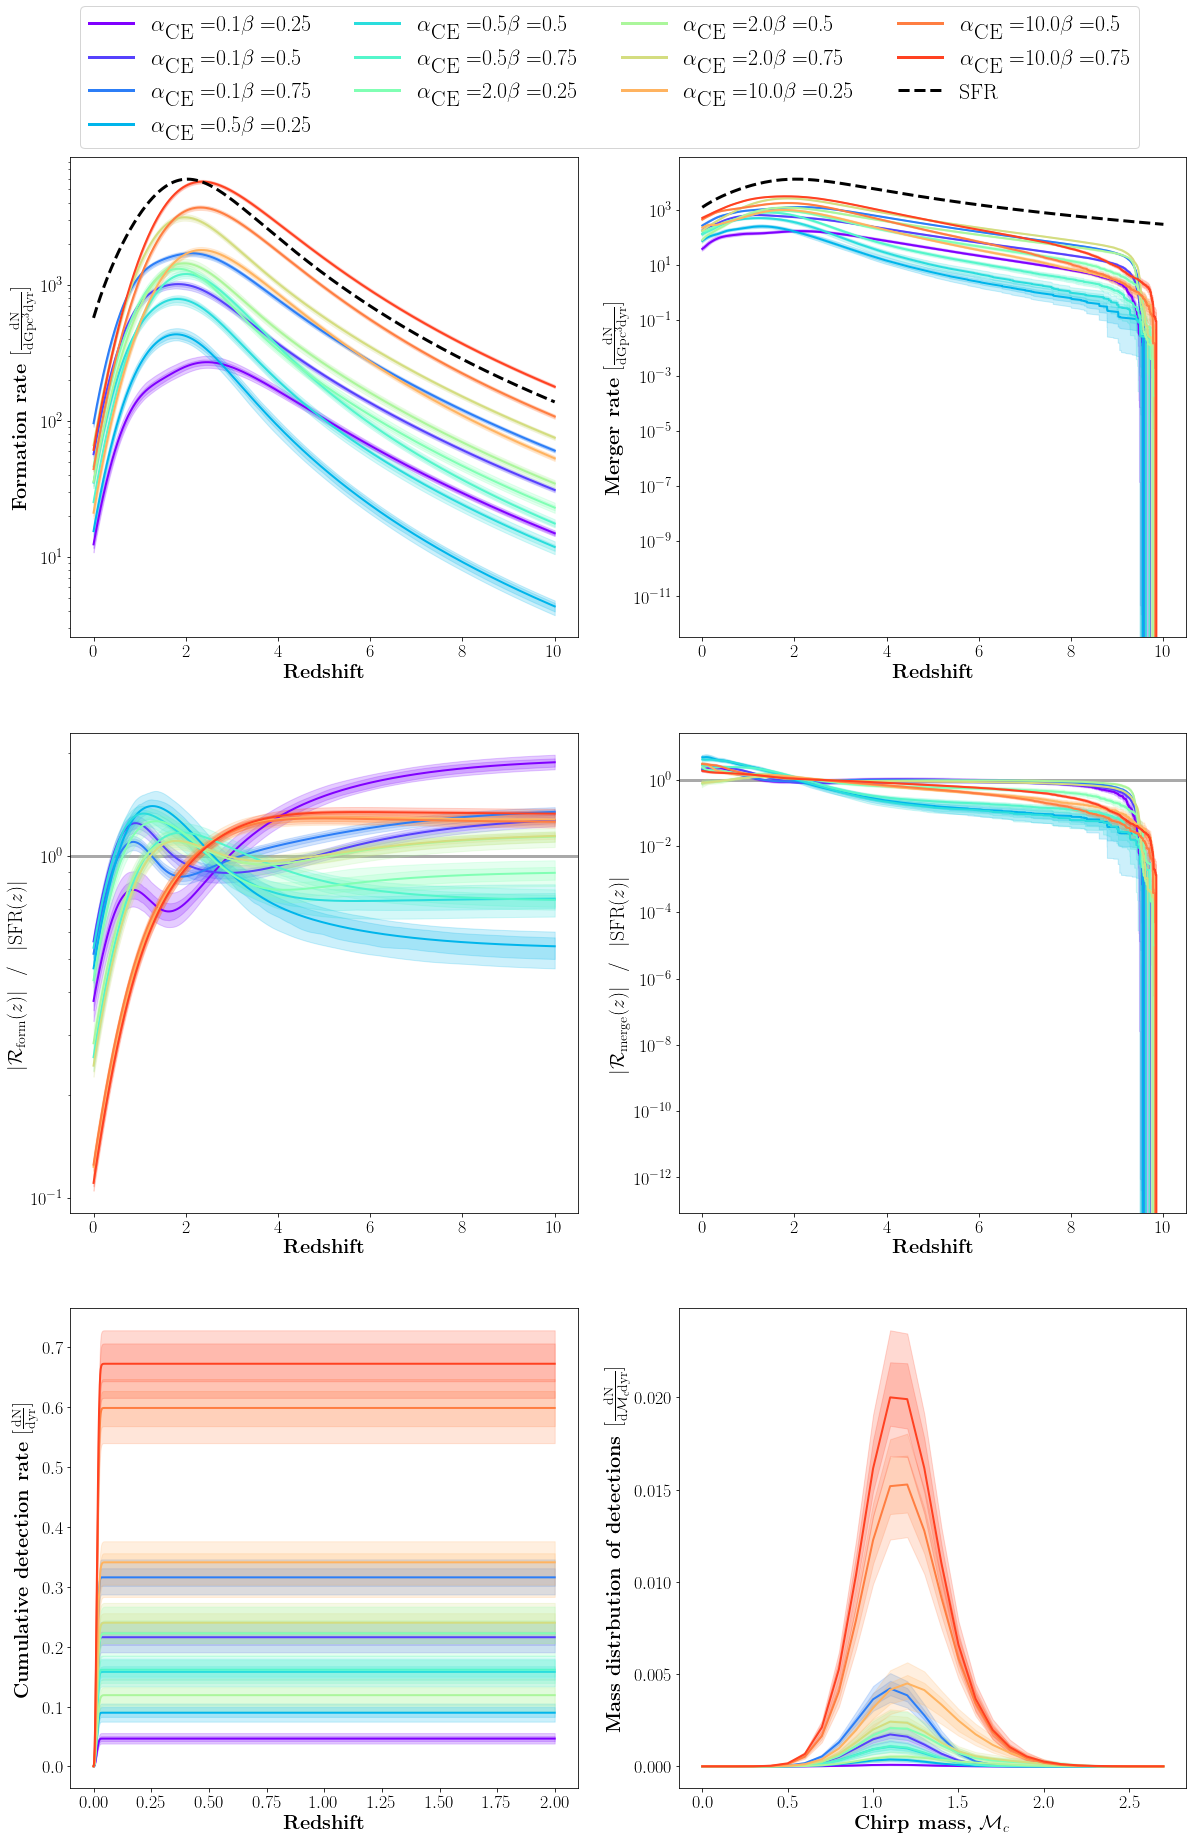

In [ ]:
def plot_pickled_rates_sfr_norm(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=2, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100):                                               # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # Make sure the dco_type is given
    assert dco_type != None, 'dco_type must be given'

    CI_kwargs = {'dco_type': dco_type, 'merger_output_filename': merger_output_filename, 'weight_column': weight_column, 'merges_hubble_time': merges_hubble_time, 'pessimistic_CEE': pessimistic_CEE, 
                        'no_RLOF_after_CEE': no_RLOF_after_CEE, 'max_redshift': max_redshift, 'max_redshift_detection': max_redshift_detection, 'redshift_step': redshift_step, 'z_first_SF': z_first_SF,
                        'use_sampled_mass_ranges': use_sampled_mass_ranges, 'm1_min': m1_min, 'm1_max': m1_max, 'm2_min': m2_min, 'fbin': fbin,
                        'aSF': aSF, 'bSF': bSF, 'cSF': cSF, 'dSF': dSF,
                        'mu0': mu0, 'muz': muz, 'sigma0': sigma0, 'sigmaz': sigmaz, 'alpha': alpha, 
                        'min_logZ': min_logZ, 'max_logZ': max_logZ, 'step_logZ': step_logZ,
                        'sensitivity': sensitivity, 'snr_threshold': snr_threshold, 
                        'Mc_max': Mc_max, 'Mc_step': Mc_step, 'eta_max': eta_max, 'eta_step': eta_step,
                        'snr_max': snr_max, 'snr_step': snr_step,
                        'lognormal': lognormal, 'Zprescription': Zprescription, 'SFRprescription': SFRprescription,
                        'GSMFprescription': GSMFprescription, 'ZMprescription': ZMprescription,
                        'logNormalPrescription': logNormalPrescription}

    # 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)
    total_formation_rates = {}
    total_merger_rates = {}
    total_detection_rates = {}
    cumulative_detection_rates = {}
    detection_rates_by_binary = {}
    mass_kde_scaled = {}
    redshifts = {}
    Mc_bins = {}
    one_sigma = {}
    two_sigma = {}

    for alpha_index, alpha_val in enumerate(alpha_vals):
        # Make the dictionary "2D"
        total_formation_rates[alpha_val] = {}
        total_merger_rates[alpha_val] = {}
        total_detection_rates[alpha_val] = {}
        cumulative_detection_rates[alpha_val] = {}
        detection_rates_by_binary[alpha_val] = {}
        mass_kde_scaled[alpha_val] = {}
        Mc_bins[alpha_val] = {}
        one_sigma[alpha_val] = {}
        two_sigma[alpha_val] = {}

        redshifts[alpha_val] = {}

        for beta_index, beta_val in enumerate(beta_vals):
            one_sigma[alpha_val][beta_val] = {}
            two_sigma[alpha_val][beta_val] = {}
            with open(path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val + '/Pickled_Rates/MSSFR_111/' + dco_type + '/rates_and_bootstraps.h5', 'rb') as f:
                # Get data
                h5_data = h5.File(f)
                total_formation_rates[alpha_val][beta_val] = h5_data['Actual']['total_formation_rates'][...]
                total_merger_rates[alpha_val][beta_val] = h5_data['Actual']['total_merger_rates'][...]
                # redshifts[alpha_val][beta_val] = dict['redshfits']
                redshifts[alpha_val][beta_val] = h5_data['Actual']['redshifts'][...]
                cumulative_detection_rates[alpha_val][beta_val] = h5_data['Actual']['cumulative_detection_rates'][...]
                mass_kde_scaled[alpha_val][beta_val] = h5_data['Actual']['mass_kde_scaled'][...]

                # Declare bins for the chirp mass KDE
                COMPAS = ClassCOMPAS.COMPASData(condensed_paths[alpha_val][beta_val], Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
                COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
                COMPAS.setCOMPASData()
                COMPAS.set_sw_weights(weight_column)            
                chirp_masses = (COMPAS.mass1*COMPAS.mass2)**(3./5.) / (COMPAS.mass1 + COMPAS.mass2)**(1./5.)
                Mc_bins[alpha_val][beta_val] = np.arange(0, max(chirp_masses)*1.3, max(chirp_masses)*1.2/100) # We need to pass in the bins for the chirp mass distribution so we will declare them here

                # empty trash
                del chirp_masses
                del COMPAS

                # Calculate confidence intervals
                one_sigma[alpha_val][beta_val]['total_formation_rates']          =   np.percentile(h5_data['Bootstraps']['total_formation_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['total_merger_rates']             =   np.percentile(h5_data['Bootstraps']['total_merger_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['cumulative_detection_rates']     =   np.percentile(h5_data['Bootstraps']['cumulative_detection_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [16, 84], axis=0)

                # Get the two sigma confidence intervals
                two_sigma[alpha_val][beta_val]['total_formation_rates']          =   np.percentile(h5_data['Bootstraps']['total_formation_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['total_merger_rates']             =   np.percentile(h5_data['Bootstraps']['total_merger_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['cumulative_detection_rates']     =   np.percentile(h5_data['Bootstraps']['cumulative_detection_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [2.5, 97.5], axis=0)

            # # Delete trash object
            # del COMPASs



    ###########################
    #Start plotting

    # set some constants for the plots
    plt.rc('font', family='serif')
    fs = 20
    fig, axes = plt.subplots(3, 2, figsize=(20, 30))

    # Get redshifts to use for the SFR
    sfr_redshifts = redshifts['30']['D']

    # Retreive the SFR
    MSSFR = ClassMSSFR.MSSFR()                              # Create an MSSFR object
    MSSFR.SFRprescription = SFRprescription                 # Set SFR prescription
    ages = MSSFR.cosmology.age(sfr_redshifts).value         # Get the ages
    sfr = MSSFR.returnSFR(sfr_redshifts, ages)              # Get the SFR
    sfr_area = np.trapz(sfr, x=sfr_redshifts)               # Get the area under the curve
    sfr_normalized = sfr/sfr_area                           # Make it so the area under the curve is 1

    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            # Plot each of the panels, and their confidence intervals
            axes[0,0].set_yscale('log')
            axes[0,0].plot(redshifts[alpha_val][beta_val], total_formation_rates[alpha_val][beta_val], lw=lw, color=color_grid[alpha_val][beta_val])
            axes[0,0].fill_between(x=redshifts[alpha_val][beta_val], y1=one_sigma[alpha_val][beta_val]['total_formation_rates'][0], y2=one_sigma[alpha_val][beta_val]['total_formation_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[0,0].fill_between(x=redshifts[alpha_val][beta_val], y1=two_sigma[alpha_val][beta_val]['total_formation_rates'][0], y2=two_sigma[alpha_val][beta_val]['total_formation_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
            
            axes[0,1].set_yscale('log')
            axes[0,1].plot(redshifts[alpha_val][beta_val], total_merger_rates[alpha_val][beta_val], lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val, color=color_grid[alpha_val][beta_val])
            axes[0,1].fill_between(x=redshifts[alpha_val][beta_val], y1=one_sigma[alpha_val][beta_val]['total_merger_rates'][0], y2=one_sigma[alpha_val][beta_val]['total_merger_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[0,1].fill_between(x=redshifts[alpha_val][beta_val], y1=two_sigma[alpha_val][beta_val]['total_merger_rates'][0], y2=two_sigma[alpha_val][beta_val]['total_merger_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])

            formation_rate_area = np.trapz(total_formation_rates[alpha_val][beta_val], x=redshifts[alpha_val][beta_val])
            axes[1,0].plot(redshifts[alpha_val][beta_val], (total_formation_rates[alpha_val][beta_val] / formation_rate_area) / sfr_normalized, lw=lw, color=color_grid[alpha_val][beta_val])
            axes[1,0].fill_between(x=redshifts[alpha_val][beta_val], y1=(one_sigma[alpha_val][beta_val]['total_formation_rates'][0] / formation_rate_area) / sfr_normalized, y2=(one_sigma[alpha_val][beta_val]['total_formation_rates'][1] / formation_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[1,0].fill_between(x=redshifts[alpha_val][beta_val], y1=(two_sigma[alpha_val][beta_val]['total_formation_rates'][0] / formation_rate_area) / sfr_normalized, y2=(two_sigma[alpha_val][beta_val]['total_formation_rates'][1] / formation_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])

            merger_rate_area = np.trapz(total_merger_rates[alpha_val][beta_val], x=redshifts[alpha_val][beta_val])
            axes[1,1].plot(redshifts[alpha_val][beta_val], (total_merger_rates[alpha_val][beta_val] / merger_rate_area) / sfr_normalized, lw=lw, color=color_grid[alpha_val][beta_val])
            axes[1,1].fill_between(x=redshifts[alpha_val][beta_val], y1=(one_sigma[alpha_val][beta_val]['total_merger_rates'][0] / merger_rate_area) / sfr_normalized, y2=(one_sigma[alpha_val][beta_val]['total_merger_rates'][1] / merger_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[1,1].fill_between(x=redshifts[alpha_val][beta_val], y1=(two_sigma[alpha_val][beta_val]['total_merger_rates'][0] / merger_rate_area) / sfr_normalized, y2=(two_sigma[alpha_val][beta_val]['total_merger_rates'][1] / merger_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])

            axes[2,0].plot(redshifts[alpha_val][beta_val][:len(cumulative_detection_rates[alpha_val][beta_val])], cumulative_detection_rates[alpha_val][beta_val], lw=lw, color=color_grid[alpha_val][beta_val])
            axes[2,0].fill_between(x=redshifts[alpha_val][beta_val][:len(cumulative_detection_rates[alpha_val][beta_val])], y1=one_sigma[alpha_val][beta_val]['cumulative_detection_rates'][0], y2=one_sigma[alpha_val][beta_val]['cumulative_detection_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[2,0].fill_between(x=redshifts[alpha_val][beta_val][:len(cumulative_detection_rates[alpha_val][beta_val])], y1=two_sigma[alpha_val][beta_val]['cumulative_detection_rates'][0], y2=two_sigma[alpha_val][beta_val]['cumulative_detection_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
            
            axis = np.arange(Mc_bins[alpha_val][beta_val][0],Mc_bins[alpha_val][beta_val][-1],0.1) # The x-axis for the chirp masses
            axes[2,1].plot(axis, mass_kde_scaled[alpha_val][beta_val], lw=lw, color=color_grid[alpha_val][beta_val])
            axes[2,1].fill_between(x=axis, y1=one_sigma[alpha_val][beta_val]['mass_kde'][0], y2=one_sigma[alpha_val][beta_val]['mass_kde'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[2,1].fill_between(x=axis, y1=two_sigma[alpha_val][beta_val]['mass_kde'][0], y2=two_sigma[alpha_val][beta_val]['mass_kde'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
        
    
    # Label axes of all the plots
    axes[0,0].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[0,0].set_ylabel(r'\textbf{Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$}', fontsize=fs)

    axes[0,1].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[0,1].set_ylabel(r'\textbf{Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$}', fontsize=fs)

    axes[1,0].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[1,0].set_ylabel(r'\textbf{$|\mathcal{R}_{\rm{form}}(z)|  \ \  /  \ \  |\textrm{\textnormal{SFR}}(z)|$}', fontsize=fs)
    axes[1,0].set_yscale('log')

    axes[1,1].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[1,1].set_ylabel(r'\textbf{$|\mathcal{R}_{\rm{merge}}(z)|  \ \  /  \ \  |\textrm{\textnormal{SFR}}(z)|$}', fontsize=fs)
    axes[1,1].set_yscale('log')

    axes[2,0].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[2,0].set_ylabel(r'\textbf{Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$}', fontsize=fs)

    axes[2,1].set_xlabel(r'\textbf{Chirp mass, $\mathcal{M}_c$}', fontsize=fs)
    axes[2,1].set_ylabel(r'\textbf{Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$}', fontsize=fs)

    # Set upper limit on x axis for chirp mass distribution
    xlims = axes[2,1].get_xlim()
    if xlims[1] >= 40:
            axes[2,1].set_xlim([xlims[0], 40])

    for ax in axes.flatten():
            ax.tick_params(labelsize=0.9*fs)
    
    # Scale SFR differently for each DCO type
    sfr = sfr/max(sfr)
    form_const, merger_const = axes[0,0].get_ylim()[1] * 0.7, axes[0,1].get_ylim()[1] * 0.7

    # Plot SFRs
    axes[0,0].plot(sfr_redshifts, sfr * form_const, color='black', lw=3, linestyle='dashed')
    axes[0,1].plot(sfr_redshifts, sfr * merger_const, color='black', lw=3, linestyle='dashed', label=r'SFR')

    # Plot horizontal line for SFR on the normalized plots
    axes[1,0].axhline(y=1, color='darkgray', lw=3, zorder=-1)
    axes[1,1].axhline(y=1, color='darkgray', lw=3, zorder=-1)

    for ax in axes.flatten():
        ax.tick_params(labelsize=0.9*fs)

    # Include legend
    leg = fig.legend(fontsize=22, ncol=4, bbox_to_anchor=(0.875, .955),  markerscale=25) 
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)

    # Show the plot!
    plt.show()
## a) BNS
plot_pickled_rates_sfr_norm(condensed_paths, alpha_vals, beta_vals, dco_type='BNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100)                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS

In [96]:
def plot_pickled_rates_sfr_norm_by_Z(condensed_paths, alpha_val, beta_val, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=1.5, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # Make sure the dco_type is given
    assert dco_type != None, 'dco_type must be given'

    CI_kwargs = {'dco_type': dco_type, 'merger_output_filename': merger_output_filename, 'weight_column': weight_column, 'merges_hubble_time': merges_hubble_time, 'pessimistic_CEE': pessimistic_CEE, 
                        'no_RLOF_after_CEE': no_RLOF_after_CEE, 'max_redshift': max_redshift, 'max_redshift_detection': max_redshift_detection, 'redshift_step': redshift_step, 'z_first_SF': z_first_SF,
                        'use_sampled_mass_ranges': use_sampled_mass_ranges, 'm1_min': m1_min, 'm1_max': m1_max, 'm2_min': m2_min, 'fbin': fbin,
                        'aSF': aSF, 'bSF': bSF, 'cSF': cSF, 'dSF': dSF,
                        'mu0': mu0, 'muz': muz, 'sigma0': sigma0, 'sigmaz': sigmaz, 'alpha': alpha, 
                        'min_logZ': min_logZ, 'max_logZ': max_logZ, 'step_logZ': step_logZ,
                        'sensitivity': sensitivity, 'snr_threshold': snr_threshold, 
                        'Mc_max': Mc_max, 'Mc_step': Mc_step, 'eta_max': eta_max, 'eta_step': eta_step,
                        'snr_max': snr_max, 'snr_step': snr_step,
                        'lognormal': lognormal, 'Zprescription': Zprescription, 'SFRprescription': SFRprescription,
                        'GSMFprescription': GSMFprescription, 'ZMprescription': ZMprescription,
                        'logNormalPrescription': logNormalPrescription}

    # 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)
    Z_solar = 0.0142
    Z_bins = [[-1, Z_solar/10], [Z_solar/10, Z_solar/5], [Z_solar/5, Z_solar/2], [Z_solar/2, Z_solar], [Z_solar, 100]]
    Z_labels = [r'$Z_i<Z_{\odot}/10$', r'$Z_{\odot}/10 \leq Z_i < Z_{\odot}/5$', r'$Z_{\odot}/5 \leq Z_i < Z_{\odot}/2$', r'$Z_{\odot}/2 \leq Z_i < Z_{\odot}$', r'$Z_{\odot} \leq Z_i$']
    bin_strs = []

    # Make dictionaries to put the rates in
    total_merger_rates = {}
    redshifts = {}
    with open(path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val + '/Pickled_Rates/MSSFR_111/' + dco_type + '/rates_and_bootstraps_by_Z.h5', 'rb') as f:
        for Z_bin in Z_bins:
            bin_str = 'Z_in_'+str(Z_bin[0])+'_'+str(Z_bin[1])
            bin_strs.append(bin_str)
            try:
                # Get data
                h5_data = h5.File(f)
                print(h5_data[bin_str].keys())
                total_merger_rates[bin_str] = h5_data[bin_str]['total_merger_rates'][...]
                redshifts[bin_str] = h5_data[bin_str]['redshifts'][...]

            except KeyError:
                print('No DCOs in range: ', bin_str)


    ###########################
    #Start plotting

    # set some constants for the plots
    plt.rc('font', family='serif')
    fs = 20
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    cmap = plt.get_cmap('Blues')

    # Sum up the rates so that we can plot them on top of eachother
    cum_sum = np.zeros(len(redshifts[bin_strs[0]]))
    cum_sums = {}
    for Z_index, Z_bin in enumerate(Z_bins):
        # Plot each of the panels, and their confidence intervals
        bin_key = bin_strs[Z_index]
        cum_sum = cum_sum + total_merger_rates[bin_key]
        cum_sums[bin_key] = cum_sum

    # Plot!
    for Z_index, Z_bin in enumerate(Z_bins[::-1]):
        index = len(Z_bins) - 1 - Z_index
        bin_key = bin_strs[index]
        color = cmap(Z_index / (len(Z_bins)))
        axes.fill_between(redshifts[bin_key], cum_sums[bin_key], lw=lw, edgecolor='k', y2=np.zeros(len(redshifts[bin_key])), facecolor=color, label=Z_labels[index])
        axes.plot(redshifts[bin_key], cum_sums[bin_key], lw=lw, color='k')
    
    # Label axes of all the plots
    axes.set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes.set_ylabel(r'\textbf{Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$}', fontsize=fs)
    axes.set_yscale('log')

    # Set lower bounds for the plots
    if panel1_range:
        axes.set_ylim(panel1_range)
    
    axes.tick_params(labelsize=0.9*fs)

    # Include legend
    leg = fig.legend(fontsize=20, ncol=3, bbox_to_anchor=(0.91, 1.115),  markerscale=25) 
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)

    axes.set_xlim([0, axes.get_xlim()[1]])

    redshift_ticks = np.arange(1, 11, 1)
    axes.xaxis.set_ticks(redshift_ticks)

    add_lookback_t_axes(axes, labelsize=fs)

    # Show the plot!
    plt.show()

In [97]:
plot_pickled_rates_sfr_norm_by_Z(condensed_paths, '2.0', '0.5', dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**2.9), panel2_range=(10**-1.6, 10))                                 

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/T7/Research_Data/final_sigma_remnant_prescription/output_alpha_CE_2.0_beta_0.5/Pickled_Rates/MSSFR_111/BBH/rates_and_bootstraps_by_Z.h5'

In [11]:
def plot_all_rates_by_Z(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=2, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # Make sure the dco_type is given
    assert dco_type != None, 'dco_type must be given'

    CI_kwargs = {'dco_type': dco_type, 'merger_output_filename': merger_output_filename, 'weight_column': weight_column, 'merges_hubble_time': merges_hubble_time, 'pessimistic_CEE': pessimistic_CEE, 
                        'no_RLOF_after_CEE': no_RLOF_after_CEE, 'max_redshift': max_redshift, 'max_redshift_detection': max_redshift_detection, 'redshift_step': redshift_step, 'z_first_SF': z_first_SF,
                        'use_sampled_mass_ranges': use_sampled_mass_ranges, 'm1_min': m1_min, 'm1_max': m1_max, 'm2_min': m2_min, 'fbin': fbin,
                        'aSF': aSF, 'bSF': bSF, 'cSF': cSF, 'dSF': dSF,
                        'mu0': mu0, 'muz': muz, 'sigma0': sigma0, 'sigmaz': sigmaz, 'alpha': alpha, 
                        'min_logZ': min_logZ, 'max_logZ': max_logZ, 'step_logZ': step_logZ,
                        'sensitivity': sensitivity, 'snr_threshold': snr_threshold, 
                        'Mc_max': Mc_max, 'Mc_step': Mc_step, 'eta_max': eta_max, 'eta_step': eta_step,
                        'snr_max': snr_max, 'snr_step': snr_step,
                        'lognormal': lognormal, 'Zprescription': Zprescription, 'SFRprescription': SFRprescription,
                        'GSMFprescription': GSMFprescription, 'ZMprescription': ZMprescription,
                        'logNormalPrescription': logNormalPrescription}

    # 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)
    Z_solar = 0.0142
    Z_bins = [[-1, Z_solar/10], [Z_solar/10, Z_solar/5], [Z_solar/5, Z_solar/2], [Z_solar/2, Z_solar], [Z_solar, 100]]
    Z_labels = [r'$Z_i<Z_{\odot}/10$', r'$Z_{\odot}/10 \leq Z_i < Z_{\odot}/5$', r'$Z_{\odot}/5 \leq Z_i < Z_{\odot}/2$', r'$Z_{\odot}/2 \leq Z_i < Z_{\odot}$', r'$Z_{\odot} \leq Z_i$']
    bin_strs = {}

    # Make dictionaries to put the rates in
    total_merger_rates = {}
    redshifts = {}

    for alpha_val in alpha_vals:

        # Make sub dict for alpha value
        total_merger_rates[alpha_val] = {}
        redshifts[alpha_val] = {}
        bin_strs[alpha_val] = {}

        for beta_val in beta_vals:

            # Make sub dict for beta value
            total_merger_rates[alpha_val][beta_val] = {}
            redshifts[alpha_val][beta_val] = {}
            bin_strs[alpha_val][beta_val] = []

            # Get and put data into dicts
            with open(path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val + '/Pickled_Rates/MSSFR_111/' + dco_type + '/rates_and_bootstraps_by_Z.h5', 'rb') as f:
                for Z_bin in Z_bins:
                    bin_str = 'Z_in_'+str(Z_bin[0])+'_'+str(Z_bin[1])
                    bin_strs[alpha_val][beta_val].append(bin_str)
                    
                    # Get data
                    h5_data = h5.File(f)
                    print(h5_data[bin_str].keys())
                    total_merger_rates[alpha_val][beta_val][bin_str] = h5_data[bin_str]['total_merger_rates'][...]
                    redshifts[alpha_val][beta_val][bin_str] = h5_data[bin_str]['redshifts'][...]

    ###########################
    #Start plotting

    # set some constants for the plots
    plt.rc('font', family='serif')
    fs = 20
    num_models = len(alpha_vals) * len(beta_vals)
    fig, axes = plt.subplots(num_models, 1, figsize=(21.7, 27))
    cmap = plt.get_cmap('Blues')

    axis_counter = 0
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:

            cum_sums = {}
            total_sums = {}

            for Z_index, Z_bin in enumerate(Z_bins):
                # Plot each of the panels, and their confidence intervals
                bin_key = bin_strs[alpha_val][beta_val][Z_index]
                if Z_index == 0:
                    cum_sum = total_merger_rates[alpha_val][beta_val][bin_key]
                else:
                    cum_sum = cum_sum + total_merger_rates[alpha_val][beta_val][bin_key]
                cum_sums[bin_key] = cum_sum
                if Z_index == len(Z_bins) - 1:
                    total_sum = cum_sum

            # Plot!
            for Z_index, Z_bin in enumerate(Z_bins[::-1]):
                color = cmap(Z_index / (len(Z_bins)))
                index = len(Z_bins) - 1 - Z_index
                bin_key = bin_strs[alpha_val][beta_val][index]
                if axis_counter == 0:
                    axes[axis_counter].fill_between(redshifts[alpha_val][beta_val][bin_key], cum_sums[bin_key]/total_sum, lw=lw, edgecolor='k', y2=np.zeros(len(redshifts[alpha_val][beta_val][bin_key])), facecolor=color, label=Z_labels[index])
                else:
                    axes[axis_counter].fill_between(redshifts[alpha_val][beta_val][bin_key], cum_sums[bin_key]/total_sum, lw=lw, edgecolor='k', y2=np.zeros(len(redshifts[alpha_val][beta_val][bin_key])), facecolor=color)
                axes[axis_counter].plot(redshifts[alpha_val][beta_val][bin_key], cum_sums[bin_key]/total_sum, lw=0.75 * lw, color='k')
                axes[axis_counter].set_ylabel(r'$\alpha_{\textrm{CE}}=$'+str(alpha_val)+r' $\beta=$'+str(beta_val), fontsize=fs)
            
            axis_counter+=1
                
    # Label axes of all the plots
    axes[len(alpha_vals) * len(beta_vals) - 1].set_xlabel(r'\textbf{Redshift}', fontsize=fs)        

    # Set lower bounds for the plots
    for axis in axes:
        axis.set_ybound((0,1))
        axis.set_xbound((0,9.5))
    
    for axis in axes:
        axis.tick_params(labelsize=0.9*fs)
        axis.set_xticks(range(0,10))

    # Include legend
    leg = fig.legend(fontsize=25, ncol=5, bbox_to_anchor=(0.95, 1.03),  markerscale=25) 
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)

    # Show the plot!
    plt.tight_layout()
    plt.show()

## a) BNS

<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_ma

/tmp/ipykernel_237602/806317795.py:101: RuntimeWarning: invalid value encountered in true_divide
  axes[axis_counter].fill_between(redshifts[alpha_val][beta_val][bin_key], cum_sums[bin_key]/total_sum, lw=lw, edgecolor='k', y2=np.zeros(len(redshifts[alpha_val][beta_val][bin_key])), facecolor=color, label=Z_labels[index])
/tmp/ipykernel_237602/806317795.py:104: RuntimeWarning: invalid value encountered in true_divide
  axes[axis_counter].plot(redshifts[alpha_val][beta_val][bin_key], cum_sums[bin_key]/total_sum, lw=0.75 * lw, color='k')
/tmp/ipykernel_237602/806317795.py:101: RuntimeWarning: invalid value encountered in true_divide
  axes[axis_counter].fill_between(redshifts[alpha_val][beta_val][bin_key], cum_sums[bin_key]/total_sum, lw=lw, edgecolor='k', y2=np.zeros(len(redshifts[alpha_val][beta_val][bin_key])), facecolor=color, label=Z_labels[index])
/tmp/ipykernel_237602/806317795.py:104: RuntimeWarning: invalid value encountered in true_divide
  axes[axis_counter].plot(redshifts[alpha

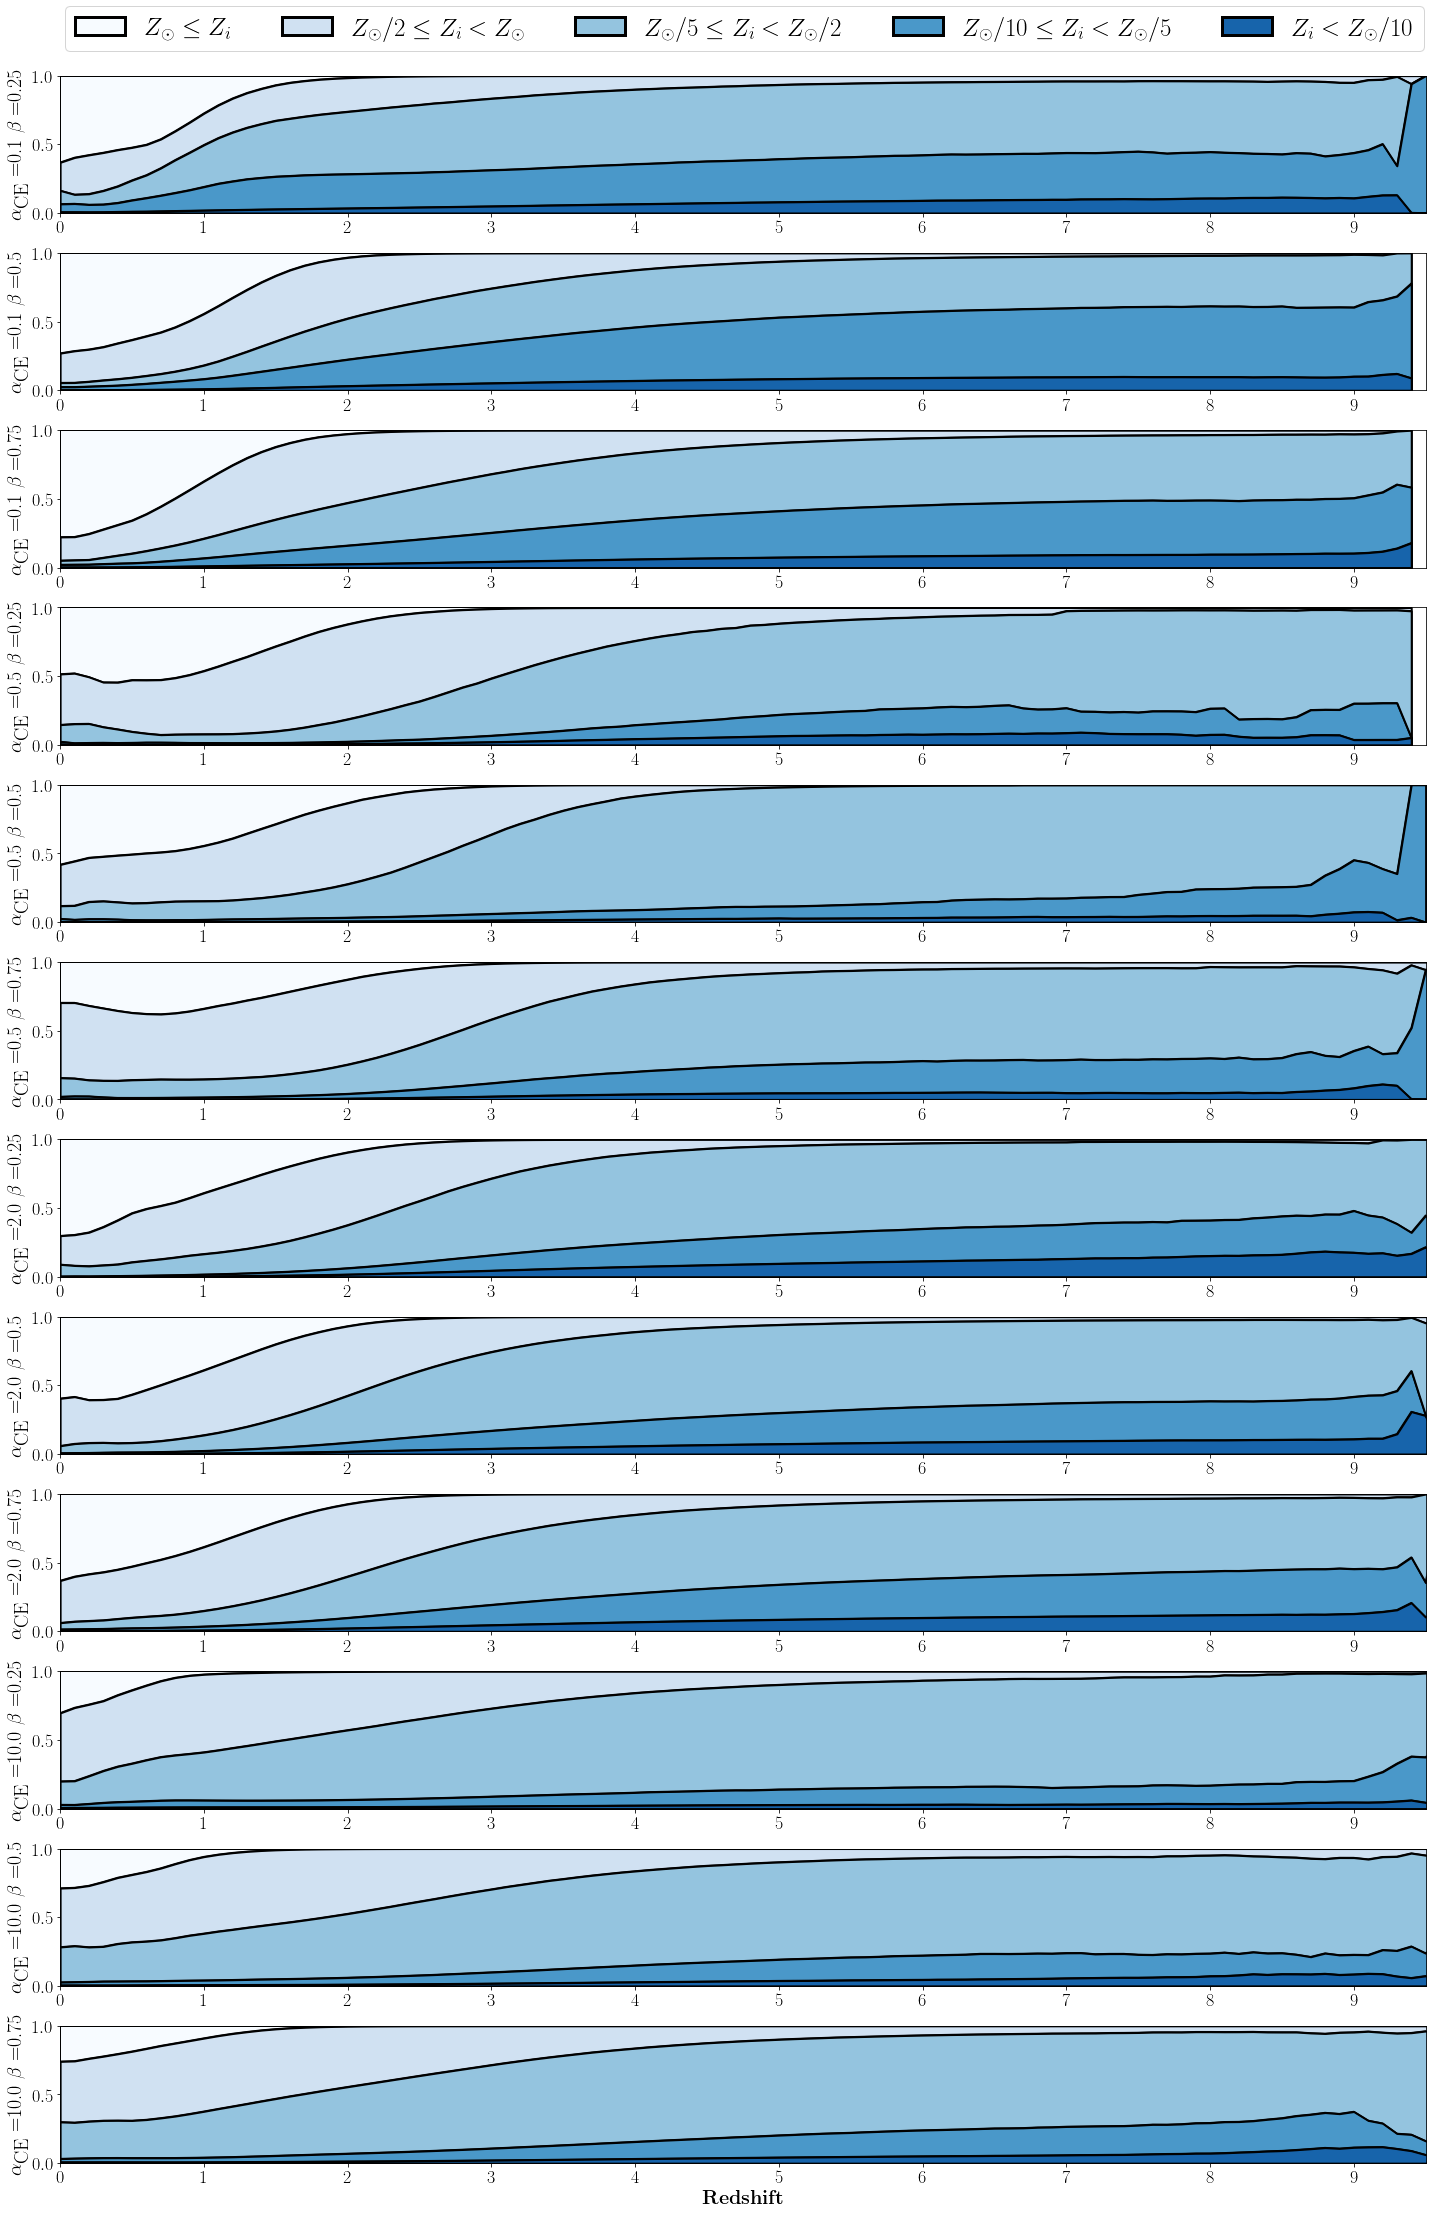

In [40]:
plot_all_rates_by_Z(condensed_paths, alpha_vals, beta_vals, dco_type='BNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))                  

## b) BHNS

<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_ma

/tmp/ipykernel_237602/806317795.py:101: RuntimeWarning: invalid value encountered in true_divide
  axes[axis_counter].fill_between(redshifts[alpha_val][beta_val][bin_key], cum_sums[bin_key]/total_sum, lw=lw, edgecolor='k', y2=np.zeros(len(redshifts[alpha_val][beta_val][bin_key])), facecolor=color, label=Z_labels[index])
/tmp/ipykernel_237602/806317795.py:104: RuntimeWarning: invalid value encountered in true_divide
  axes[axis_counter].plot(redshifts[alpha_val][beta_val][bin_key], cum_sums[bin_key]/total_sum, lw=0.75 * lw, color='k')
/tmp/ipykernel_237602/806317795.py:101: RuntimeWarning: invalid value encountered in true_divide
  axes[axis_counter].fill_between(redshifts[alpha_val][beta_val][bin_key], cum_sums[bin_key]/total_sum, lw=lw, edgecolor='k', y2=np.zeros(len(redshifts[alpha_val][beta_val][bin_key])), facecolor=color, label=Z_labels[index])
/tmp/ipykernel_237602/806317795.py:104: RuntimeWarning: invalid value encountered in true_divide
  axes[axis_counter].plot(redshifts[alpha

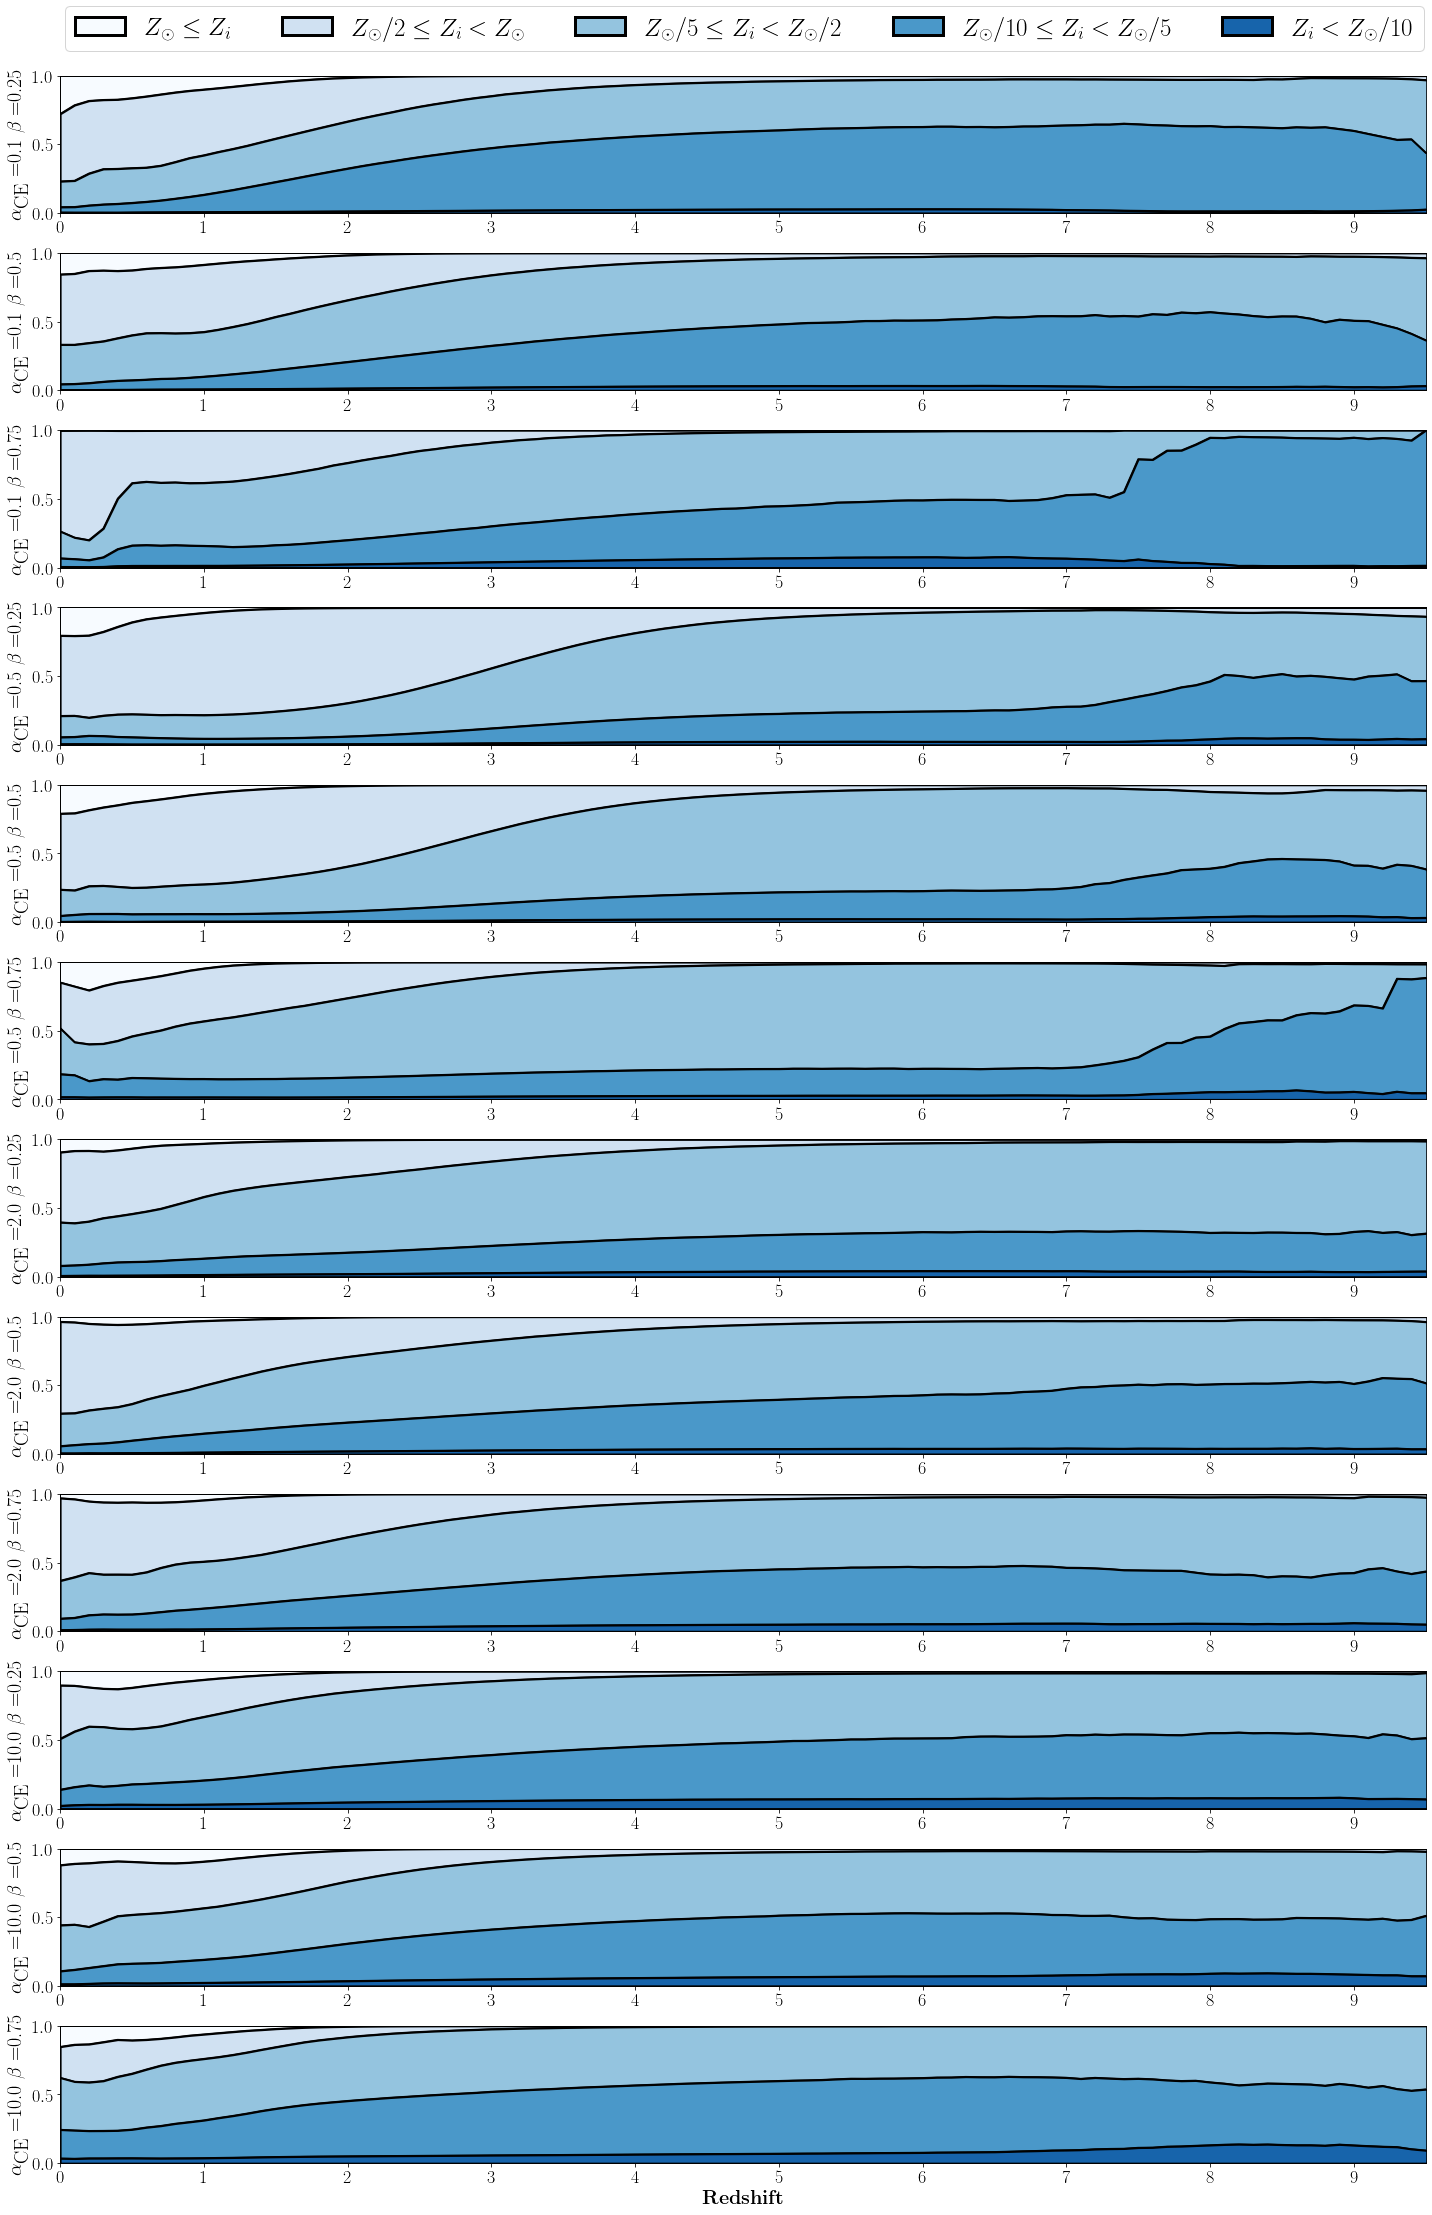

In [41]:
plot_all_rates_by_Z(condensed_paths, alpha_vals, beta_vals, dco_type='BHNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))                  

## BBH)

<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_ma

/tmp/ipykernel_206008/1712999533.py:101: RuntimeWarning: invalid value encountered in true_divide
  axes[axis_counter].fill_between(redshifts[alpha_val][beta_val][bin_key], cum_sums[bin_key]/total_sum, lw=lw, edgecolor='k', y2=np.zeros(len(redshifts[alpha_val][beta_val][bin_key])), facecolor=color, label=Z_labels[index])
/tmp/ipykernel_206008/1712999533.py:104: RuntimeWarning: invalid value encountered in true_divide
  axes[axis_counter].plot(redshifts[alpha_val][beta_val][bin_key], cum_sums[bin_key]/total_sum, lw=0.75 * lw, color='k')
/tmp/ipykernel_206008/1712999533.py:101: RuntimeWarning: invalid value encountered in true_divide
  axes[axis_counter].fill_between(redshifts[alpha_val][beta_val][bin_key], cum_sums[bin_key]/total_sum, lw=lw, edgecolor='k', y2=np.zeros(len(redshifts[alpha_val][beta_val][bin_key])), facecolor=color, label=Z_labels[index])
/tmp/ipykernel_206008/1712999533.py:104: RuntimeWarning: invalid value encountered in true_divide
  axes[axis_counter].plot(redshifts[a

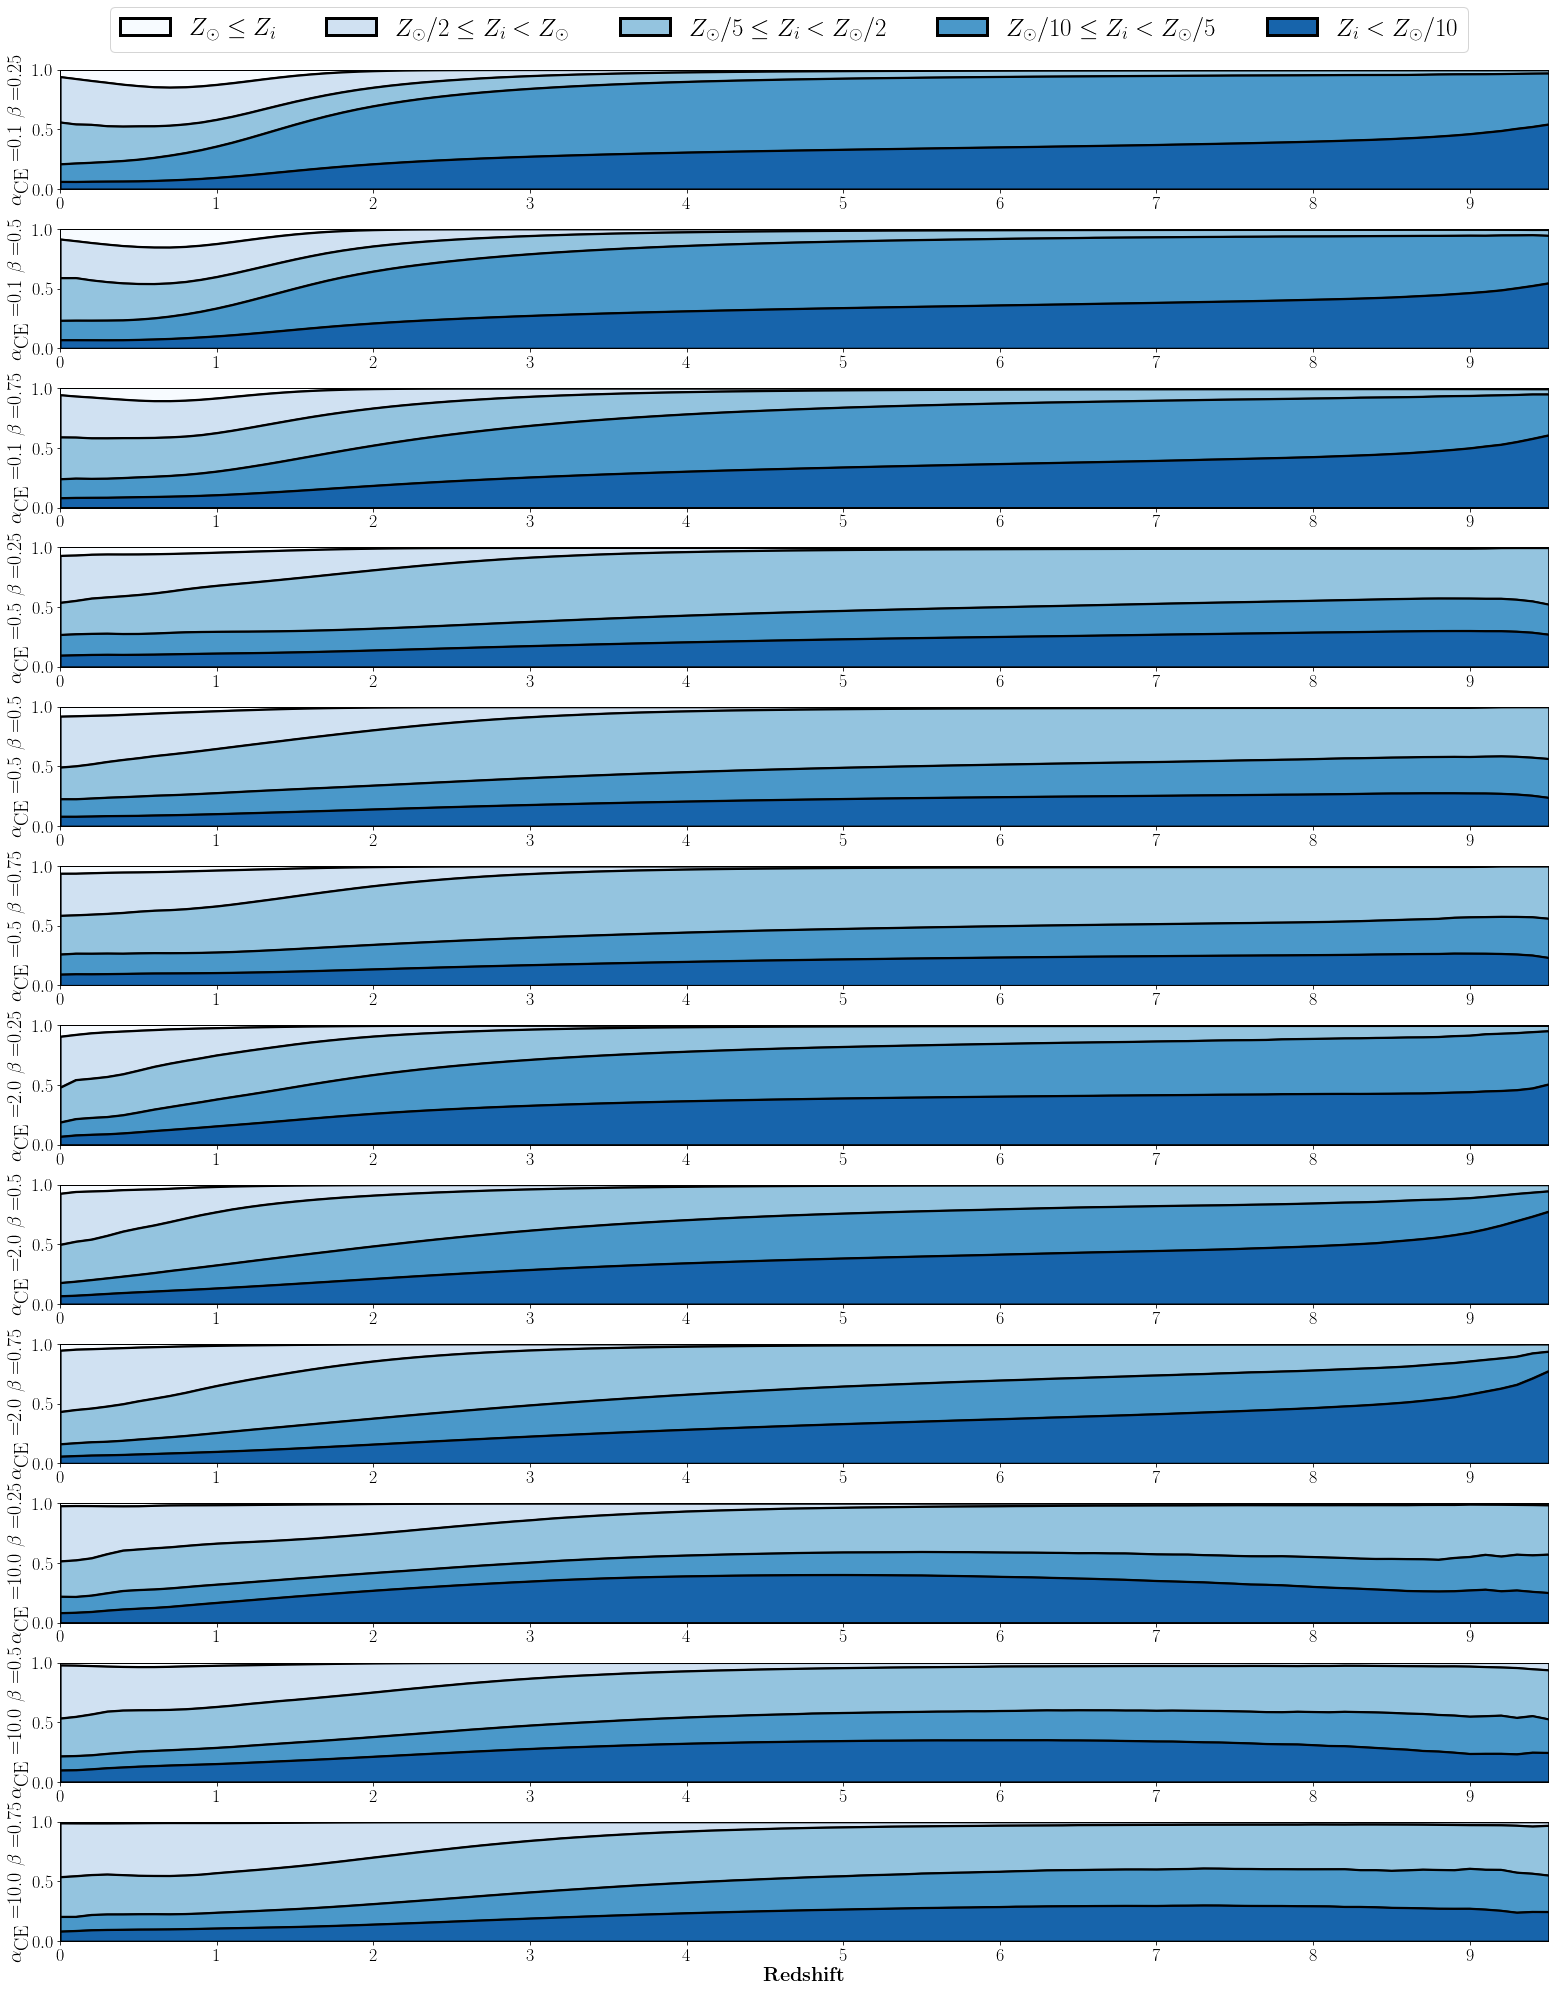

In [12]:
plot_all_rates_by_Z(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))                  

# Formation efficiency distributed with initial metallicity

In [15]:
def plot_formation_rate_per_Z(data, alpha_vals, beta_vals, dco_type, Mlower=5, Mupper=150, binaryFraction=1.0, Amin=0.01, Amax=1000, withinHubbleTime=True, PESSIMISTIC=True, bw='silverman', weight_column = 'mixture_weight'):
    """
    This function plots the formation rate as a function of Z for the given data and DCO type. It will iterate over given
    alpha and beta values and plot the formation rates of their runs' results.

    ...

    Parameters
    ----------
    data : dict
        a two-dimensional dictionary containing the corresponding compas objects for each of the alpha/beta values

    alpha_vals : list
        a one dimensional list containing the alpha_CE values corresponding to the keys of the data dictionary
    
    beta_vals: list 
        a one dimensional list containing the beta values corresponding to the keys of the data dictionary's first dimension

    dco_type: str
        one of 'all', 'BBH', 'BHNS', or 'BNS'; the DCO type that we wish to look at.

    bw: float
        the bandwidth for the KDE that will be calculated for the plot

    Mlower: float
        the lower bound for the mass distribution in the data simulations

    Mupper: float
        the upper bound for the mass distribution in the data simulations

    binaryFraction: float
        the assumed binary fraction
    
    Amin: float
        the lower bound for the initial separation distribution in the data simulations

    Amax: float
        the upper bound for the initial separation distribution in the data simulations
    
    withinHubbleTime: bool
        whether or not the data should be filtered for only dcos that merge within hubble time

    PESSIMISTIC: bool
        whether or not we should filter our DCOs that have formed through a CE event involving a Hertzsprung-gap donor
    
    bw: str/float
        the bandwidth for the KDE; if not float, can be the automatic bandwidth 'silverman'
    """


    # Declare figure and figure size
    plt.figure(figsize=(20, 9))
    plt.yscale('log')
    fs = 20

    # Iterate over the 2D dictionary and plot the formation rate as a function of Z for each of the alpha_CE-beta combinations
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            
            # Get the current compas object
            model_data = data[alpha_val][beta_val]

            # Get the metallicities of the systems and declare an empty formationRate array
            metallicities = model_data.metallicitySystems
            log10metallicities = np.log10(metallicities)

            # Get the total mass evolved in the universe
            model_data_MPZ = model_data.totalMassEvolvedPerZ

            # Calculate a KDE of the metallicity distribution
            kde_grid, num_kde = FFTKDE(bw=bw).fit(log10metallicities, weights=model_data.sw_weights).evaluate()

            # Calculate the formation rate as a function of metallicity = dN_form/dM_SFR (Z)
            formation_rate = num_kde *   (   len(log10metallicities) / np.sum(model_data_MPZ)   )

            # Label axes
            plt.xlabel(r'$\log_{10}(Z_i)$', fontsize=fs+10)
            plt.ylabel(r'$\textbf{\textrm{Formation Efficiency}}  \ \  [\rm{M}_{\odot}^{-1}]$', fontsize=fs+3)
            
            # Bound axes
            plt.xlim([-4, -1.5])
            plt.ylim([10**(-8), 10**(-3)])

            # Adjust tick size
            plt.xticks(fontsize=fs)
            plt.yticks(fontsize=fs)

            # Plot the formation rate
            plt.plot(kde_grid, formation_rate, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val, lw=1)

    # Include legend
    plt.legend(fontsize=fs+5, ncol=4, bbox_to_anchor=(0.5, 1.35), loc='upper center',  markerscale=25) 

    # Show the plot!
    plt.show()

In [8]:
# Put paths into convenient dictionary
data = {}
for alpha_index, alpha_val in enumerate(alpha_vals):
    data[alpha_val] = {}
    for beta_index, beta_val in enumerate(beta_vals):
        print("Making COMPAS object for \t", "alpha = ", alpha_val, " beta = ", beta_val)
        data[alpha_val][beta_val] = ClassCOMPAS.COMPASData(condensed_paths[alpha_val][beta_val], Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
        data[alpha_val][beta_val].setCOMPASDCOmask(types='BBH', withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
        data[alpha_val][beta_val].setCOMPASData()
        data[alpha_val][beta_val].set_sw_weights(weight_column)
        data[alpha_val][beta_val].setGridAndMassEvolved()

Making COMPAS object for 	 alpha =  30  beta =  D
Making COMPAS object for 	 alpha =  30  beta =  M
Making COMPAS object for 	 alpha =  30  beta =  R
Making COMPAS object for 	 alpha =  265  beta =  D
Making COMPAS object for 	 alpha =  265  beta =  M
Making COMPAS object for 	 alpha =  265  beta =  R
Making COMPAS object for 	 alpha =  750  beta =  D
Making COMPAS object for 	 alpha =  750  beta =  M
Making COMPAS object for 	 alpha =  750  beta =  R


In [9]:
# Put paths into convenient dictionary
data_typs = {}
for typ in ('BNS', 'BHNS'):
    data_typs[typ] = {}
    for alpha_index, alpha_val in enumerate(alpha_vals):
        data_typs[typ][alpha_val] = {}
        for beta_index, beta_val in enumerate(beta_vals):
            print("Making COMPAS object for \t", "alpha = ", alpha_val, " beta = ", beta_val)
            data_typs[typ][alpha_val][beta_val] = ClassCOMPAS.COMPASData(condensed_paths[alpha_val][beta_val], Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
            data_typs[typ][alpha_val][beta_val].setCOMPASDCOmask(types=typ, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
            data_typs[typ][alpha_val][beta_val].setCOMPASData()
            data_typs[typ][alpha_val][beta_val].set_sw_weights(weight_column)
            data_typs[typ][alpha_val][beta_val].setGridAndMassEvolved()

Making COMPAS object for 	 alpha =  30  beta =  D
Making COMPAS object for 	 alpha =  30  beta =  M
Making COMPAS object for 	 alpha =  30  beta =  R
Making COMPAS object for 	 alpha =  265  beta =  D
Making COMPAS object for 	 alpha =  265  beta =  M
Making COMPAS object for 	 alpha =  265  beta =  R
Making COMPAS object for 	 alpha =  750  beta =  D
Making COMPAS object for 	 alpha =  750  beta =  M
Making COMPAS object for 	 alpha =  750  beta =  R
Making COMPAS object for 	 alpha =  30  beta =  D
Making COMPAS object for 	 alpha =  30  beta =  M
Making COMPAS object for 	 alpha =  30  beta =  R
Making COMPAS object for 	 alpha =  265  beta =  D
Making COMPAS object for 	 alpha =  265  beta =  M
Making COMPAS object for 	 alpha =  265  beta =  R
Making COMPAS object for 	 alpha =  750  beta =  D
Making COMPAS object for 	 alpha =  750  beta =  M
Making COMPAS object for 	 alpha =  750  beta =  R


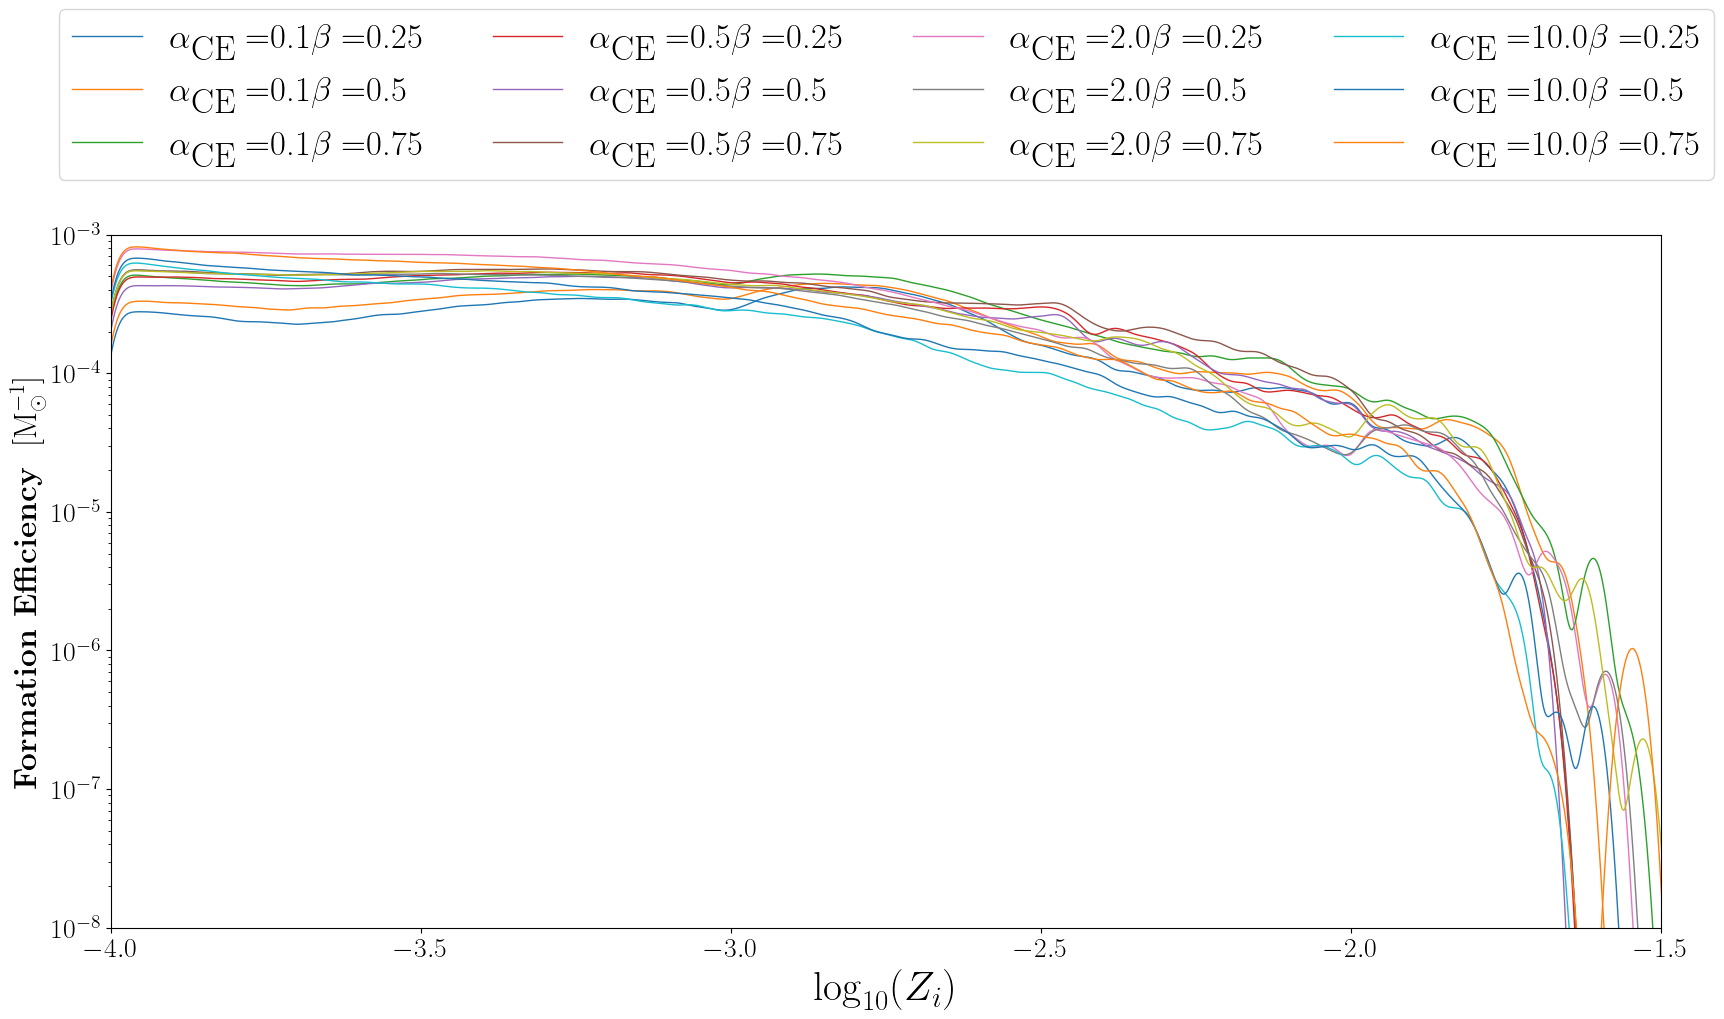

In [16]:
# Plot formation rate all dcos
plot_formation_rate_per_Z(data, alpha_vals, beta_vals, dco_type='BBH', bw=0.015)

In [10]:
def get_formation_rate_per_Z(data, alpha_vals, beta_vals, Mlower=5, Mupper=150, binaryFraction=1.0, Amin=0.01, Amax=1000, withinHubbleTime=True, PESSIMISTIC=True, bw='silverman', weight_column = 'mixture_weight'):
    """
    This function plots the formation rate as a function of Z for the given data and DCO type. It will iterate over given
    alpha and beta values and plot the formation rates of their runs' results.

    ...

    Parameters
    ----------
    data : dict
        a two-dimensional dictionary containing the corresponding compas objects for each of the alpha/beta values

    alpha_vals : list
        a one dimensional list containing the alpha_CE values corresponding to the keys of the data dictionary
    
    beta_vals: list 
        a one dimensional list containing the beta values corresponding to the keys of the data dictionary's first dimension

    dco_type: str
        one of 'all', 'BBH', 'BHNS', or 'BNS'; the DCO type that we wish to look at.

    bw: float
        the bandwidth for the KDE that will be calculated for the plot

    Mlower: float
        the lower bound for the mass distribution in the data simulations

    Mupper: float
        the upper bound for the mass distribution in the data simulations

    binaryFraction: float
        the assumed binary fraction
    
    Amin: float
        the lower bound for the initial separation distribution in the data simulations

    Amax: float
        the upper bound for the initial separation distribution in the data simulations
    
    withinHubbleTime: bool
        whether or not the data should be filtered for only dcos that merge within hubble time

    PESSIMISTIC: bool
        whether or not we should filter our DCOs that have formed through a CE event involving a Hertzsprung-gap donor
    
    bw: str/float
        the bandwidth for the KDE; if not float, can be the automatic bandwidth 'silverman'
    """

    formation_rate = {}
    kde_grid = {}

    # Iterate over the 2D dictionary and plot the formation rate as a function of Z for each of the alpha_CE-beta combinations
    for alpha_val in alpha_vals:
        formation_rate[alpha_val] = {}
        kde_grid[alpha_val] = {}

        for beta_val in beta_vals:
            
            # Get the current compas object
            model_data = data[alpha_val][beta_val]

            # Get the metallicities of the systems and declare an empty formationRate array
            metallicities = model_data.metallicitySystems
            log10metallicities = np.log10(metallicities)

            # Get the total mass evolved in the universe
            model_data_MPZ = model_data.totalMassEvolvedPerZ

            # Calculate a KDE of the metallicity distribution
            kde_grid[alpha_val][beta_val], num_kde = FFTKDE(bw=bw).fit(log10metallicities, weights=model_data.sw_weights).evaluate()

            # Calculate the formation rate as a function of metallicity = dN_form/dM_SFR (Z)
            formation_rate[alpha_val][beta_val] = num_kde *   (   len(log10metallicities) / np.sum(model_data_MPZ)   )
    
    return kde_grid, formation_rate


def only_plot_formation_rate_per_Z(kde_grid, formation_rates, show_legend = True):
    # Declare figure and figure size
    plt.figure(figsize=(20, 9))
    plt.yscale('log')
    fs = 24
    ms = 9
    marker_period = np.linspace(0, 900, num=10, dtype=int)

    # Iterate over the 2D dictionary and plot the formation rate as a function of Z for each of the alpha_CE-beta combinations
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            offset = np.random.randint(1, 30)

            # Label axes
            plt.xlabel(r'$\log_{10}(Z_i)$', fontsize=fs+5)
            plt.ylabel(r'$\textbf{\textrm{Formation Efficiency}}  \ \  [\rm{M}_{\odot}^{-1}]$', fontsize=fs+5)
            
            # Bound axes
            plt.xlim([-4, -1.5])
            plt.ylim([10**(-8), 10**(-3)])

            # Adjust tick size
            plt.xticks(fontsize=fs)
            plt.yticks(fontsize=fs)

            # Plot the formation rate
            plt.plot(kde_grid[alpha_val][beta_val], formation_rates[alpha_val][beta_val], label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val, lw=2, 
                     color=color_grid[alpha_val][beta_val], marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=ms, markevery=marker_period+offset, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)

    # Include legend
    if show_legend:
        plt.legend(fontsize=fs, ncol=4, bbox_to_anchor=(0.48, 1.31), loc='upper center',  markerscale=ms*0.15) 

    # solar metallicity used to aid the reader 
    solar = 0.0142

    text_list = [r'$Z=Z_{\odot}$', r'$Z=Z_{\odot}/2$', \
                     r'$Z=Z_{\odot}/5$',  r'$Z=Z_{\odot}/10$',\
                     r'$Z=0.001$', r'$Z=0.0105$']    
    
    ax = plt.gca()
    for zz_ind, zz in enumerate([np.log10(solar), \
                                    np.log10(0.5*solar),np.log10(0.2*solar), np.log10(0.1*solar), np.log10(0.001),\
                                    np.log10(0.0105)]) :
        ax.plot([zz,zz], [0,1], \
                            c='k',\
                            lw=1.2, alpha=1, linestyle=':', zorder=100)  
        
        # add metallicity values as text to metallicity lines
        ax.text(zz-0.049, 1.2*0.001/1E5, s=text_list[zz_ind], fontsize=fs*0.9, rotation=90, verticalalignment='bottom', zorder=-1)
        
        

    # Show the plot!
    plt.show()

In [11]:
# Plot formation rate all dcos
kde_axis_BBH, formation_rates_BBH = get_formation_rate_per_Z(data, alpha_vals, beta_vals, bw=0.015)
kde_axis_BHNS, formation_rates_BHNS = get_formation_rate_per_Z(data_typs['BHNS'], alpha_vals, beta_vals, bw=0.015)
kde_axis_BNS, formation_rates_BNS = get_formation_rate_per_Z(data_typs['BNS'], alpha_vals, beta_vals, bw=0.015)

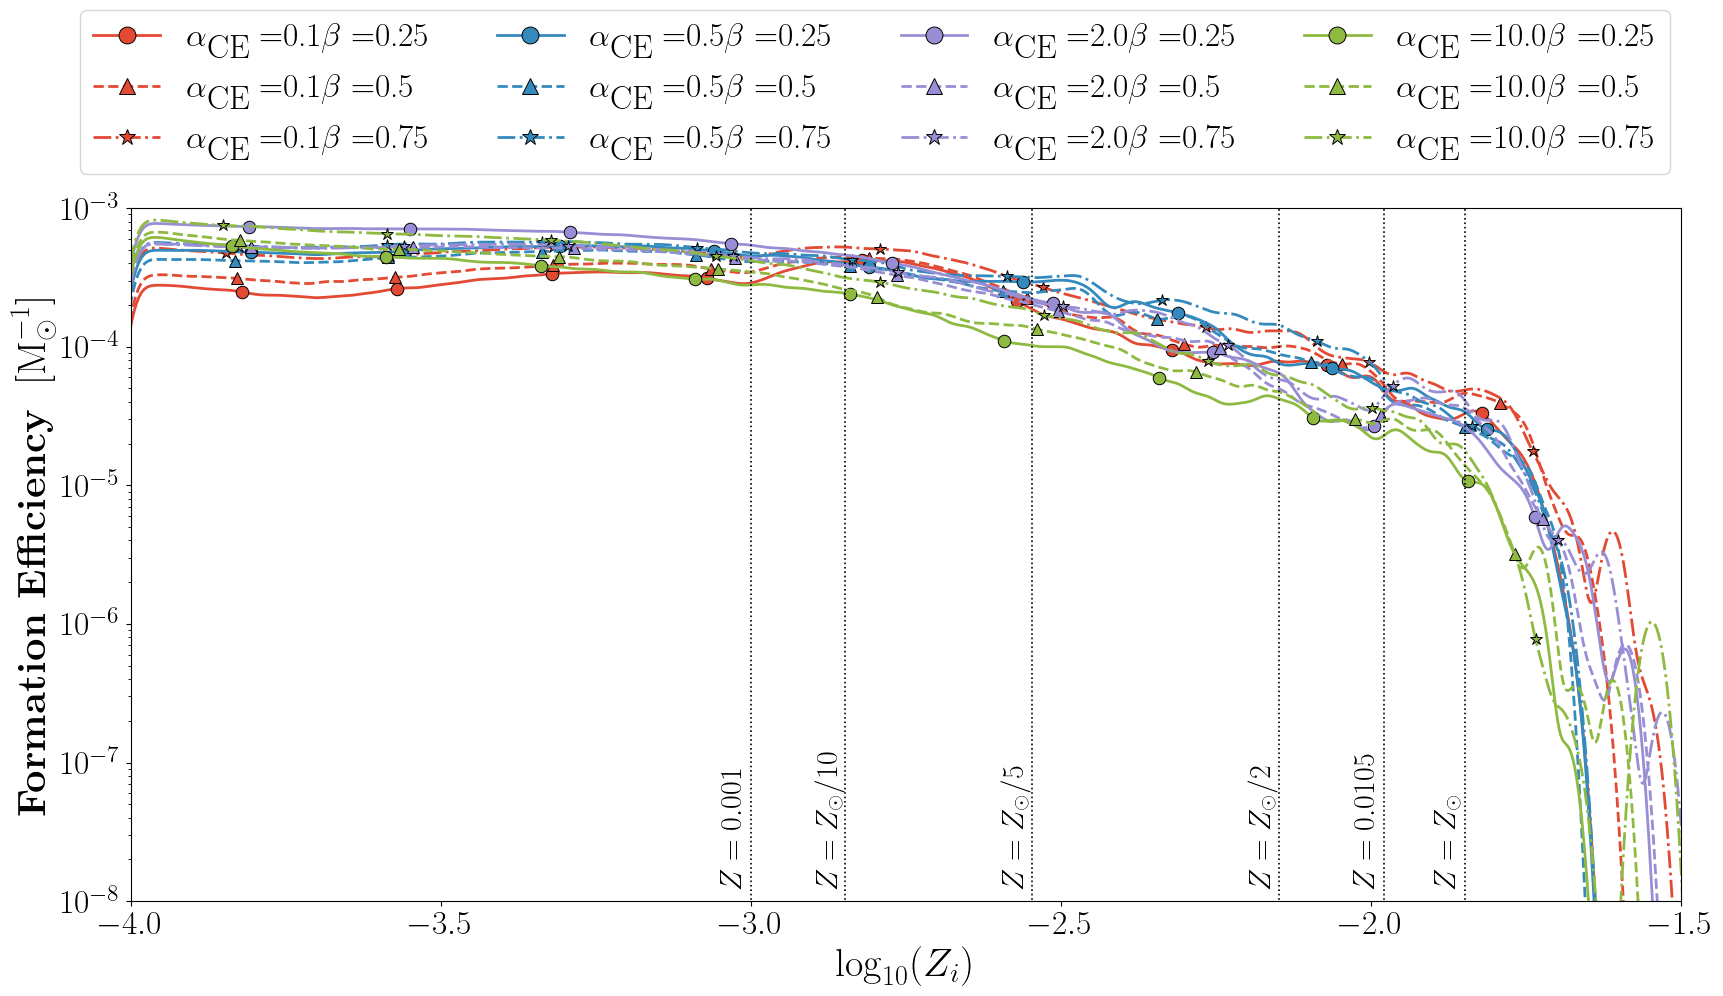

In [ ]:
only_plot_formation_rate_per_Z(kde_axis, formation_rates)

In [93]:
only_plot_formation_rate_per_Z(kde_axis, formation_rates, show_legend=False)

NameError: name 'only_plot_formation_rate_per_Z' is not defined

In [14]:
def only_plot_all_formation_rate_per_Z(kde_grids, formation_rates, show_legend = True):
    # Declare figure and figure size
    plt.figure(figsize=(20, 8))
    ax_top = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=2)
    ax_bl = plt.subplot2grid((3, 3), (2, 0), colspan=1)
    ax_br = plt.subplot2grid((3, 3), (2, 1), colspan=1)
    
    ax_top.set_yscale('log')
    ax_bl.set_yscale('log')
    ax_br.set_yscale('log')
    fs = 24
    ms = 9
    marker_period = np.linspace(0, 900, num=10, dtype=int)

    # Iterate over the 2D dictionary and plot the formation rate as a function of Z for each of the alpha_CE-beta combinations
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            for ax, typ, fs in zip((ax_top, ax_bl, ax_br), ('BBH', 'BHNS', 'BNS'), (17, 7, 7)):
                offset = np.random.randint(1, 30)

                # Label axes
                if typ != 'BBH':  # BHNS, BNS cases
                    ax.set_xlabel(r'$\log_{10}(Z_i)$', fontsize=fs+5)
                    y_pad = 5
                    ms = 7
                    ylims = [10**(-9), 10**(-4)]
                else:  # BBH case
                    y_pad = 0
                    ms = 9
                    ylims = [10**(-8), 10**(-3)]
                ax.set_ylabel(r'$\textbf{\textrm{Formation Efficiency}}  \ \  [\rm{M}_{\odot}^{-1}]$', fontsize=fs+5, labelpad = y_pad)
                
                # Bound axes
                ax.set_xlim([-4, -1.5])
                ax.set_ylim(ylims)

                # Adjust tick size
                plt.xticks(fontsize=fs)
                plt.yticks(fontsize=fs)

                # Plot the formation rate
                ax.plot(kde_grids[typ][alpha_val][beta_val], formation_rates[typ][alpha_val][beta_val], label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val, lw=2, 
                        color=color_grid[alpha_val][beta_val], marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=ms, markevery=marker_period+offset, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)

    # Include legend
    if show_legend:
        plt.legend(fontsize=fs, ncol=4, bbox_to_anchor=(0.48, 1.31), loc='upper center',  markerscale=ms*0.15) 

    # solar metallicity used to aid the reader 
    solar = 0.0142

    text_list = [r'$Z=Z_{\odot}$', r'$Z=Z_{\odot}/2$', \
                     r'$Z=Z_{\odot}/5$',  r'$Z=Z_{\odot}/10$',\
                     r'$Z=0.001$']    
    for ax in (ax_top, ax_bl, ax_br):
        for zz_ind, zz in enumerate([np.log10(solar), \
                                        np.log10(0.5*solar),np.log10(0.2*solar), np.log10(0.1*solar), np.log10(0.001)]):
            ax.plot([zz,zz], [0,1], \
                                c='k',\
                                lw=1.2, alpha=1, linestyle=':', zorder=100)  
            
            # add metallicity values as text to metallicity lines
            if ax == ax_top:
                text_height = 1.2*0.001/1E5
                text_fs = fs
                text_pad = 0.049
            else:
                text_height = 1.2*0.001/1E6
                text_fs = fs - 4
                text_pad = 0.06

            ax.text(zz-text_pad, text_height, s=text_list[zz_ind], fontsize=text_fs+6, rotation=90, verticalalignment='bottom', zorder=100)
        
        

    # Show the plot!
    plt.show()

: 

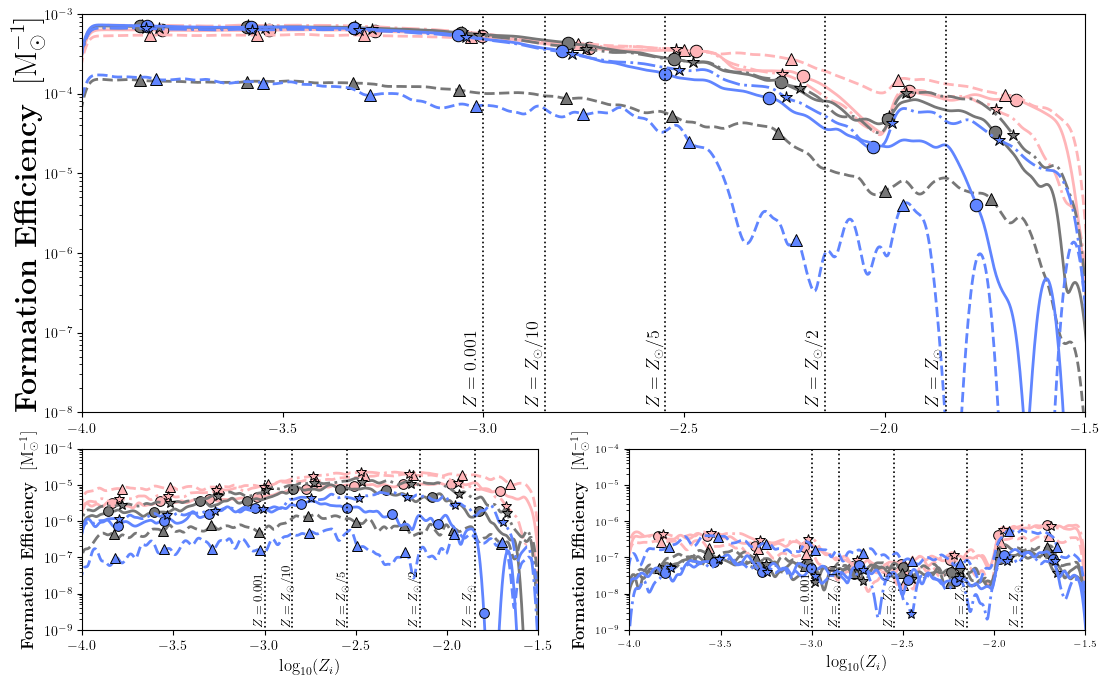

In [13]:
kde_axes = {'BBH': kde_axis_BBH, 'BHNS': kde_axis_BHNS, 'BNS': kde_axis_BNS}
frates = {'BBH': formation_rates_BBH, 'BHNS': formation_rates_BHNS, 'BNS': formation_rates_BNS}
only_plot_all_formation_rate_per_Z(kde_axes, frates, show_legend=False)

In [ ]:
def only_plot_all_formation_rate_per_Z(kde_grid, formation_rates, show_legend = True):
    plt.figure(figsize=(20, 9))
    ax_top = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax_bl = plt.subplot2grid((3, 3), (1, 0), colspan=1)
    ax_br = plt.subplot2grid((3, 3), (1, 1), rowspan=1)

    # Declare figure and figure size
    plt.yscale('log')
    fs = 24
    ms = 9
    marker_period = np.linspace(0, 900, num=10, dtype=int)

    # Iterate over the 2D dictionary and plot the formation rate as a function of Z for each of the alpha_CE-beta combinations
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            offset = np.random.randint(1, 30)

            # Label axes
            plt.xlabel(r'$\log_{10}(Z_i)$', fontsize=fs+5)
            plt.ylabel(r'$\textbf{\textrm{Formation Efficiency}}  \ \  [\rm{M}_{\odot}^{-1}]$', fontsize=fs+5)
            
            # Bound axes
            plt.xlim([-4, -1.5])
            plt.ylim([10**(-8), 10**(-3)])

            # Adjust tick size
            plt.xticks(fontsize=fs)
            plt.yticks(fontsize=fs)

            # Plot the formation rate
            plt.plot(kde_grid[alpha_val][beta_val], formation_rates[alpha_val][beta_val], label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val, lw=2, 
                     color=color_grid[alpha_val][beta_val], marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=ms, markevery=marker_period+offset, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)

    # Include legend
    if show_legend:
        plt.legend(fontsize=fs, ncol=4, bbox_to_anchor=(0.48, 1.31), loc='upper center',  markerscale=ms*0.15) 

    # solar metallicity used to aid the reader 
    solar = 0.0142

    text_list = [r'$Z=Z_{\odot}$', r'$Z=Z_{\odot}/2$', \
                     r'$Z=Z_{\odot}/5$',  r'$Z=Z_{\odot}/10$',\
                     r'$Z=0.001$', r'$Z=0.0105$']    
    
    ax = plt.gca()
    for zz_ind, zz in enumerate([np.log10(solar), \
                                    np.log10(0.5*solar),np.log10(0.2*solar), np.log10(0.1*solar), np.log10(0.001),\
                                    np.log10(0.0105)]) :
        ax.plot([zz,zz], [0,1], \
                            c='k',\
                            lw=1.2, alpha=1, linestyle=':', zorder=100)  
        
        # add metallicity values as text to metallicity lines
        ax.text(zz-0.049, 1.2*0.001/1E5, s=text_list[zz_ind], fontsize=fs*0.9, rotation=90, verticalalignment='bottom', zorder=-1)
        
        

    # Show the plot!
    plt.show()

# Merger rate broken into formation channel

In [84]:
def plot_all_rates_by_formation_channel(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=2, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # Make sure the dco_type is given
    assert dco_type != None, 'dco_type must be given'

    CI_kwargs = {'dco_type': dco_type, 'merger_output_filename': merger_output_filename, 'weight_column': weight_column, 'merges_hubble_time': merges_hubble_time, 'pessimistic_CEE': pessimistic_CEE, 
                        'no_RLOF_after_CEE': no_RLOF_after_CEE, 'max_redshift': max_redshift, 'max_redshift_detection': max_redshift_detection, 'redshift_step': redshift_step, 'z_first_SF': z_first_SF,
                        'use_sampled_mass_ranges': use_sampled_mass_ranges, 'm1_min': m1_min, 'm1_max': m1_max, 'm2_min': m2_min, 'fbin': fbin,
                        'aSF': aSF, 'bSF': bSF, 'cSF': cSF, 'dSF': dSF,
                        'mu0': mu0, 'muz': muz, 'sigma0': sigma0, 'sigmaz': sigmaz, 'alpha': alpha, 
                        'min_logZ': min_logZ, 'max_logZ': max_logZ, 'step_logZ': step_logZ,
                        'sensitivity': sensitivity, 'snr_threshold': snr_threshold, 
                        'Mc_max': Mc_max, 'Mc_step': Mc_step, 'eta_max': eta_max, 'eta_step': eta_step,
                        'snr_max': snr_max, 'snr_step': snr_step,
                        'lognormal': lognormal, 'Zprescription': Zprescription, 'SFRprescription': SFRprescription,
                        'GSMFprescription': GSMFprescription, 'ZMprescription': ZMprescription,
                        'logNormalPrescription': logNormalPrescription}

    # 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)
    channel_types = {1: '(I) Classic', 2: '(II) Only stable', 3: '(III) Single core CE at first mass transfer', 4: '(IV) Double Core CE at first mass transfer', 0: '(V) Other'}
    channel_keys = [1,2,3,4,0]

    # Make dictionaries to put the rates in
    total_merger_rates = {}
    redshifts = {}
    data_chs = {}

    for alpha_val in alpha_vals:

        # Make sub dict for alpha value
        total_merger_rates[alpha_val] = {}
        redshifts[alpha_val] = {}
        data_chs[alpha_val] = {}

        for beta_val in beta_vals:

            # Make sub dict for beta value
            total_merger_rates[alpha_val][beta_val] = {}
            redshifts[alpha_val][beta_val] = {}
            data_chs[alpha_val][beta_val] = {}

            # Get and put data into dicts
            with open(path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val + '/Pickled_Rates/MSSFR_111/' + dco_type + '/rates_and_bootstraps_by_formation_channel.h5', 'rb') as f:
                for ch_key, channel in channel_types.items():                    
                    # Get data
                    h5_data = h5.File(f)
                    try:
                        total_merger_rates[alpha_val][beta_val][channel] = h5_data[channel]['total_merger_rates'][...]
                        redshifts[alpha_val][beta_val][channel] = h5_data[channel]['redshifts'][...]
                        data_chs[alpha_val][beta_val][ch_key] = channel
                    except:
                        print('No data for alpha = ', alpha, ', beta = ', beta, 'channel: ', channel)

    ###########################
    #Start plotting

    # set some constants for the plots
    plt.rc('font', family='serif')
    fs = 20
    num_models = len(alpha_vals) * len(beta_vals)
    fig, axes = plt.subplots(num_models, 1, figsize=(21.7, 27))
    # cmap = plt.get_cmap('Rainbow')

    # Make a dictionary for the colors of the different channels
    colors = {}
    cs = ['#fbb4ae', '#b3cde3', '#ccebc5', '#decbe4', '#fed9a6', '#ffffcc']
    for ch_index, channel in channel_types.items():
        colors[channel] = cs[ch_index]
        # colors[channel] = matplotlib.cm.get_cmap('Deuteranopia')(ch_index / len(channel_types))

    axis_counter = 0
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:

            cum_sums = {}
            total_sums = {}

            index = 0
            for ch_key, channel in list(data_chs[alpha_val][beta_val].items()): 
                # Plot each of the panels, and their confidence intervals
                if index == 0:
                    cum_sum = total_merger_rates[alpha_val][beta_val][channel]
                else:
                    cum_sum = cum_sum + total_merger_rates[alpha_val][beta_val][channel]
                cum_sums[channel] = cum_sum
                if index == len(list(data_chs[alpha_val][beta_val].items())) - 1:
                    total_sum = cum_sum
                index += 1
            
            for ch_key, channel in list(data_chs[alpha_val][beta_val].items()): 
                print('alpha = ', alpha_val, ', beta = ', beta_val, 'channel: ', channel, 'sum:', cum_sums[channel][0]/total_sum[0])


            # Plot!
            index = 0
            for ch_key, channel in list(data_chs[alpha_val][beta_val].items())[::-1]: 
                index = len(channel_types.keys()) - 1 - index
                if axis_counter == 7:
                    axes[axis_counter].fill_between(redshifts[alpha_val][beta_val][channel], cum_sums[channel]/total_sum, lw=lw, edgecolor='k', y2=np.zeros(len(redshifts[alpha_val][beta_val][channel])), facecolor=colors[channel], label=channel)
                else:
                    axes[axis_counter].fill_between(redshifts[alpha_val][beta_val][channel], cum_sums[channel]/total_sum, lw=lw, edgecolor='k', y2=np.zeros(len(redshifts[alpha_val][beta_val][channel])), facecolor=colors[channel])
                axes[axis_counter].plot(redshifts[alpha_val][beta_val][channel], cum_sums[channel]/total_sum, lw=0.75 * lw, color='k')
                axes[axis_counter].set_ylabel(r'$\alpha_{\textrm{CE}}=$'+str(alpha_val)+r' $\beta=$'+str(beta_val), fontsize=fs)
                index += 1
            
            axis_counter+=1
                
    # Label axes of all the plots
    axes[len(alpha_vals) * len(beta_vals) - 1].set_xlabel(r'\textbf{Redshift}', fontsize=fs)        

    # Set lower bounds for the plots
    for axis in axes:
        axis.set_ybound((0,1))
        axis.set_xbound((0,9.5))
    
    for axis in axes:
        axis.tick_params(labelsize=0.9*fs)
        axis.set_xticks(range(0,10))

    # Include legend
    handles, labels = axes[7].get_legend_handles_labels()
    leg = fig.legend(handles[::-1], labels[::-1], fontsize=25, ncol=3, bbox_to_anchor=(0.855, 1.05),  markerscale=25) 
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)

    # Show the plot!
    plt.tight_layout()
    plt.show()

No data for alpha =  -1.77 , beta =  0.75 channel:  (IV) Double Core CE at first mass transfer
No data for alpha =  -1.77 , beta =  0.75 channel:  (IV) Double Core CE at first mass transfer
No data for alpha =  -1.77 , beta =  0.75 channel:  (IV) Double Core CE at first mass transfer
alpha =  0.1 , beta =  0.25 channel:  (I) Classic sum: 0.07510715163602276
alpha =  0.1 , beta =  0.25 channel:  (II) Only stable sum: 0.49398204423093933
alpha =  0.1 , beta =  0.25 channel:  (III) Single core CE at first mass transfer sum: 0.5483026149367676
alpha =  0.1 , beta =  0.25 channel:  (V) Other sum: 1.0
alpha =  0.1 , beta =  0.5 channel:  (I) Classic sum: 0.08988217657731137
alpha =  0.1 , beta =  0.5 channel:  (II) Only stable sum: 0.7090916371598149
alpha =  0.1 , beta =  0.5 channel:  (III) Single core CE at first mass transfer sum: 0.7425655550256376
alpha =  0.1 , beta =  0.5 channel:  (V) Other sum: 1.0
alpha =  0.1 , beta =  0.75 channel:  (I) Classic sum: 0.06285113809078093
alpha =  

/tmp/ipykernel_85810/1734474434.py:113: RuntimeWarning: invalid value encountered in true_divide
  axes[axis_counter].fill_between(redshifts[alpha_val][beta_val][channel], cum_sums[channel]/total_sum, lw=lw, edgecolor='k', y2=np.zeros(len(redshifts[alpha_val][beta_val][channel])), facecolor=colors[channel])
/tmp/ipykernel_85810/1734474434.py:114: RuntimeWarning: invalid value encountered in true_divide
  axes[axis_counter].plot(redshifts[alpha_val][beta_val][channel], cum_sums[channel]/total_sum, lw=0.75 * lw, color='k')
/tmp/ipykernel_85810/1734474434.py:113: RuntimeWarning: invalid value encountered in true_divide
  axes[axis_counter].fill_between(redshifts[alpha_val][beta_val][channel], cum_sums[channel]/total_sum, lw=lw, edgecolor='k', y2=np.zeros(len(redshifts[alpha_val][beta_val][channel])), facecolor=colors[channel])
/tmp/ipykernel_85810/1734474434.py:114: RuntimeWarning: invalid value encountered in true_divide
  axes[axis_counter].plot(redshifts[alpha_val][beta_val][channel], 

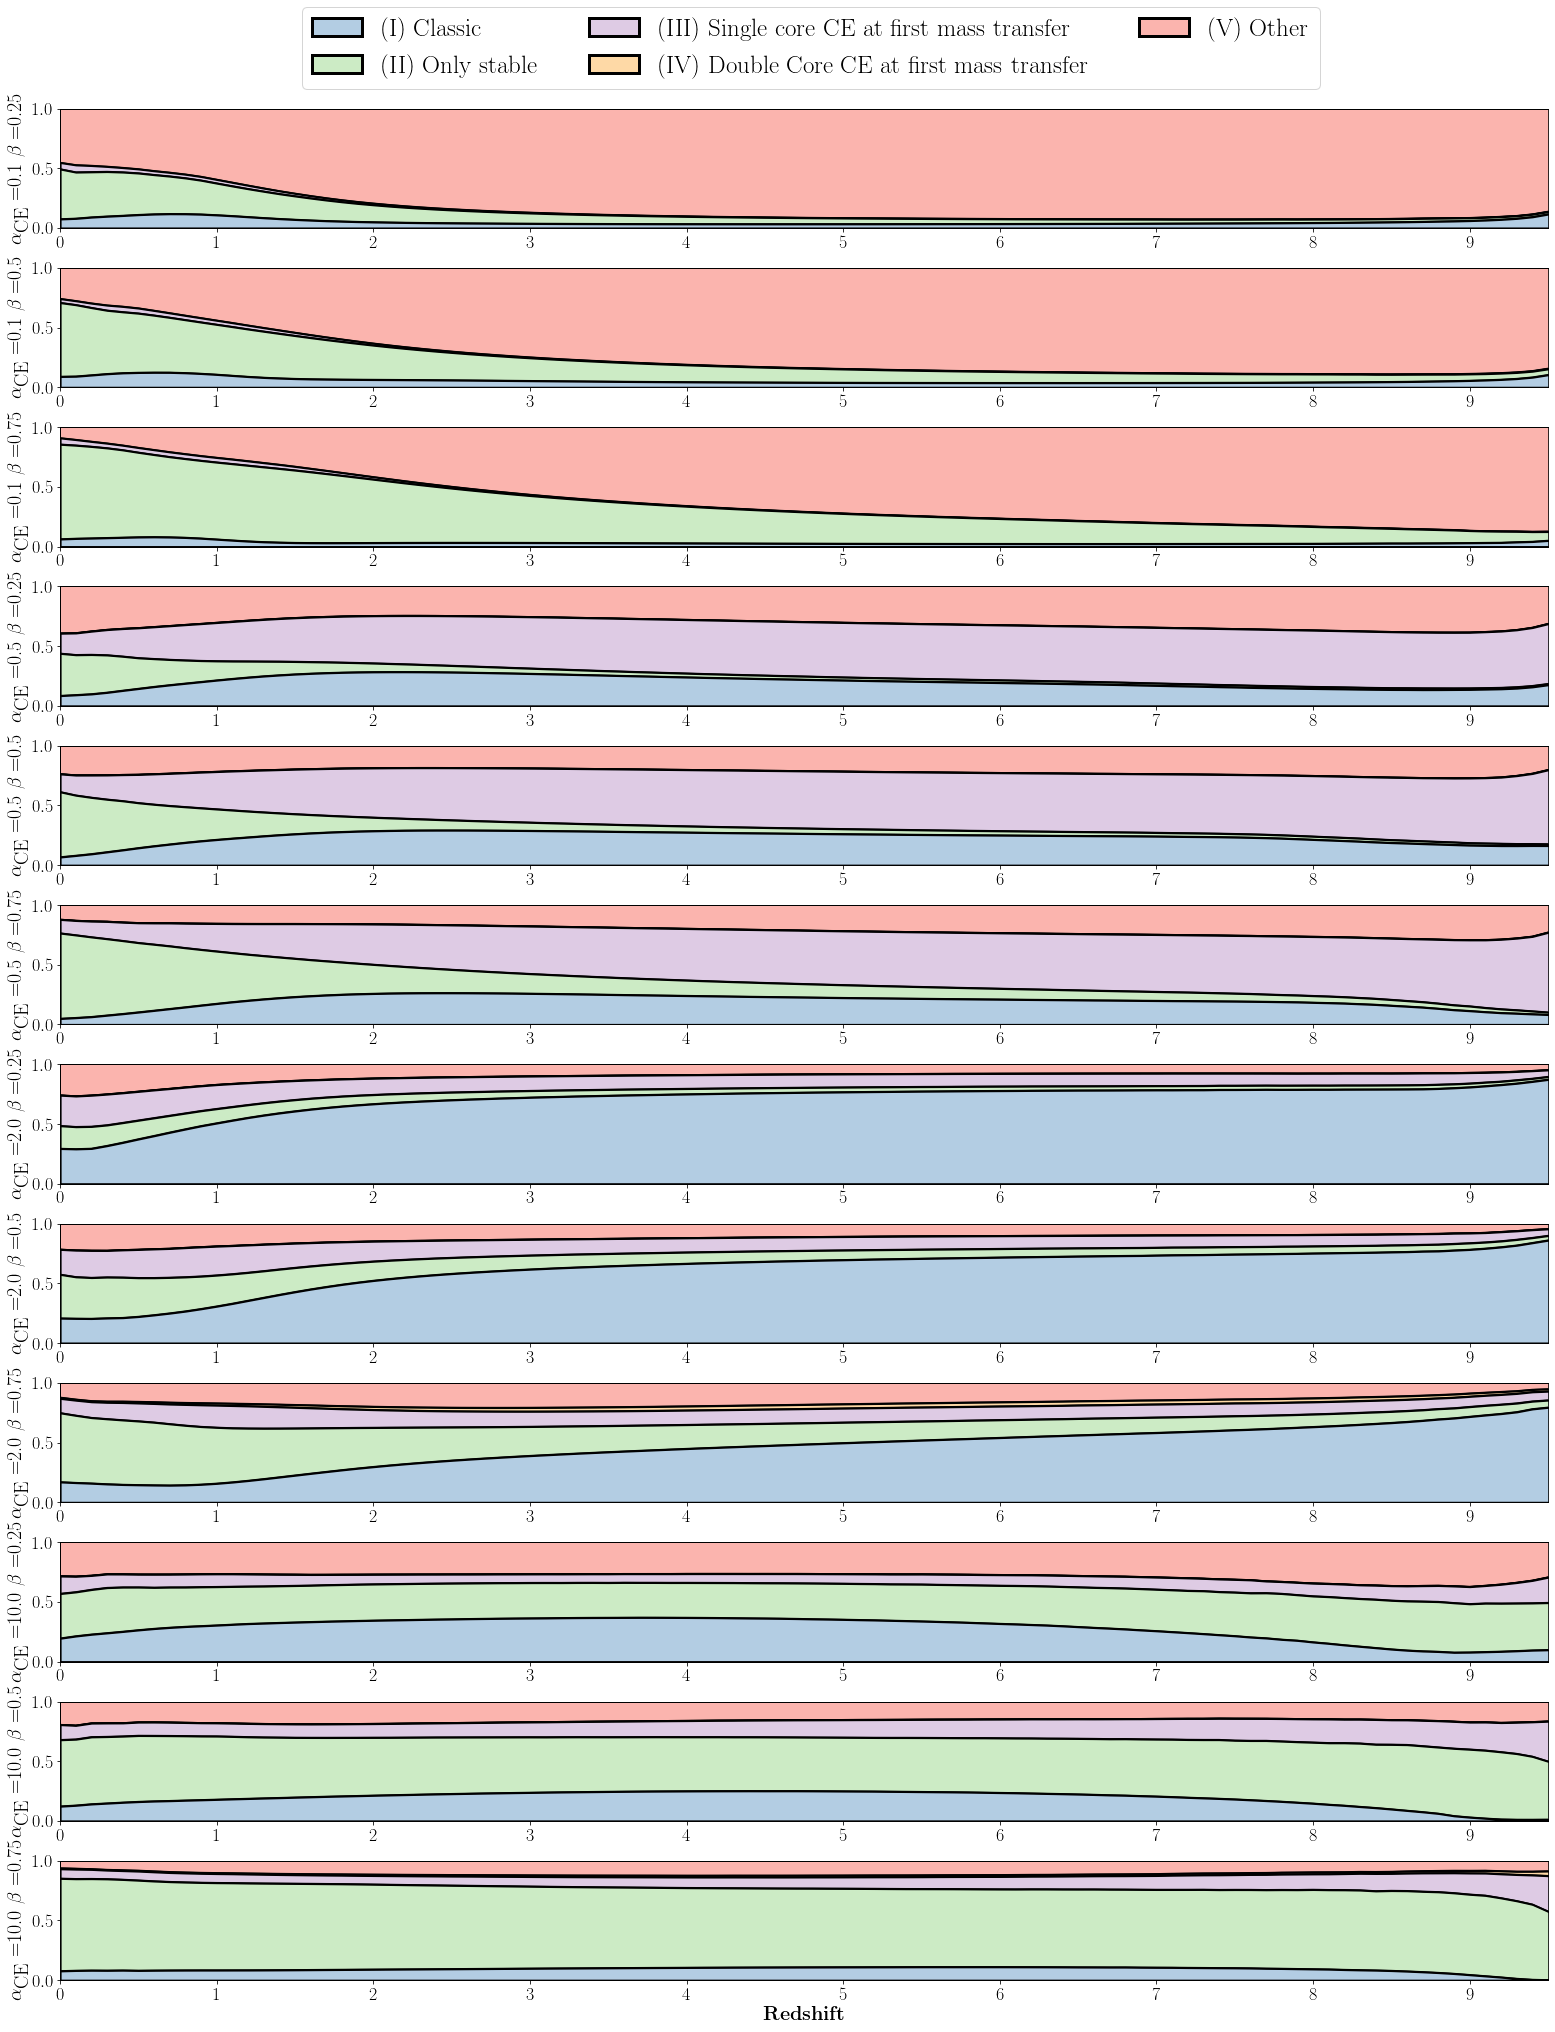

In [85]:
plot_all_rates_by_formation_channel(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step,
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))

# Metallicity Plot

In [69]:
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = 25, second=False, labelpad=None, setMinor=True):
    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
    ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    
    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts


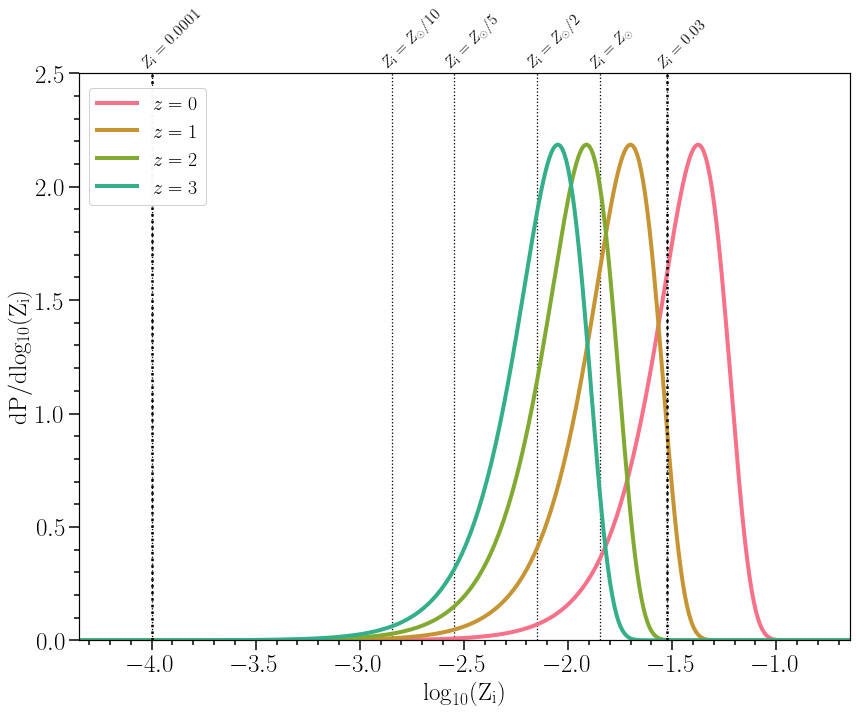

In [77]:
fs = 20
metallicityGrid = np.logspace(-4, -1.5,100)
mssfr = ClassMSSFR.MSSFR(metallicityGrid=metallicityGrid)

#.            FIDUCIAL                    HIGHEST.                        LOWEST 
Zprescription='MZ_GSMF'
SFRprescription='Madau et al. (2017)'
GSMFprescription='Panter et al. (2004) Single'
ZMprescription='Ma et al. (2016)'
logNormalPrescription=None


cm       = plt.get_cmap('viridis')
nColors  = 8+1  #want three colours for three variations (1 used in other plot later)
                    # dont want the brigthest colour hence I add a dummy value.
                    #Should be consistent with figure of metallicity PDFs
mycolors = [cm(x) for x in np.linspace(0,1 , nColors)]

colours  =  [ 'b'                        ,mycolors[0]                   , mycolors[1]       \
             , mycolors[2], mycolors[3]]

solar=0.0142

redshifts = [0, 1, 2, 3, 4, 5, 6, 7]
zcolors       = sns.color_palette("husl", len(redshifts))
redshifts         = [0, 2, 4]
labelsZ = [r'$z=0 $',r'$z=1$', r'$z=2$']
alphas = [1.0, 0.6, 0.3]
redshifts=[0,1,2,3]
zcolors       = sns.color_palette("husl", 7)

fig, axes = plt.subplots(1,1, figsize=(12,10))
zBins = np.logspace(-8,2.,1000)
center = (zBins[1:] + zBins[:-1])/2.
width  = np.diff(np.log10(zBins))

handles1 = []
for nrz, redshift in enumerate(redshifts):
    PDF = np.zeros(len(center))
    mssfr.Zprescription         = Zprescription
    mssfr.SFRprescription       = SFRprescription
    mssfr.logNormalPrescription = logNormalPrescription
    mssfr.GSMFprescription      = GSMFprescription
    mssfr.ZMprescription        = ZMprescription
    #code is done such that we have to do it per metallicity
    for nrZ, Z in enumerate(center):
        Zlower   = zBins[nrZ]
        Zupper   = zBins[nrZ+1]
        PDF[nrZ] = mssfr.returnFractionMZ_GSMF(Zlower, Zupper, [redshift])
    PDF = np.divide(PDF, width)
    label = r'$z=%s$'%redshift #labelsZ[nrz]  #+'  '+'  z='+str(redshift[0])
    l = axes.plot(np.log10(center), PDF,  color=zcolors[redshift], \
            label=label, lw=4, alpha=1, zorder=2)
    handles1.extend(l)


      
    
top_y=2.5

nameX = r'$\rm \log_{10}(Z_{\rm{i}})$'
nameY = r'$\rm dP / dlog_{10}(Z_{\rm{i}}) $'
# nameY = r'${\rm{d}}M_{\rm{SFR}} / \rm{d}\log_{10}(Z/Z_{\odot}) $'
for Z in [0.0001, 0.03]:
    N=10
    if Z==metallicityGrid[0]:
        x=np.linspace(np.log10(min(zBins)), np.log10(Z), N)
    else:
        x=np.linspace(np.log10(Z), np.log10(max(zBins)), N)
    y_low = np.zeros(N)
    y_high = np.ones(N)*(top_y+1)
    
    axes.axvline(np.log10(Z), c='k', linestyle=':', lw=2.5)

    
#again a fudge for second legend
handles2 = []


first_legend = axes.legend(handles=handles1, loc=3,  prop={'size':20}, ncol=1, bbox_to_anchor=(0., .75))   
axes.add_artist(first_legend) 

# plot Z values for some fixed metallicities
text_list = [r'$Z_{\rm{i}}=Z_{\odot}$', r'$Z_{\rm{i}}=Z_{\odot}/2$', \
             r'$Z_{\rm{i}}=Z_{\odot}/5$',  r'$Z_{\rm{i}}=Z_{\odot}/10$',\
             r'$Z_{\rm{i}}=0.0001$', r'$Z_{\rm{i}}=0.03$' , r'$Z_{\rm{i}}=0.002$']    
for zz_ind, zz in enumerate([np.log10(solar), \
                             np.log10(0.5*solar),np.log10(0.2*solar), np.log10(0.1*solar), np.log10(0.0001),\
                             np.log10(0.03)]): #, np.log10(0.002)]) :
    axes.plot([zz,zz], [0,top_y+1], \
                     c='k',\
                     lw=1.3, alpha=1, linestyle=':', zorder=1)   
    axes.text(zz-0.06, top_y+0.01, s=text_list[zz_ind], fontsize=fs-4.5, verticalalignment='bottom', rotation=45)   






axes = layoutAxes(axes, nameX=nameX, nameY=nameY)
axes.set_ylim(bottom=0, top=top_y)
axes.set_xlim(np.log10((10**(-2.5))*solar), np.log10((10**(1.2))*solar))
plt.tight_layout()
plt.savefig('./ZvsPDF.png', dpi=600, bbox_inches='tight')
plt.savefig('./ZvsPDF.pdf',bbox_inches='tight')
plt.show()
plt.close()

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_20631/2650760380.py:37: RuntimeWarning: divide by zero encountered in log10
  widthzRedshift = np.diff(np.log10(zRedshiftBins))


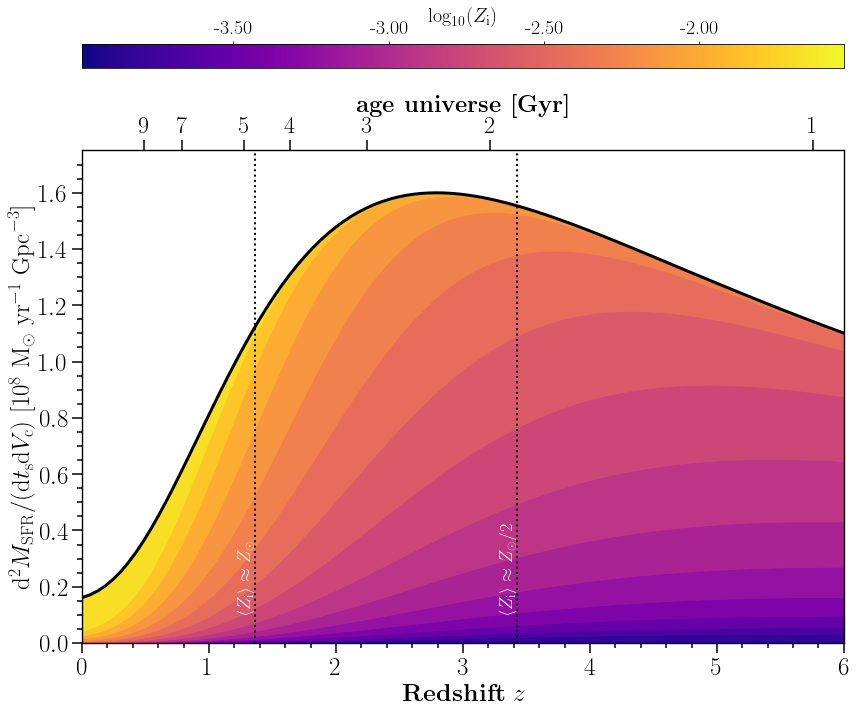

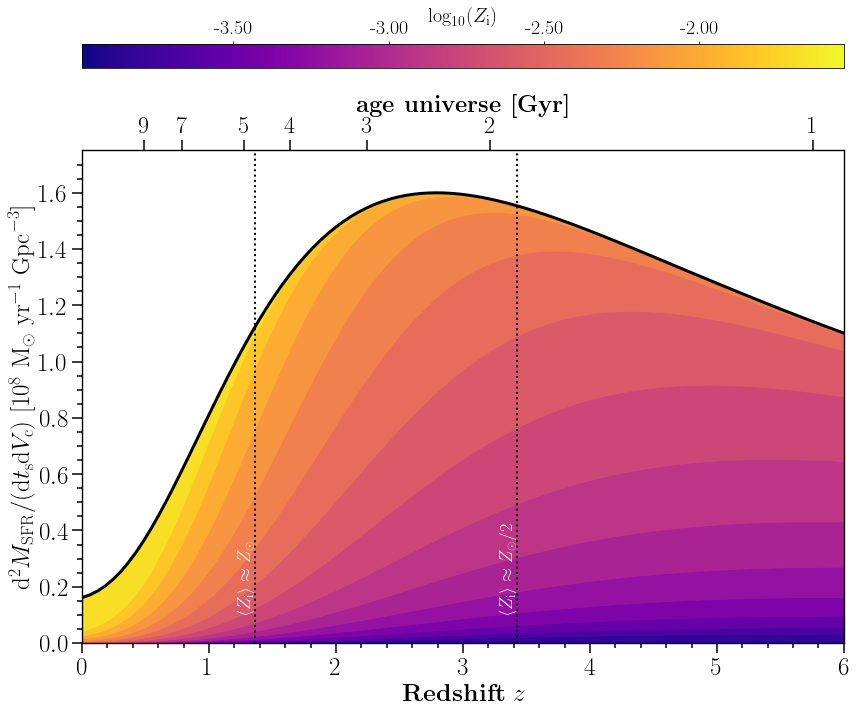

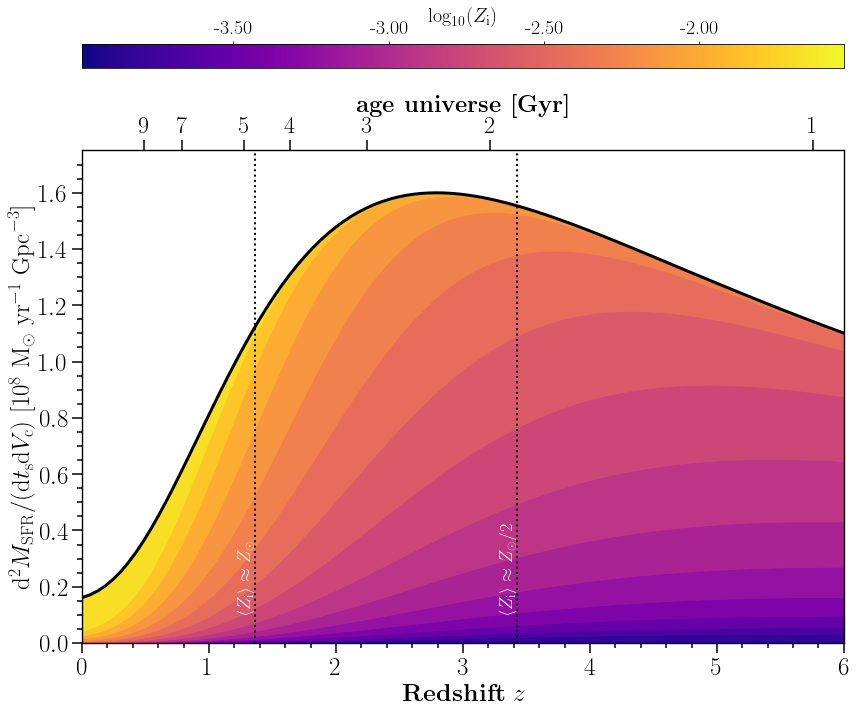

In [89]:

metallicityGrid = np.logspace(-4, -1.5,100)
mssfr = ClassMSSFR.MSSFR(metallicityGrid=metallicityGrid)



#.            FIDUCIAL                    HIGHEST.                        LOWEST 
Zprescription='MZ_GSMF'
SFRprescription='Madau et al. (2017)'
GSMFprescription='Panter et al. (2004) Single'
ZMprescription='Ma et al. (2016)'
logNormalPrescription=None


cm       = plt.get_cmap('viridis')
nColors  = 8+1  #want three colours for three variations (1 used in other plot later)
                    # dont want the brigthest colour hence I add a dummy value.
                    #Should be consistent with figure of metallicity PDFs
mycolors = [cm(x) for x in np.linspace(0,1 , nColors)]

colours  =  [ 'b'                        ,mycolors[0]                   , mycolors[1]       \
             , mycolors[2], mycolors[3]]

solar=0.0142

# redshifts = [0, 1, 2, 3, 4, 5, 6, 7]
# zcolors       = sns.color_palette("husl", len(redshifts))
# redshifts         = [0, 2, 4]
# labelsZ = [r'$z=0 $',r'$z=1$', r'$z=2$']
alphas = [1.0, 0.6, 0.3]

# redshifts=[0,1,2,3]
zcolors       = sns.color_palette("husl", 7)


zRedshiftBins = np.linspace(0,6, 100)
zRedshiftCenter = (zRedshiftBins[1:] + zRedshiftBins[:-1])/2.
widthzRedshift = np.diff(np.log10(zRedshiftBins))

for fixedIndex in [0,1,2]:

    fig, axe = plt.subplots(4,1, figsize=(12,10),\
                           gridspec_kw={"height_ratios":1*np.concatenate(([0.1,0.15, 0.5], 3*np.ones(1)))})
    axes=axe[3]

    zBins = (np.logspace(-10, np.log10(0.5), 100))
    center = (zBins[1:] + zBins[:-1])/2.
    width  = np.diff(np.log10(zBins))
    # Zcolors =  sns.color_palette("plasma", len(Zgrid))
    maskBelow = (zBins <0.001)
    maskAbove = (zBins > 0.03)
    Nbelow = int(sum(maskBelow))
    Nabove = int(sum(maskAbove))
    NinRange = len(zBins) - Nbelow - Nabove

    zMetallicitycolors_       = sns.color_palette("plasma", NinRange)

    zMetallicitycolors = []
    for ll in range(Nbelow):
        zMetallicitycolors.append(zMetallicitycolors_[0]) 


    for ll in range(NinRange):    
        zMetallicitycolors.append(zMetallicitycolors_[ll])
    for ll in range(Nabove):
        zMetallicitycolors.append(zMetallicitycolors_[-1]) 


    handles1 = []



    weightedMetallicity = np.zeros_like(zRedshiftBins)
    normalisation_wMetallicity = np.zeros_like(zRedshiftBins)


    ybottom = np.zeros_like(zRedshiftBins)
    for nrZ, Z in enumerate(center):
        Zlower   = zBins[nrZ]
        Zupper   = zBins[nrZ+1]

        nrL=fixedIndex
        PDF = np.zeros(len(zRedshiftBins))
        mssfr.Zprescription         = Zprescription
        mssfr.SFRprescription       = SFRprescription
        mssfr.logNormalPrescription = logNormalPrescription
        mssfr.GSMFprescription      = GSMFprescription
        mssfr.ZMprescription        = ZMprescription
        #code is done such that we have to do it per metallicity
        for nrz, redshift in enumerate(zRedshiftBins):
            agex      = mssfr.cosmology.age(redshift).value
            PDF[nrz] = mssfr.returnFractionMZ_GSMF(Zlower, Zupper, [redshift])* mssfr.SFR_Strolger(agex)

        weightedMetallicity += Z*PDF
        normalisation_wMetallicity += PDF 

        if nrL==0:
            label = False #r'$z=%s$'%redshift #labelsZ[nrz]  #+'  '+'  z='+str(redshift[0])
            ll    = True
        else:
            label = None
            ll    = False

        axes.fill_between(zRedshiftBins, ybottom,  ybottom+(PDF/1E8),  color=zMetallicitycolors[nrZ], \
                label=label, alpha=1,  zorder=2)
        ybottom += PDF / 1E8

    axes.plot(zRedshiftBins, ybottom, color='k', lw=3, zorder=4)


    top_y=1.75

    # axes layout
    nameX = r'\textbf{Redshift} $z$'
    nameY = r'$ {\rm{d}}^2M_{\rm{SFR}}/({\rm{d}}t_{{\rm{s}}}{\rm{d}}V_{\rm{c}}) \   [10^8\ {\rm{M}}_{\odot}\  {\rm{yr}}^{-1}\ {\rm{Gpc}}^{-3}]$'



    axes = layoutAxes(axes, nameX=nameX, nameY=nameY)
    axes.set_ylim(bottom=0, top=top_y)
    axes.set_xlim(0,6)

    averageZ_perRedshift = weightedMetallicity / normalisation_wMetallicity

    ################# SECOND X-AXIS with AGE #################
    axes2  = axes.twiny()
    # second x-axis for age
    nameX2 = r'\textbf{age universe [Gyr]}'
    # axes2.xaxis.labelpad = 20
    axes2.set_xlabel(nameX2, fontsize=fs+4)
    axes2.tick_params(labelsize=fs+4)
    layoutAxes(axes2, nameX=nameX2, nameY=None, fontsize=fs+4, second=False, labelpad=None, setMinor=False)
    axes2.set_xlim(0,6)


    redshifts = np.linspace(0,6,100)
    #strolger works in age not redshift
    ages      = mssfr.cosmology.age(redshifts).value
    #find nearest redshift to age
    agelabels = np.array([1,2,3,4,5,7, 9]) #Gyr
    ageUniverse = mssfr.cosmology.age(0)
    redshiftTicks = np.zeros(len(agelabels))
    for nr, age in enumerate(agelabels):
        distance = np.abs(ages-age)
        ind      = np.where(distance==np.min(distance))[0][0]
        redshiftTicks[nr] =  redshifts[ind]

    axes2.set_xticks(redshiftTicks)
    axes2.set_xticklabels(agelabels)
    # second x-axis for age
    nameX2 = r'\textbf{age universe [Gyr]}'
    # axes2.xaxis.labelpad = 20
    axes2.set_xlabel(nameX2, fontsize=fs+4)
    axes2.tick_params(labelsize=fs+4)
    layoutAxes(axes2, nameX=nameX2, nameY=None, fontsize=fs+4, setMinor=False)
    axes2.set_xlim(0,6)
    ##################################################


    ############ COLOR BAR ###########
    zBins = (np.logspace(-4, np.log10(0.03), 100))
    center = (zBins[1:] + zBins[:-1])/2.
    width  = np.diff(np.log10(zBins))
    xx = center
    # nonvalues = xx-100

    axe[0].axis('off')
    axe[2].axis('off')
    cm = plt.cm.get_cmap('plasma')
    sc = axe[3].scatter(np.log10(xx), np.log10(xx), c=np.log10(xx), vmin=min(np.log10(center)), vmax=max(np.log10(center)), s=35, cmap=cm)
    cbar = fig.colorbar(sc, cax=axe[1], orientation='horizontal' , format="%.2f")#, boundaries=np.logspace(np.log10(min(center)),max(np.log10(center)),5))#orientation="horizontal", pad=0.2)
    cbar.ax.tick_params(labelsize=20, labeltop=True, labelbottom=False, bottom=False, top=True)
    axe[0].set_title(label=r'$\log_{10}(Z_{\rm{i}})$', size=20)
    #################################




    ######### make av Metallicity lines ##########
    ind_solar, ind_0_5solar, ind_0_2solar, ind_0_1solar, ind_0_001 = 5*[1000]   # start with 1000, we do not plot the line if we never reach this average Z
    for ind_avZi, avZi in enumerate(averageZ_perRedshift):
        if avZi >= solar:
            ind_solar = ind_avZi
        if avZi >= solar/2.:
            ind_0_5solar = ind_avZi
        if avZi >= solar/5.:
            ind_0_2solar = ind_avZi 
        if avZi >= solar/10.:
            ind_0_1solar = ind_avZi   
        if avZi >= 0.001:
            ind_0_001 = ind_avZi   
    text_list = [r'$\langle Z_{\rm{i}} \rangle \approx Z_{\odot}$', \
                 r'$\langle Z_{\rm{i}} \rangle \approx Z_{\odot}/2$', \
                 r'$\langle Z_{\rm{i}} \rangle \approx Z_{\odot}/5$', \
                 r'$\langle Z_{\rm{i}} \rangle \approx Z_{\odot}/10$',\
                 r'$\langle Z_{\rm{i}} \rangle \approx 0.001$'] 
    for nr_i, ind_ in enumerate([ind_solar, ind_0_5solar, ind_0_2solar, ind_0_1solar, ind_0_001]): 
        if ind_<99: # the values of 1000 will not be plotted 
            xx = zRedshiftCenter[ind_]
            yy_text = (normalisation_wMetallicity[ind_] + normalisation_wMetallicity[ind_+1] ) / 2
            yy_text/=1E8
            if yy_text>= 1.1:
                axes.text(x=xx, y=0.1, s=text_list[nr_i], fontsize=18, rotation=90, va='bottom', ha='right', color='white')

            else:
                axes.text(x=xx, y=yy_text+0.1, s=text_list[nr_i], fontsize=18, rotation=90, va='bottom', ha='right')

            axes.plot([xx,xx], [0,top_y], lw=2, linestyle=':', c='k')



    #################################


    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    plt.close()


# Delay time contributions

In [146]:
def plot_all_rates_by_delay_time(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=2, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # Make sure the dco_type is given
    assert dco_type != None, 'dco_type must be given'

    CI_kwargs = {'dco_type': dco_type, 'merger_output_filename': merger_output_filename, 'weight_column': weight_column, 'merges_hubble_time': merges_hubble_time, 'pessimistic_CEE': pessimistic_CEE, 
                        'no_RLOF_after_CEE': no_RLOF_after_CEE, 'max_redshift': max_redshift, 'max_redshift_detection': max_redshift_detection, 'redshift_step': redshift_step, 'z_first_SF': z_first_SF,
                        'use_sampled_mass_ranges': use_sampled_mass_ranges, 'm1_min': m1_min, 'm1_max': m1_max, 'm2_min': m2_min, 'fbin': fbin,
                        'aSF': aSF, 'bSF': bSF, 'cSF': cSF, 'dSF': dSF,
                        'mu0': mu0, 'muz': muz, 'sigma0': sigma0, 'sigmaz': sigmaz, 'alpha': alpha, 
                        'min_logZ': min_logZ, 'max_logZ': max_logZ, 'step_logZ': step_logZ,
                        'sensitivity': sensitivity, 'snr_threshold': snr_threshold, 
                        'Mc_max': Mc_max, 'Mc_step': Mc_step, 'eta_max': eta_max, 'eta_step': eta_step,
                        'snr_max': snr_max, 'snr_step': snr_step,
                        'lognormal': lognormal, 'Zprescription': Zprescription, 'SFRprescription': SFRprescription,
                        'GSMFprescription': GSMFprescription, 'ZMprescription': ZMprescription,
                        'logNormalPrescription': logNormalPrescription}

    # 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)
    t_bins = [[-1, 100], [100, 500], [500, 1000], [1000, 5000], [5000, 10E5]][::-1]
    t_labels = [r'$t_\textrm{delay}<100 \textrm{ Myr}$', r'$100 \textrm{ Myr} \leq t_\textrm{delay} < 500 \textrm{ Myr}$', r'$500 \textrm{ Myr} \leq t_\textrm{delay} < 1000 \textrm{ Myr}$', r'$1000 \textrm{ Myr} \leq t_\textrm{delay} < 5000 \textrm{ Myr}$', r'$5000 \textrm{ Myr} \leq t_\textrm{delay}$'][::-1]
    bin_strs = {}

    # Make dictionaries to put the rates in
    total_merger_rates = {}
    redshifts = {}

    for alpha_val in alpha_vals:

        # Make sub dict for alpha value
        total_merger_rates[alpha_val] = {}
        redshifts[alpha_val] = {}
        bin_strs[alpha_val] = {}

        for beta_val in beta_vals:

            # Make sub dict for beta value
            total_merger_rates[alpha_val][beta_val] = {}
            redshifts[alpha_val][beta_val] = {}
            bin_strs[alpha_val][beta_val] = []

            # Get and put data into dicts
            with open(path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val + '/Pickled_Rates/MSSFR_111/' + dco_type + '/rates_and_bootstraps_by_delay_time.h5', 'rb') as f:
                for t_bin in t_bins:
                    bin_str = 'delay_time_in_'+str(t_bin[0])+'_'+str(t_bin[1])
                    bin_strs[alpha_val][beta_val].append(bin_str)
                    
                    # Get data
                    h5_data = h5.File(f)
                    print(h5_data[bin_str].keys())
                    total_merger_rates[alpha_val][beta_val][bin_str] = h5_data[bin_str]['total_merger_rates'][...]
                    redshifts[alpha_val][beta_val][bin_str] = h5_data[bin_str]['redshifts'][...]

    ###########################
    #Start plotting

    # set some constants for the plots
    plt.rc('font', family='serif')
    fs = 20
    num_models = len(alpha_vals) * len(beta_vals)
    fig, axes = plt.subplots(num_models, 1, figsize=(21.7, 27))
    cmap = plt.get_cmap('Reds')

    axis_counter = 0
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:

            cum_sums = {}
            total_sums = {}

            for t_index, t_bin in enumerate(t_bins):
                # Plot each of the panels, and their confidence intervals
                bin_key = bin_strs[alpha_val][beta_val][t_index]
                if t_index == 0:
                    cum_sum = total_merger_rates[alpha_val][beta_val][bin_key]
                else:
                    cum_sum = cum_sum + total_merger_rates[alpha_val][beta_val][bin_key]
                cum_sums[bin_key] = cum_sum
                if t_index == len(t_bins) - 1:
                    total_sum = cum_sum

            # Plot!
            for t_index, t_bin in enumerate(t_bins[::-1]):
                color = cmap(0.1 + 0.9 * t_index / (len(t_bins)))
                index = len(t_bins) - 1 - t_index
                bin_key = bin_strs[alpha_val][beta_val][index]
                if axis_counter == 0:
                    axes[axis_counter].fill_between(redshifts[alpha_val][beta_val][bin_key], cum_sums[bin_key]/total_sum, lw=lw, edgecolor='k', y2=np.zeros(len(redshifts[alpha_val][beta_val][bin_key])), facecolor=color, label=t_labels[index])
                else:
                    axes[axis_counter].fill_between(redshifts[alpha_val][beta_val][bin_key], cum_sums[bin_key]/total_sum, lw=lw, edgecolor='k', y2=np.zeros(len(redshifts[alpha_val][beta_val][bin_key])), facecolor=color)
                axes[axis_counter].plot(redshifts[alpha_val][beta_val][bin_key], cum_sums[bin_key]/total_sum, lw=0.75 * lw, color='k')
                axes[axis_counter].set_ylabel(r'$\alpha_{\textrm{CE}}=$'+str(alpha_val)+r' $\beta=$'+str(beta_val), fontsize=fs)
            
            axis_counter+=1
                
    # Label axes of all the plots
    axes[len(alpha_vals) * len(beta_vals) - 1].set_xlabel(r'\textbf{Redshift}', fontsize=fs)        

    # Set lower bounds for the plots
    for axis in axes:
        axis.set_ybound((0,1))
        axis.set_xbound((0,9.5))
    
    for axis in axes:
        axis.tick_params(labelsize=0.9*fs)
        axis.set_xticks(range(0,10))

    # renderer = fig.canvas.get_renderer()
    # shift = max([t.get_window_extent(renderer=renderer).width for t in leg.get_texts()])
    # for t in leg.get_texts():
    #     t.set_ha('right') # ha is alias for horizontalalignment
    #     t.set_position((shift,0))

    order = [0, 4, 1, 2, 3]
    handles, labels = axes[0].get_legend_handles_labels()
    leg = fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=25, ncol=4, bbox_to_anchor=(1.0, 1.06),  markerscale=25)



    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)

    # Show the plot!
    plt.tight_layout()
    plt.show()

<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_ma

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_20631/1033066443.py:100: RuntimeWarning: invalid value encountered in true_divide
  axes[axis_counter].fill_between(redshifts[alpha_val][beta_val][bin_key], cum_sums[bin_key]/total_sum, lw=lw, edgecolor='k', y2=np.zeros(len(redshifts[alpha_val][beta_val][bin_key])), facecolor=color, label=t_labels[index])
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_20631/1033066443.py:103: RuntimeWarning: invalid value encountered in true_divide
  axes[axis_counter].plot(redshifts[alpha_val][beta_val][bin_key], cum_sums[bin_key]/total_sum, lw=0.75 * lw, color='k')
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_20631/1033066443.py:100: RuntimeWarning: invalid value encountered in true_divide
  axes[axis_counter].fill_between(redshifts[alpha_val][beta_val][bin_key], cum_sums[bin_key]/total_sum, lw=lw, edgecolor='k', y2=np.zeros(len(redshifts[alpha_val][beta_val][bin_key])), facecolor=color, label=t_labels[index])
/var/f

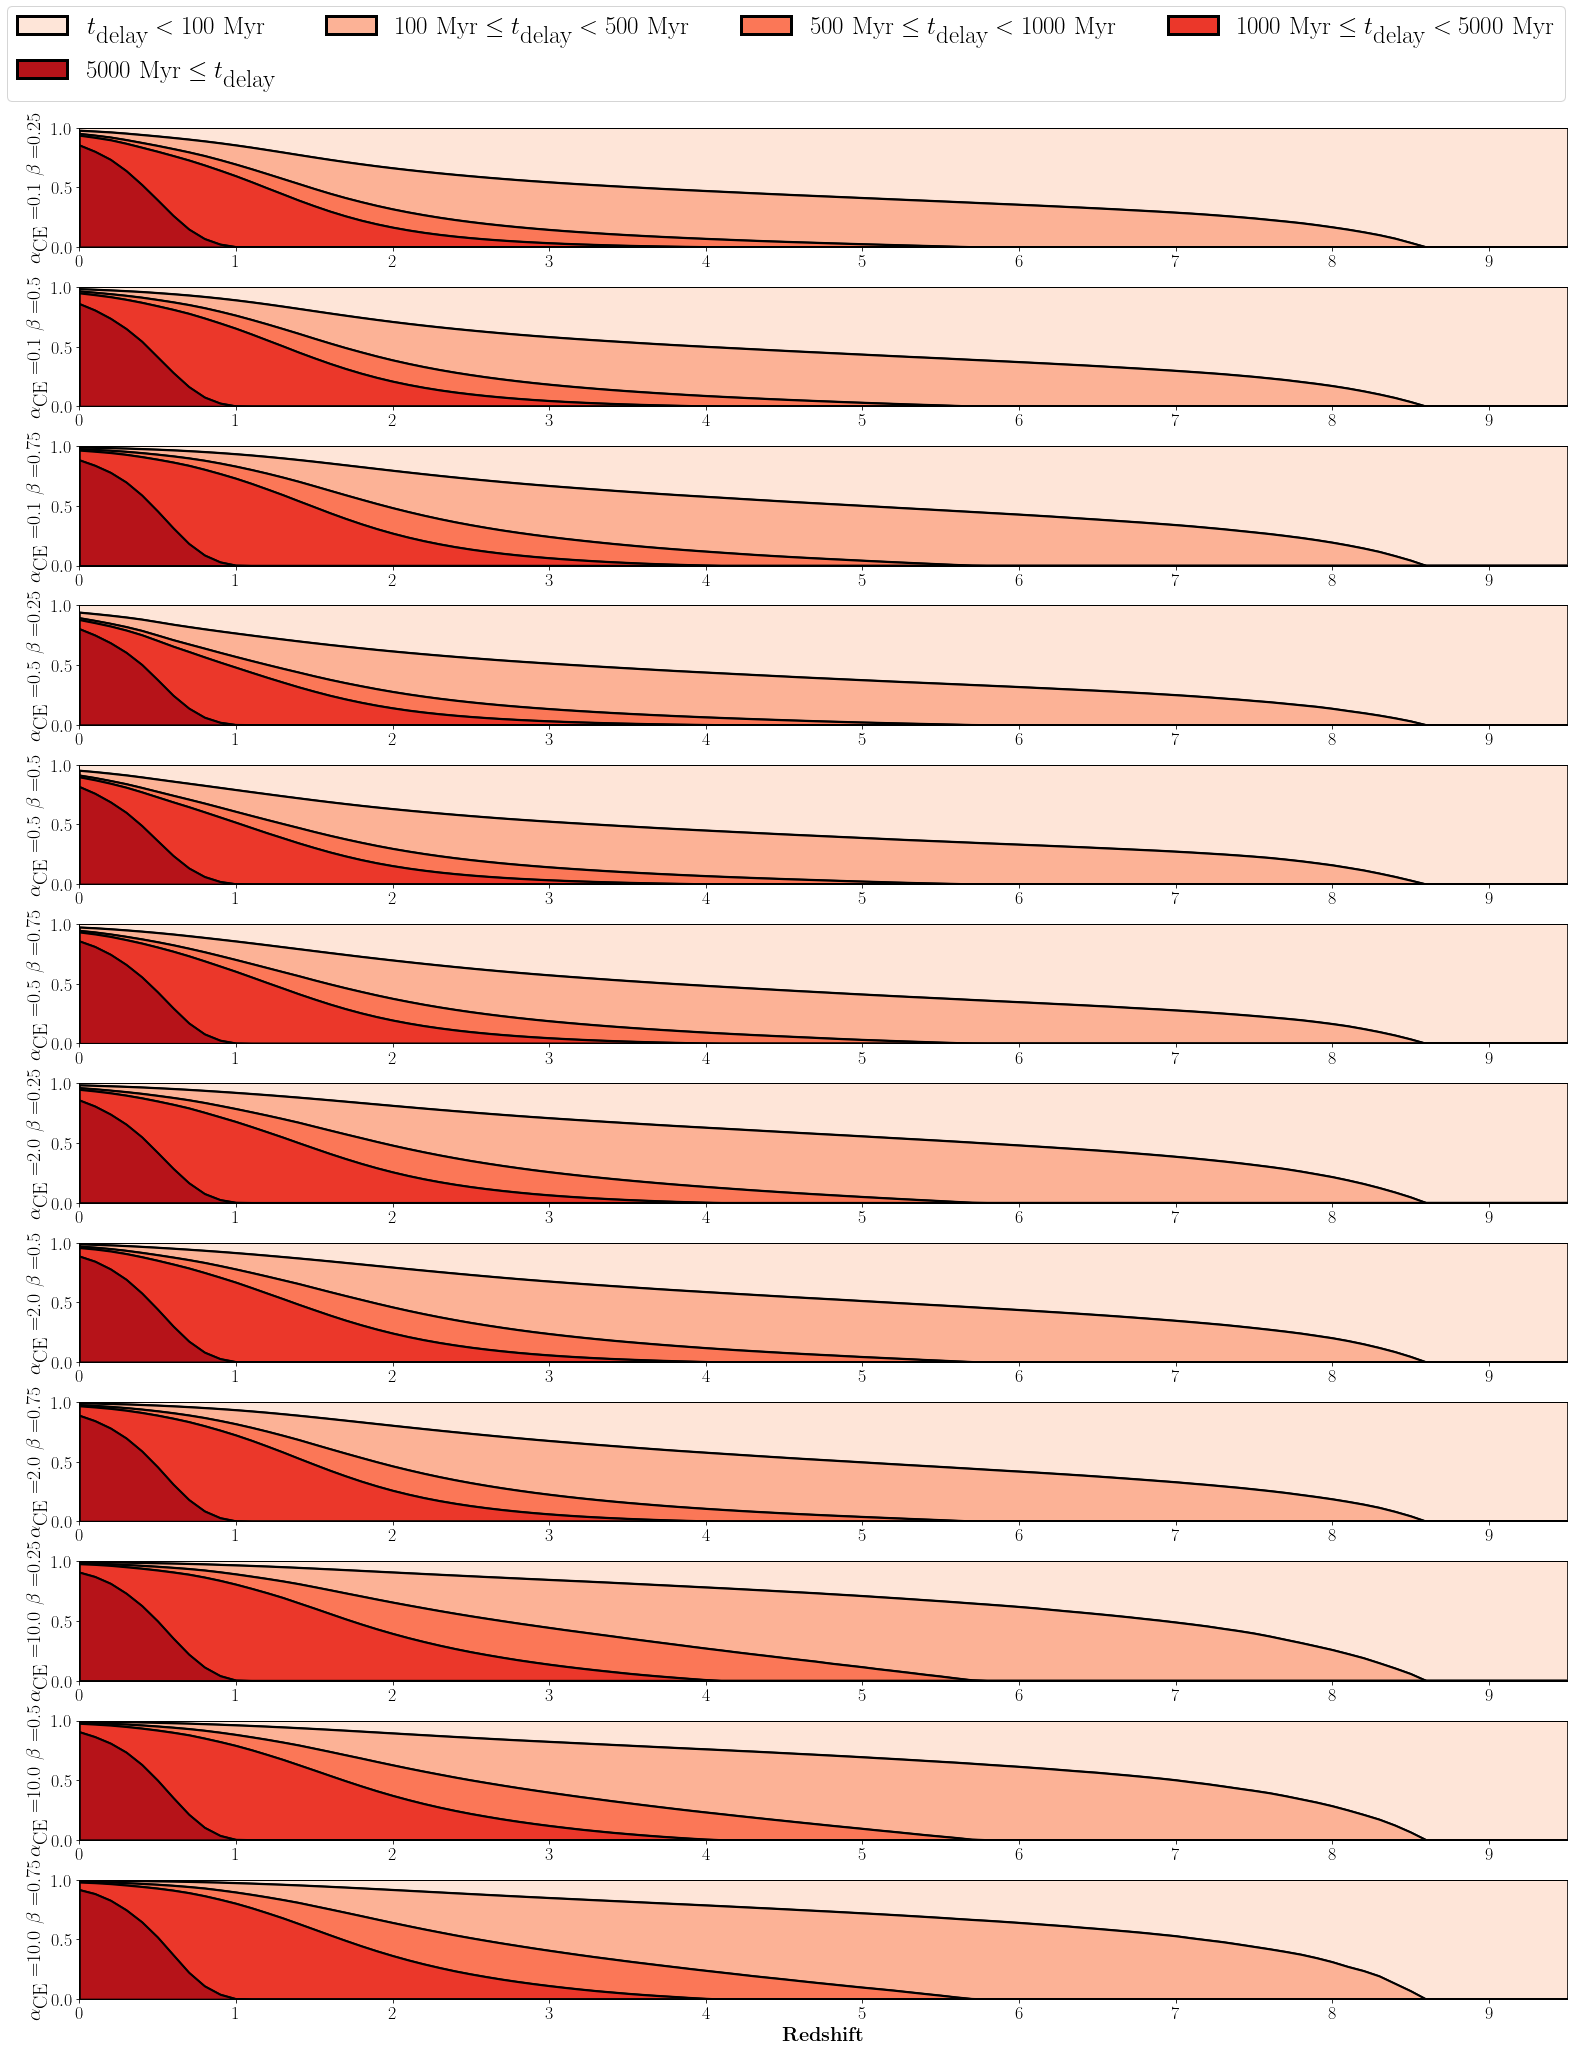

In [147]:
plot_all_rates_by_delay_time(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))                  

In [148]:
def plot_all_form_rates_by_delay_time(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=2, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # Make sure the dco_type is given
    assert dco_type != None, 'dco_type must be given'

    CI_kwargs = {'dco_type': dco_type, 'merger_output_filename': merger_output_filename, 'weight_column': weight_column, 'merges_hubble_time': merges_hubble_time, 'pessimistic_CEE': pessimistic_CEE, 
                        'no_RLOF_after_CEE': no_RLOF_after_CEE, 'max_redshift': max_redshift, 'max_redshift_detection': max_redshift_detection, 'redshift_step': redshift_step, 'z_first_SF': z_first_SF,
                        'use_sampled_mass_ranges': use_sampled_mass_ranges, 'm1_min': m1_min, 'm1_max': m1_max, 'm2_min': m2_min, 'fbin': fbin,
                        'aSF': aSF, 'bSF': bSF, 'cSF': cSF, 'dSF': dSF,
                        'mu0': mu0, 'muz': muz, 'sigma0': sigma0, 'sigmaz': sigmaz, 'alpha': alpha, 
                        'min_logZ': min_logZ, 'max_logZ': max_logZ, 'step_logZ': step_logZ,
                        'sensitivity': sensitivity, 'snr_threshold': snr_threshold, 
                        'Mc_max': Mc_max, 'Mc_step': Mc_step, 'eta_max': eta_max, 'eta_step': eta_step,
                        'snr_max': snr_max, 'snr_step': snr_step,
                        'lognormal': lognormal, 'Zprescription': Zprescription, 'SFRprescription': SFRprescription,
                        'GSMFprescription': GSMFprescription, 'ZMprescription': ZMprescription,
                        'logNormalPrescription': logNormalPrescription}

    # 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)
    t_bins = [[-1, 100], [100, 500], [500, 1000], [1000, 5000], [5000, 10E5]][::-1]
    t_labels = [r'$t_\textrm{delay}<100 \textrm{ Myr}$', r'$100 \textrm{ Myr} \leq t_\textrm{delay} < 500 \textrm{ Myr}$', r'$500 \textrm{ Myr} \leq t_\textrm{delay} < 1000 \textrm{ Myr}$', r'$1000 \textrm{ Myr} \leq t_\textrm{delay} < 5000 \textrm{ Myr}$', r'$5000 \textrm{ Myr} \leq t_\textrm{delay}$'][::-1]
    bin_strs = {}

    # Make dictionaries to put the rates in
    total_merger_rates = {}
    redshifts = {}

    for alpha_val in alpha_vals:

        # Make sub dict for alpha value
        total_merger_rates[alpha_val] = {}
        redshifts[alpha_val] = {}
        bin_strs[alpha_val] = {}

        for beta_val in beta_vals:

            # Make sub dict for beta value
            total_merger_rates[alpha_val][beta_val] = {}
            redshifts[alpha_val][beta_val] = {}
            bin_strs[alpha_val][beta_val] = []

            # Get and put data into dicts
            with open(path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val + '/Pickled_Rates/MSSFR_111/' + dco_type + '/rates_and_bootstraps_by_delay_time.h5', 'rb') as f:
                for t_bin in t_bins:
                    bin_str = 'delay_time_in_'+str(t_bin[0])+'_'+str(t_bin[1])
                    bin_strs[alpha_val][beta_val].append(bin_str)
                    
                    # Get data
                    h5_data = h5.File(f)
                    print(h5_data[bin_str].keys())
                    total_merger_rates[alpha_val][beta_val][bin_str] = h5_data[bin_str]['total_formation_rates'][...]
                    redshifts[alpha_val][beta_val][bin_str] = h5_data[bin_str]['redshifts'][...]

    ###########################
    #Start plotting

    # set some constants for the plots
    plt.rc('font', family='serif')
    fs = 20
    num_models = len(alpha_vals) * len(beta_vals)
    fig, axes = plt.subplots(num_models, 1, figsize=(21.7, 27))
    cmap = plt.get_cmap('Reds')

    axis_counter = 0
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:

            cum_sums = {}
            total_sums = {}

            for t_index, t_bin in enumerate(t_bins):
                # Plot each of the panels, and their confidence intervals
                bin_key = bin_strs[alpha_val][beta_val][t_index]
                if t_index == 0:
                    cum_sum = total_merger_rates[alpha_val][beta_val][bin_key]
                else:
                    cum_sum = cum_sum + total_merger_rates[alpha_val][beta_val][bin_key]
                cum_sums[bin_key] = cum_sum
                if t_index == len(t_bins) - 1:
                    total_sum = cum_sum

            # Plot!
            for t_index, t_bin in enumerate(t_bins[::-1]):
                color = cmap(0.1 + 0.9 * t_index / (len(t_bins)))
                index = len(t_bins) - 1 - t_index
                bin_key = bin_strs[alpha_val][beta_val][index]
                if axis_counter == 0:
                    axes[axis_counter].fill_between(redshifts[alpha_val][beta_val][bin_key], cum_sums[bin_key]/total_sum, lw=lw, edgecolor='k', y2=np.zeros(len(redshifts[alpha_val][beta_val][bin_key])), facecolor=color, label=t_labels[index])
                else:
                    axes[axis_counter].fill_between(redshifts[alpha_val][beta_val][bin_key], cum_sums[bin_key]/total_sum, lw=lw, edgecolor='k', y2=np.zeros(len(redshifts[alpha_val][beta_val][bin_key])), facecolor=color)
                axes[axis_counter].plot(redshifts[alpha_val][beta_val][bin_key], cum_sums[bin_key]/total_sum, lw=0.75 * lw, color='k')
                axes[axis_counter].set_ylabel(r'$\alpha_{\textrm{CE}}=$'+str(alpha_val)+r' $\beta=$'+str(beta_val), fontsize=fs)
            
            axis_counter+=1
                
    # Label axes of all the plots
    axes[len(alpha_vals) * len(beta_vals) - 1].set_xlabel(r'\textbf{Redshift}', fontsize=fs)        

    # Set lower bounds for the plots
    for axis in axes:
        axis.set_ybound((0,1))
        axis.set_xbound((0,9.5))
    
    for axis in axes:
        axis.tick_params(labelsize=0.9*fs)
        axis.set_xticks(range(0,10))

    # renderer = fig.canvas.get_renderer()
    # shift = max([t.get_window_extent(renderer=renderer).width for t in leg.get_texts()])
    # for t in leg.get_texts():
    #     t.set_ha('right') # ha is alias for horizontalalignment
    #     t.set_position((shift,0))

    order = [0, 4, 1, 2, 3]
    handles, labels = axes[0].get_legend_handles_labels()
    leg = fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=25, ncol=4, bbox_to_anchor=(1.0, 1.06),  markerscale=25)



    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)

    # Show the plot!
    plt.tight_layout()
    plt.show()

<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_masses', 'cumulative_detection_rates', 'redshifts', 'total_formation_rates', 'total_merger_rates']>
<KeysViewHDF5 ['chirp_ma

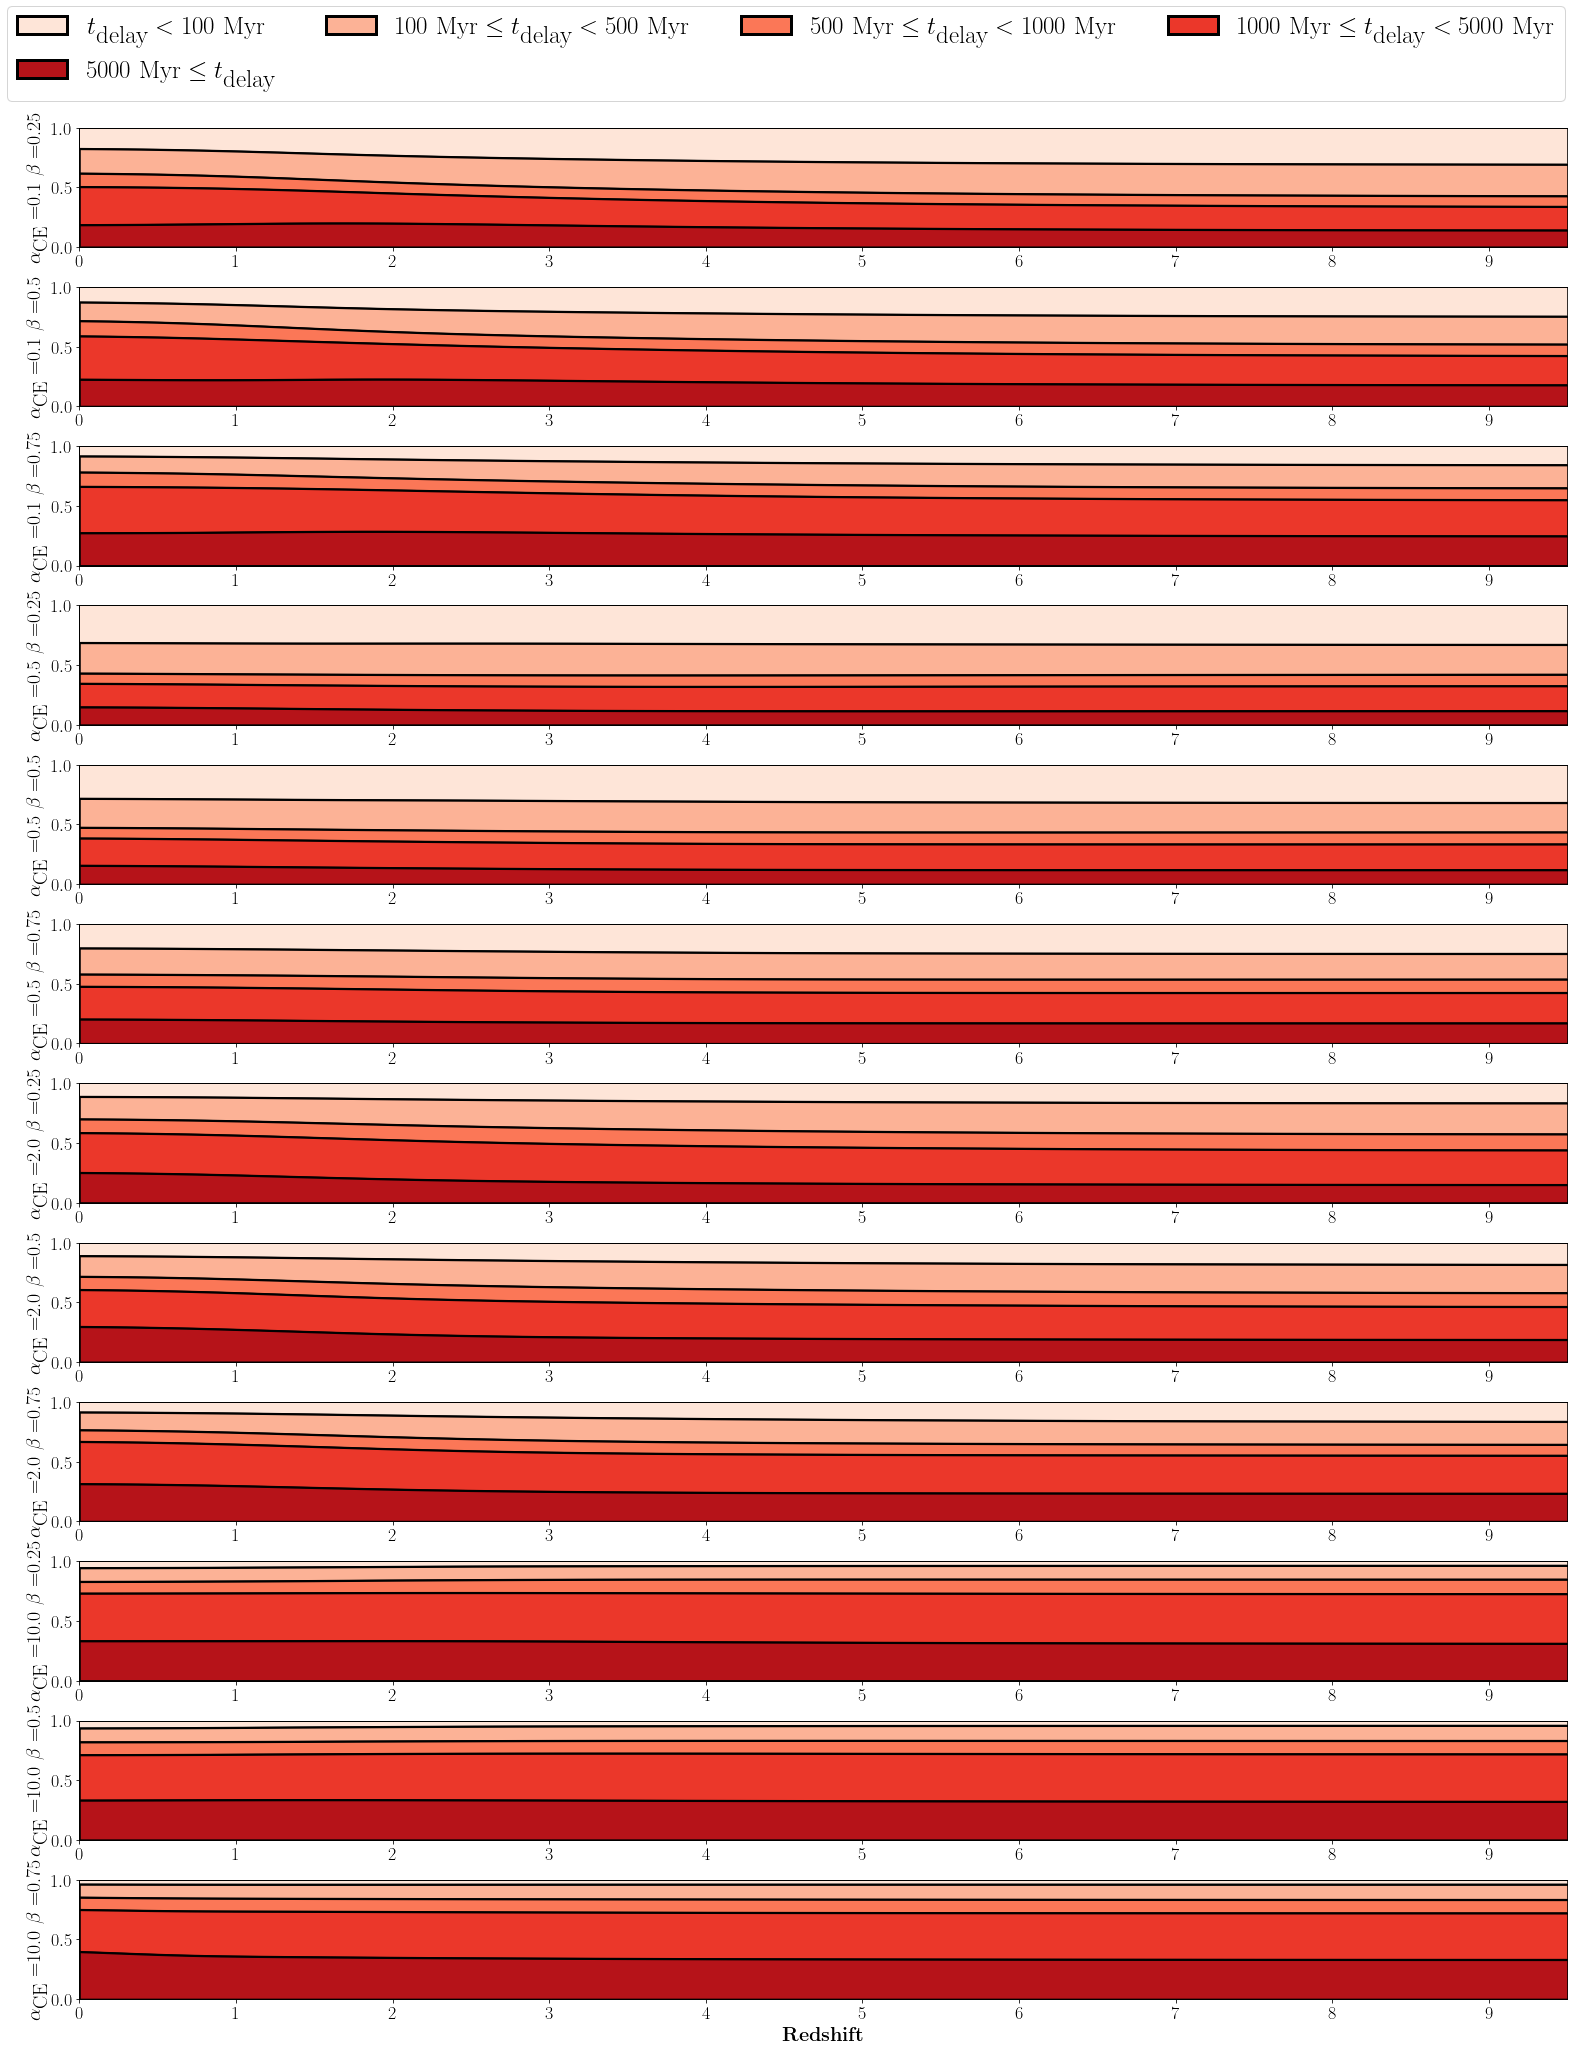

In [150]:
plot_all_form_rates_by_delay_time(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))                  